## libraries

In [260]:
from numpy.random import seed
seed(123)


from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
from sklearn.svm import SVR



# time series analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, Gr

ientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import numpy as np

from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_absolute_percentage_error as mape

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [261]:
# check the versions of key python libraries
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.12.0
numpy: 1.26.4
matplotlib: 3.8.2
pandas: 2.2.0
statsmodels: 0.14.1
sklearn: 1.4.0


## Data import

In [262]:
df_original = pd.read_csv("C:/Users/sam/Desktop/TimeSeries/Dataset/train_2324.csv")
dff= pd.read_csv('C:/Users/sam/Desktop/TimeSeries/Dataset/cleaneddf.csv')

df = df_original.copy(deep=True)
df.head()



date   weekday  ave_days
0  2007-01-04  Thursday  0.179487
1  2007-01-05    Friday  0.500000
2  2007-01-06  Saturday       NaN
3  2007-01-07    Sunday       NaN
4  2007-01-08    Monday  3.521739

In [263]:
df_original

date   weekday   ave_days
0     2007-01-04  Thursday   0.179487
1     2007-01-05    Friday   0.500000
2     2007-01-06  Saturday        NaN
3     2007-01-07    Sunday        NaN
4     2007-01-08    Monday   3.521739
...          ...       ...        ...
3004  2015-03-27    Friday  38.580756
3005  2015-03-28  Saturday   1.040000
3006  2015-03-29    Sunday  42.000000
3007  2015-03-30    Monday  63.477124
3008  2015-03-31   Tuesday  40.496689

[3009 rows x 3 columns]

In [264]:
df.tail(2)

date  weekday   ave_days
3007  2015-03-30   Monday  63.477124
3008  2015-03-31  Tuesday  40.496689

In [265]:
def acf_pacf(y, lags):
    """
    Plot of acf e pacf, 0-lag not included
    """
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    plot_acf(y, lags=lags, ax=ax[0], zero=False, auto_ylims=True, alpha=.05)
    plot_pacf(y, lags=lags, ax=ax[1], zero=False, auto_ylims=True, alpha=.05)
    plt.show()


In [266]:
def calculate_mape(concatenated_df):
    # Filter out rows where log_ave_days is zero
    non_zero_mask = concatenated_df['log_ave_days'] != 0
    concatenated_df_filtered = concatenated_df[non_zero_mask]

    # Calculate absolute error and absolute percentage error
    absolute_error = np.abs(concatenated_df_filtered['predicted_mean'] - concatenated_df_filtered['log_ave_days'])
    absolute_percentage_error = (absolute_error / 731*concatenated_df_filtered['log_ave_days'])* 100

    # Calculate MAPE
    mape = absolute_percentage_error.mean()

    return mape

In [267]:
# Define a function to calculate MAE
def calculate_mae(actual_values, predicted_values):
    n = len(actual_values)
    # Calculate the absolute differences between actual and predicted values
    absolute_errors = [abs(actual_values[i] - predicted_values[i]) for i in range(n)]
    # Calculate the mean of absolute errors
    mae = sum(absolute_errors) / n
    return mae



In [268]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [269]:
import pandas as pd

def new_features(df, label):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])  # Convert 'date' column to datetime type
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['dayofmonth'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    #df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(label, axis=1)
    y = df[label]
    return X, y

# Example usage
X, y = new_features(df, label='ave_days')
df = pd.concat([X, y], axis=1)
df.head()

date   weekday  dayofweek  quarter  dayofmonth  month  year  ave_days
0 2007-01-04  Thursday          3        1           4      1  2007  0.179487
1 2007-01-05    Friday          4        1           5      1  2007  0.500000
2 2007-01-06  Saturday          5        1           6      1  2007       NaN
3 2007-01-07    Sunday          6        1           7      1  2007       NaN
4 2007-01-08    Monday          0        1           8      1  2007  3.521739

# Preprocessing

### Duplicates

In [270]:
print(sum(df.duplicated()))

0


### NA values

In [271]:
df.isnull().sum()

date            0
weekday         0
dayofweek       0
quarter         0
dayofmonth      0
month           0
year            0
ave_days      202
dtype: int64

In [272]:
df

date   weekday  dayofweek  quarter  dayofmonth  month  year  \
0    2007-01-04  Thursday          3        1           4      1  2007   
1    2007-01-05    Friday          4        1           5      1  2007   
2    2007-01-06  Saturday          5        1           6      1  2007   
3    2007-01-07    Sunday          6        1           7      1  2007   
4    2007-01-08    Monday          0        1           8      1  2007   
...         ...       ...        ...      ...         ...    ...   ...   
3004 2015-03-27    Friday          4        1          27      3  2015   
3005 2015-03-28  Saturday          5        1          28      3  2015   
3006 2015-03-29    Sunday          6        1          29      3  2015   
3007 2015-03-30    Monday          0        1          30      3  2015   
3008 2015-03-31   Tuesday          1        1          31      3  2015   

       ave_days  
0      0.179487  
1      0.500000  
2           NaN  
3           NaN  
4      3.521739  
...         ...  
3004  38.580756  
3005   1.040000  
3006  42.000000  
3007  63.477124  
3008  40.496689  

[3009 rows x 8 columns]

In [273]:

df['week'] = df['date'].dt.isocalendar().week

weekly_means = df.groupby('week')['ave_days'].mean()
df['ave_days'] = df['ave_days'].fillna(df['week'].map(weekly_means))

# Drop the 'week' column if you don't need it anymore
df.drop(columns=['week'], inplace=True)


In [274]:
df.isnull().sum()

date          0
weekday       0
dayofweek     0
quarter       0
dayofmonth    0
month         0
year          0
ave_days      0
dtype: int64

### Handling outliers

In [275]:
df

date   weekday  dayofweek  quarter  dayofmonth  month  year  \
0    2007-01-04  Thursday          3        1           4      1  2007   
1    2007-01-05    Friday          4        1           5      1  2007   
2    2007-01-06  Saturday          5        1           6      1  2007   
3    2007-01-07    Sunday          6        1           7      1  2007   
4    2007-01-08    Monday          0        1           8      1  2007   
...         ...       ...        ...      ...         ...    ...   ...   
3004 2015-03-27    Friday          4        1          27      3  2015   
3005 2015-03-28  Saturday          5        1          28      3  2015   
3006 2015-03-29    Sunday          6        1          29      3  2015   
3007 2015-03-30    Monday          0        1          30      3  2015   
3008 2015-03-31   Tuesday          1        1          31      3  2015   

       ave_days  
0      0.179487  
1      0.500000  
2     57.539966  
3     57.539966  
4      3.521739  
...         ...  
3004  38.580756  
3005   1.040000  
3006  42.000000  
3007  63.477124  
3008  40.496689  

[3009 rows x 8 columns]

In [276]:
import pandas as pd

# Calculate quartiles and IQR
Q1 = df['ave_days'].quantile(0.25)
Q3 = df['ave_days'].quantile(0.75)
IQR = Q3 - Q1

# Determine the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['ave_days'] < lower_bound) | (df['ave_days'] > upper_bound)]

# Calculate weekly means for non-outlier data
weekly_means = df[~df.index.isin(outliers.index)].groupby(df['date'].dt.isocalendar().week)['ave_days'].mean()

# Replace outliers with the mean of the corresponding week
for index, row in outliers.iterrows():
    week_mean = weekly_means[row['date'].week]
    df.at[index, 'ave_days'] = week_mean


In [277]:
import pandas as pd


# Generate a complete date range from the minimum to the maximum date in the DataFrame
complete_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')

# Check for missing dates
missing_dates = complete_date_range[~complete_date_range.isin(df['date'])]

if missing_dates.empty:
    print("There are no missing dates in the DataFrame.")
else:
    print("Missing dates found in the DataFrame:")
    print(missing_dates)

There are no missing dates in the DataFrame.


## Train - Test split

In [324]:
df

date   weekday  dayofweek  quarter  dayofmonth  month  year  \
date                                                                           
2007-01-04 2007-01-04  Thursday          3        1           4      1  2007   
2007-01-05 2007-01-05    Friday          4        1           5      1  2007   
2007-01-06 2007-01-06  Saturday          5        1           6      1  2007   
2007-01-07 2007-01-07    Sunday          6        1           7      1  2007   
2007-01-08 2007-01-08    Monday          0        1           8      1  2007   
...               ...       ...        ...      ...         ...    ...   ...   
2015-03-27 2015-03-27    Friday          4        1          27      3  2015   
2015-03-28 2015-03-28  Saturday          5        1          28      3  2015   
2015-03-29 2015-03-29    Sunday          6        1          29      3  2015   
2015-03-30 2015-03-30    Monday          0        1          30      3  2015   
2015-03-31 2015-03-31   Tuesday          1        1          31      3  2015   

             ave_days    rolmean  
date                              
2007-01-04   0.179487        NaN  
2007-01-05   0.500000        NaN  
2007-01-06  57.539966        NaN  
2007-01-07  57.539966        NaN  
2007-01-08   3.521739        NaN  
...               ...        ...  
2015-03-27  38.580756  42.720260  
2015-03-28   1.040000  40.878271  
2015-03-29  42.000000  39.678422  
2015-03-30  63.477124  41.708400  
2015-03-31  40.496689  43.024957  

[3009 rows x 9 columns]

In [279]:
df

date   weekday  dayofweek  quarter  dayofmonth  month  year  \
0    2007-01-04  Thursday          3        1           4      1  2007   
1    2007-01-05    Friday          4        1           5      1  2007   
2    2007-01-06  Saturday          5        1           6      1  2007   
3    2007-01-07    Sunday          6        1           7      1  2007   
4    2007-01-08    Monday          0        1           8      1  2007   
...         ...       ...        ...      ...         ...    ...   ...   
3004 2015-03-27    Friday          4        1          27      3  2015   
3005 2015-03-28  Saturday          5        1          28      3  2015   
3006 2015-03-29    Sunday          6        1          29      3  2015   
3007 2015-03-30    Monday          0        1          30      3  2015   
3008 2015-03-31   Tuesday          1        1          31      3  2015   

       ave_days  
0      0.179487  
1      0.500000  
2     57.539966  
3     57.539966  
4      3.521739  
...         ...  
3004  38.580756  
3005   1.040000  
3006  42.000000  
3007  63.477124  
3008  40.496689  

[3009 rows x 8 columns]

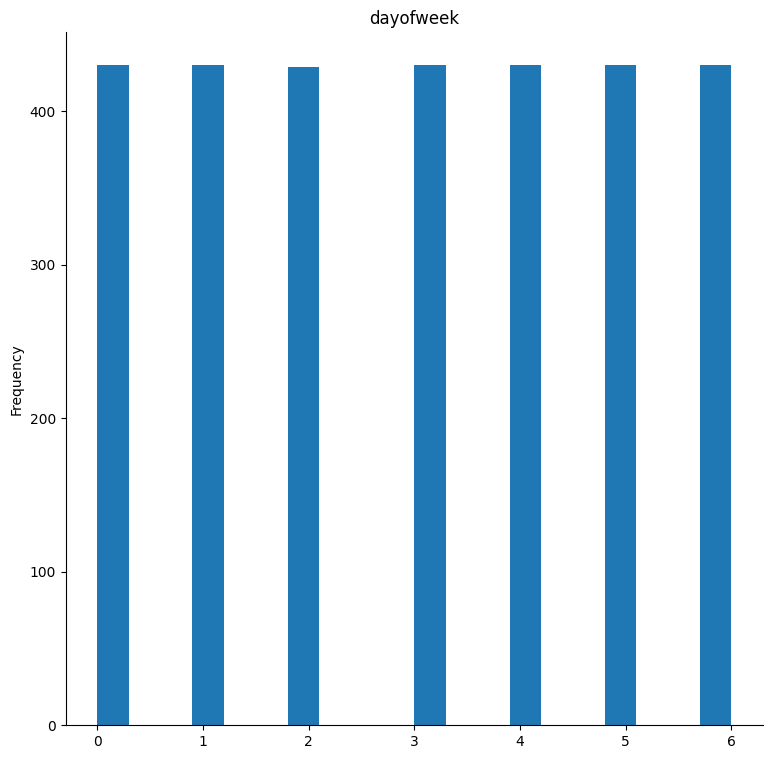

In [280]:
# @title dayofweek

from matplotlib import pyplot as plt
df['dayofweek'].plot(kind='hist', bins=20, title='dayofweek')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [325]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Convert index to datetime if not already in datetime format
df.index = pd.to_datetime(df.date)

# Split the DataFrame into training and testing sets based on the index (date)
df_train_or = df[df.date < pd.Timestamp('2013-03-31')].copy()
df_test_or = df[df.date >= pd.Timestamp('2013-03-31')].copy()

df_train


ave_days  log_ave_days
date                               
2007-01-04   0.179487     -1.717651
2007-01-05   0.500000     -0.693147
2007-01-06  57.539966      4.052480
2007-01-07  57.539966      4.052480
2007-01-08   3.521739      1.258955
...               ...           ...
2013-03-26  25.945813      3.256010
2013-03-27  31.072948      3.436338
2013-03-28  44.032738      3.784933
2013-03-29  33.436364      3.509644
2013-03-30   1.244898      0.219054

[2278 rows x 2 columns]

In [326]:
df_train_or['ave_days']
df_train_or['ave_days']

date    weekday  dayofweek  quarter  dayofmonth  month  year  \
date                                                                            
2007-01-04 2007-01-04   Thursday          3        1           4      1  2007   
2007-01-05 2007-01-05     Friday          4        1           5      1  2007   
2007-01-06 2007-01-06   Saturday          5        1           6      1  2007   
2007-01-07 2007-01-07     Sunday          6        1           7      1  2007   
2007-01-08 2007-01-08     Monday          0        1           8      1  2007   
...               ...        ...        ...      ...         ...    ...   ...   
2013-03-26 2013-03-26    Tuesday          1        1          26      3  2013   
2013-03-27 2013-03-27  Wednesday          2        1          27      3  2013   
2013-03-28 2013-03-28   Thursday          3        1          28      3  2013   
2013-03-29 2013-03-29     Friday          4        1          29      3  2013   
2013-03-30 2013-03-30   Saturday          5        1          30      3  2013   

             ave_days    rolmean  
date                              
2007-01-04   0.179487        NaN  
2007-01-05   0.500000        NaN  
2007-01-06  57.539966        NaN  
2007-01-07  57.539966        NaN  
2007-01-08   3.521739        NaN  
...               ...        ...  
2013-03-26  25.945813  25.269784  
2013-03-27  31.072948  25.945476  
2013-03-28  44.032738  27.190823  
2013-03-29  33.436364  27.972790  
2013-03-30   1.244898  27.197878  

[2278 rows x 9 columns]

In [327]:


# Select only the 'date' and 'avg_days' columns
df_train = df_train_or['ave_days']
df_test = df_test_or['ave_days']
print(f'Train set size: {len(df_train)}')
print(f'Test set size: {len(df_test)}')


Train set size: 2278
Test set size: 731


In [328]:
df_train.tail()

date
2013-03-26    25.945813
2013-03-27    31.072948
2013-03-28    44.032738
2013-03-29    33.436364
2013-03-30     1.244898
Name: ave_days, dtype: float64

In [329]:
df_test

date
2013-03-31    32.854278
2013-04-01    34.233516
2013-04-02    48.228261
2013-04-03    25.140468
2013-04-04    31.764085
                ...    
2015-03-27    38.580756
2015-03-28     1.040000
2015-03-29    42.000000
2015-03-30    63.477124
2015-03-31    40.496689
Name: ave_days, Length: 731, dtype: float64

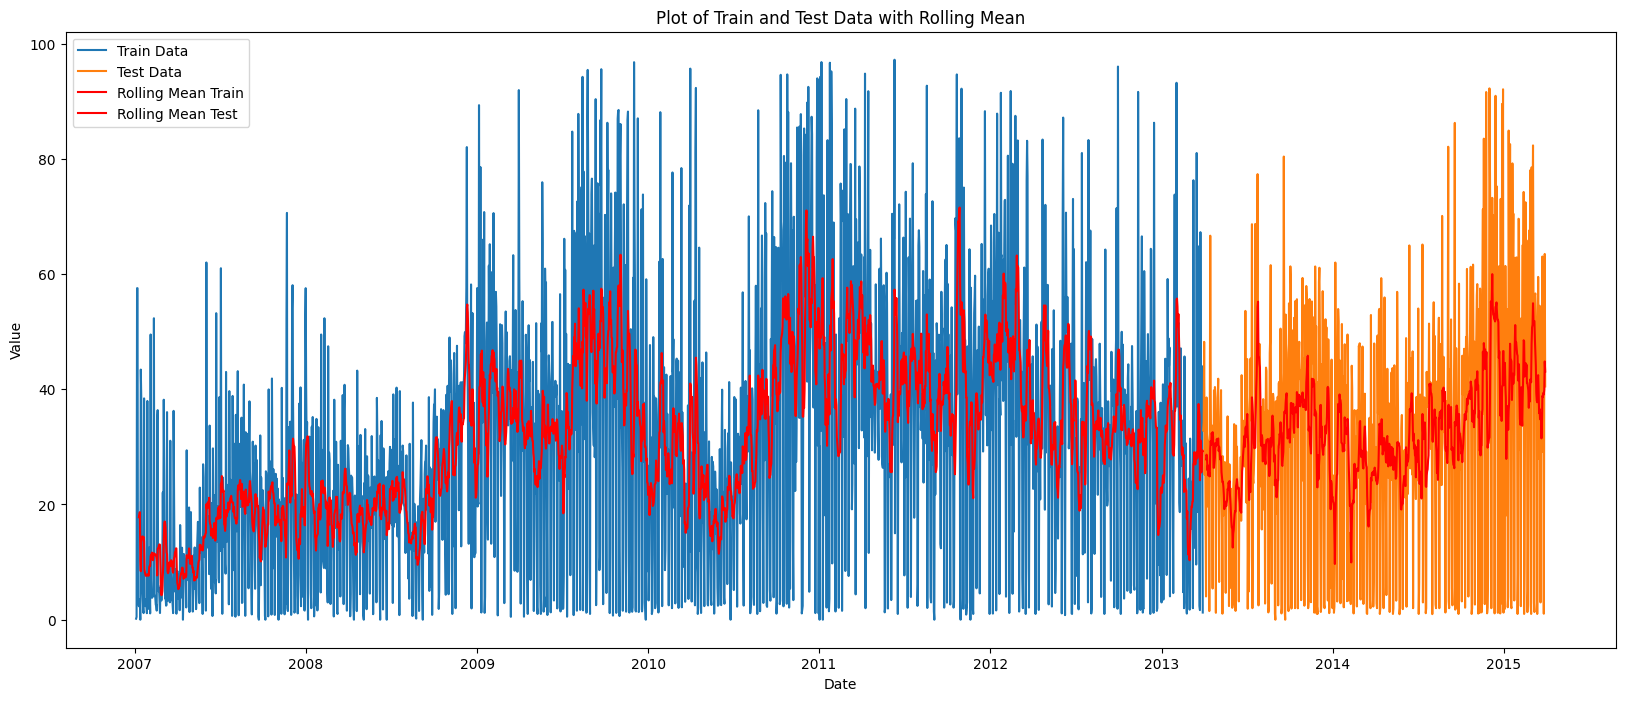

In [330]:
import matplotlib.pyplot as plt

# Assuming df_train and df_test are your DataFrame variables
# Calculate the rolling mean with a window size of your choice
rolling_mean_train = df_train.rolling(window=7).mean()
rolling_mean_test = df_test.rolling(window=7).mean()

# Plot the original data and the rolling mean
plt.figure(figsize=(20, 8))
plt.plot(df_train, label='Train Data')
plt.plot(df_test, label='Test Data')
plt.plot(rolling_mean_train, label='Rolling Mean Train', linestyle='-', color='red')
plt.plot(rolling_mean_test, label='Rolling Mean Test', linestyle='-', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot of Train and Test Data with Rolling Mean')
plt.legend()

# Show the plot
plt.show()


# EDA

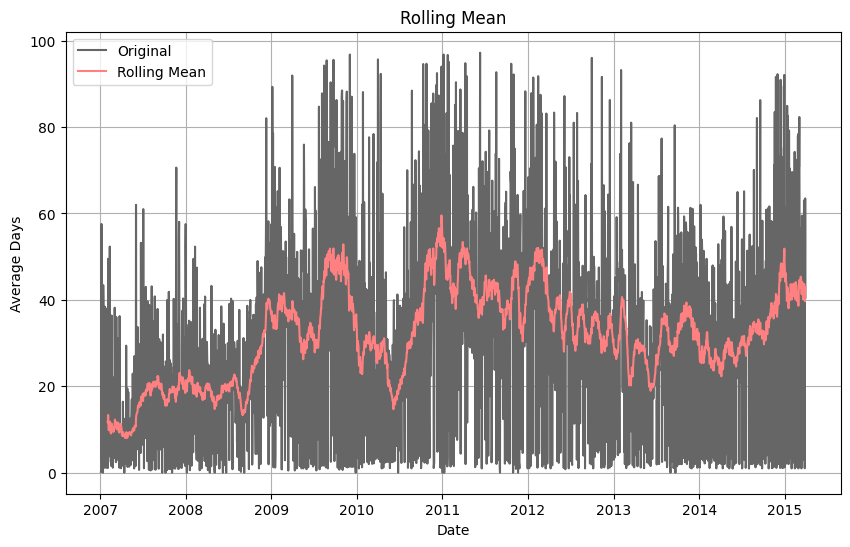

In [331]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Calculate rolling mean and add it as a new column
df['rolmean'] = df['ave_days'].rolling(window=30).mean()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['ave_days'], color='#666666', label='Original')  # Original data
plt.plot(df.index, df['rolmean'], color='#ff8080', label='Rolling Mean')  # R   olling mean
plt.title('Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Average Days')
plt.legend()
plt.grid(True)
plt.show()


# daily average values (ave_days) in grey and the 30-day rolling mean
# The rolling mean helps smooth out fluctuations in the original data
#  and reveal underlying trends. Which suggests a trend and some seasonality in the data.


In [332]:
df_day = df[['ave_days']].resample("D").sum()
df_day

ave_days
date                 
2007-01-04   0.179487
2007-01-05   0.500000
2007-01-06  57.539966
2007-01-07  57.539966
2007-01-08   3.521739
...               ...
2015-03-27  38.580756
2015-03-28   1.040000
2015-03-29  42.000000
2015-03-30  63.477124
2015-03-31  40.496689

[3009 rows x 1 columns]

In [333]:
df_day

ave_days
date                 
2007-01-04   0.179487
2007-01-05   0.500000
2007-01-06  57.539966
2007-01-07  57.539966
2007-01-08   3.521739
...               ...
2015-03-27  38.580756
2015-03-28   1.040000
2015-03-29  42.000000
2015-03-30  63.477124
2015-03-31  40.496689

[3009 rows x 1 columns]

In [334]:
df_day[df_day['ave_days']==0].value_counts()

ave_days
0.0         20
Name: count, dtype: int64

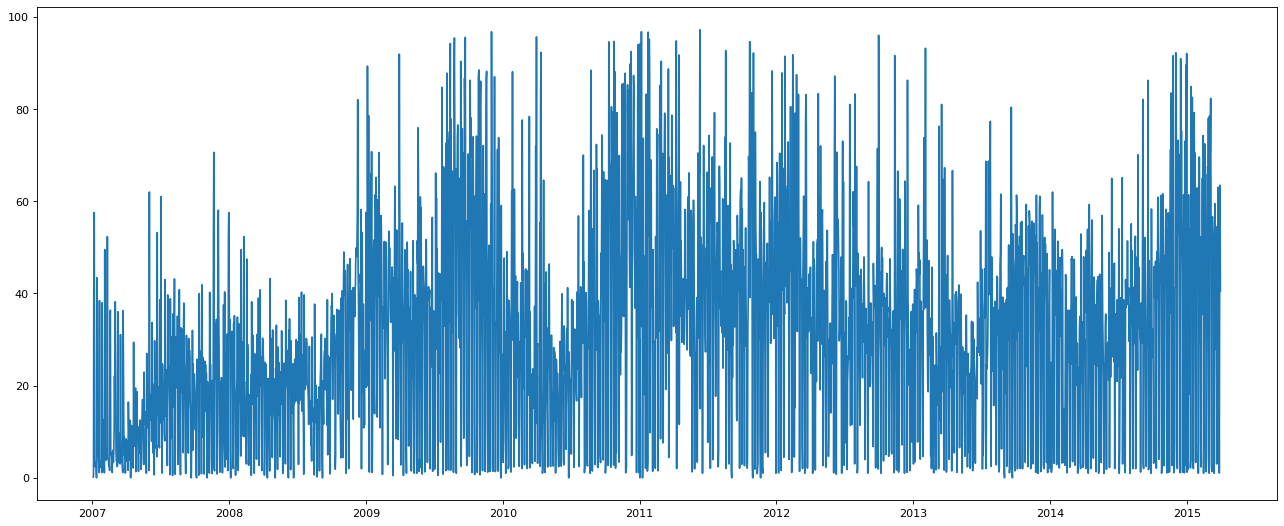

In [335]:


fig = plt.figure(figsize=(20,8), dpi=80)
plt.plot(df_day.index, df_day.ave_days)
# plt.title('Daily level')
plt.show()

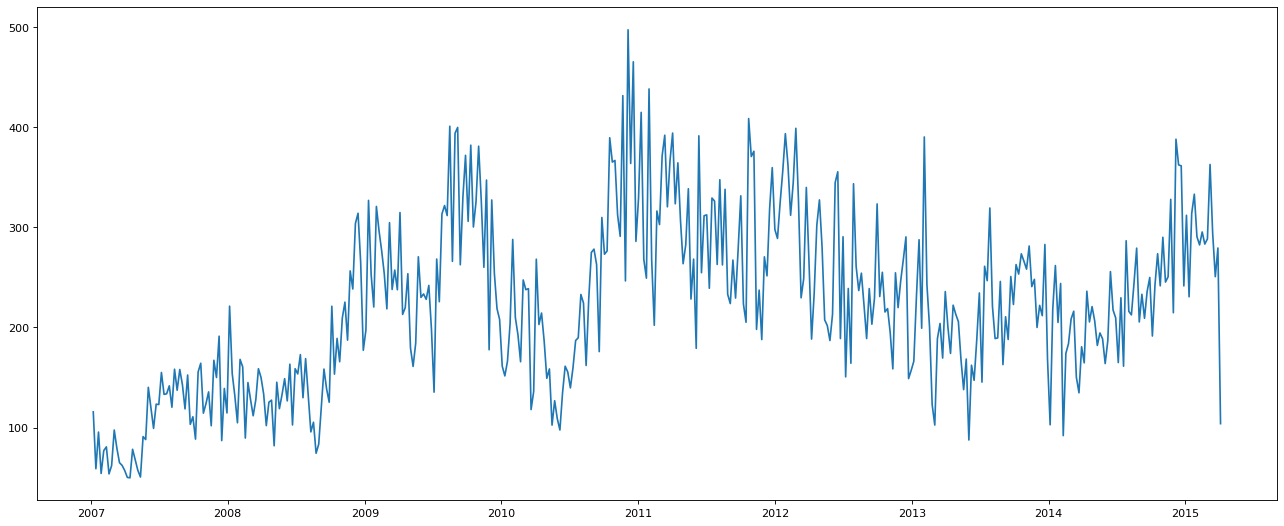

In [336]:
weekly = df[['ave_days']].resample("W").sum()

fig = plt.figure(figsize=(20,8), dpi=80)
plt.plot(weekly.index, weekly.ave_days)
# plt.title('Weekly level')
plt.show()


C:\Users\sam\AppData\Local\Temp\ipykernel_22308\586194089.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



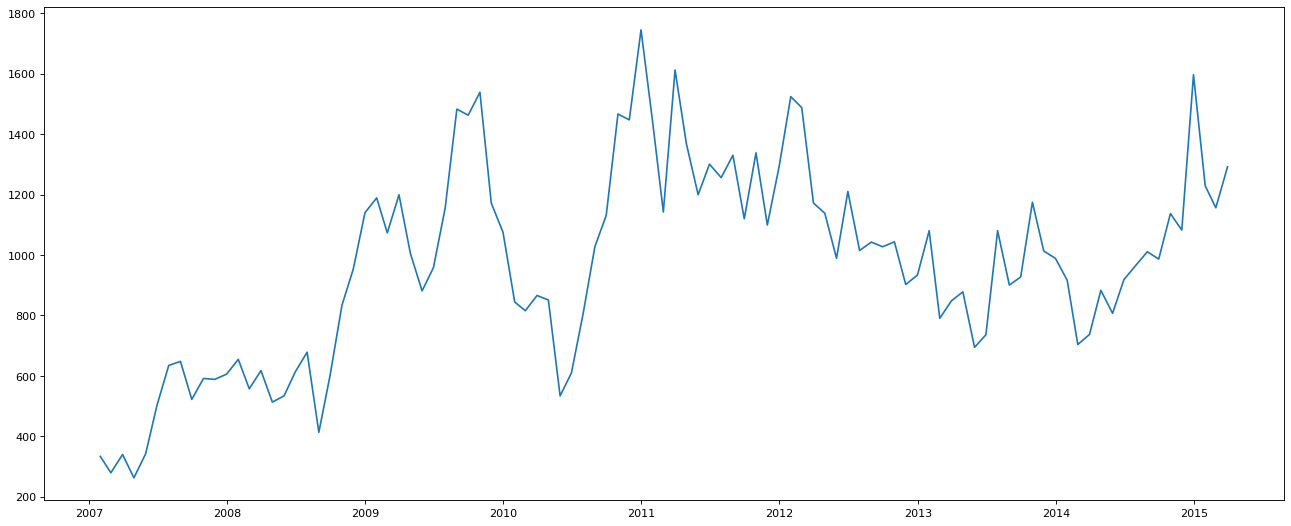

In [337]:
# Monthly
df_month = df[['ave_days']].resample("M").sum()


fig = plt.figure(figsize=(20,8), dpi=80)
plt.plot(df_month.index, df_month.ave_days)
# plt.title('Monthly level')
plt.show()

In [338]:
df

date   weekday  dayofweek  quarter  dayofmonth  month  year  \
date                                                                           
2007-01-04 2007-01-04  Thursday          3        1           4      1  2007   
2007-01-05 2007-01-05    Friday          4        1           5      1  2007   
2007-01-06 2007-01-06  Saturday          5        1           6      1  2007   
2007-01-07 2007-01-07    Sunday          6        1           7      1  2007   
2007-01-08 2007-01-08    Monday          0        1           8      1  2007   
...               ...       ...        ...      ...         ...    ...   ...   
2015-03-27 2015-03-27    Friday          4        1          27      3  2015   
2015-03-28 2015-03-28  Saturday          5        1          28      3  2015   
2015-03-29 2015-03-29    Sunday          6        1          29      3  2015   
2015-03-30 2015-03-30    Monday          0        1          30      3  2015   
2015-03-31 2015-03-31   Tuesday          1        1          31      3  2015   

             ave_days    rolmean  
date                              
2007-01-04   0.179487        NaN  
2007-01-05   0.500000        NaN  
2007-01-06  57.539966        NaN  
2007-01-07  57.539966        NaN  
2007-01-08   3.521739        NaN  
...               ...        ...  
2015-03-27  38.580756  42.720260  
2015-03-28   1.040000  40.878271  
2015-03-29  42.000000  39.678422  
2015-03-30  63.477124  41.708400  
2015-03-31  40.496689  43.024957  

[3009 rows x 9 columns]

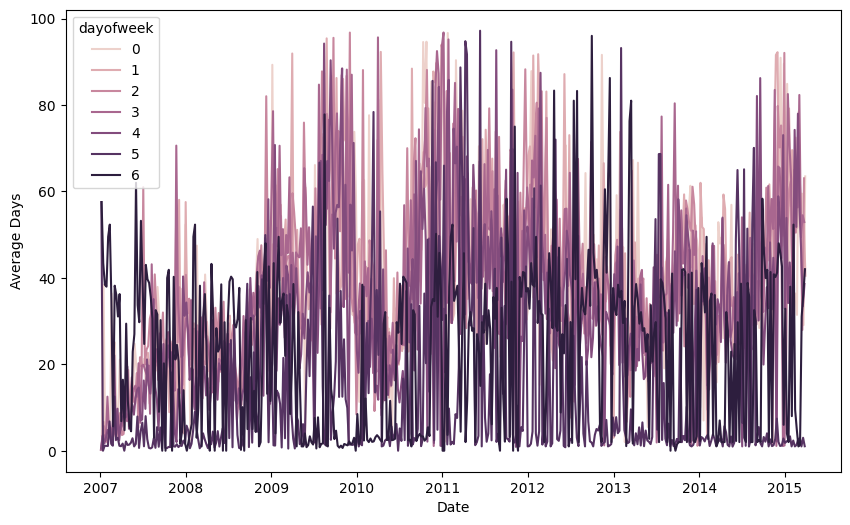

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x=df.index, y=df['ave_days'], hue=df['dayofweek'])
plt.xlabel('Date')
plt.ylabel('Average Days')
plt.show()



In [340]:
# Resample the data by month and sum the sales for each month
monthly_sales_sum = df.resample('M')['ave_days'].sum()

# Group by year and month and calculate the sum of sales for each month
monthly_sales_sum_by_year = df.groupby([df.index.year, df.index.month])['ave_days'].sum()

# Reshape the multi-index series to a DataFrame
monthly_sales_sum_by_year = monthly_sales_sum_by_year.unstack()

C:\Users\sam\AppData\Local\Temp\ipykernel_22308\136308606.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



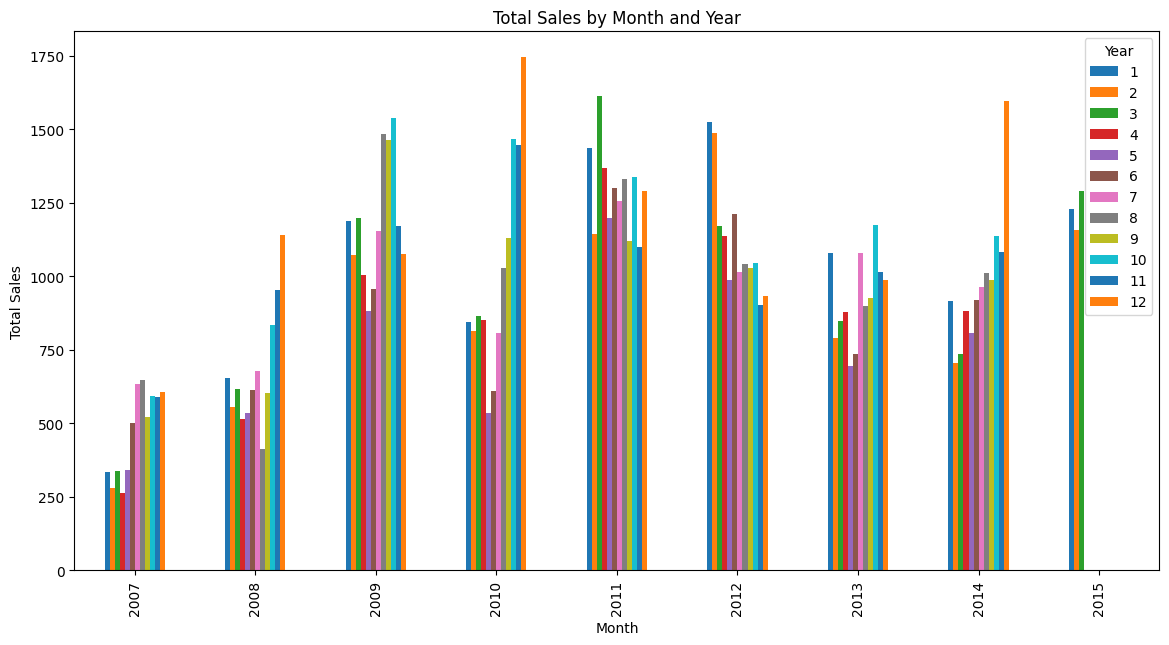

In [341]:

monthly_sales_sum_by_year.plot(kind='bar', figsize=(14, 7))

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month and Year')

# Showing the plot
plt.legend(title='Year')
plt.show()


## ARIMA MODELS

In [342]:
df_arima = df[['ave_days']]

C:\Users\sam\AppData\Local\Temp\ipykernel_22308\423139435.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\sam\AppData\Local\Temp\ipykernel_22308\423139435.py:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



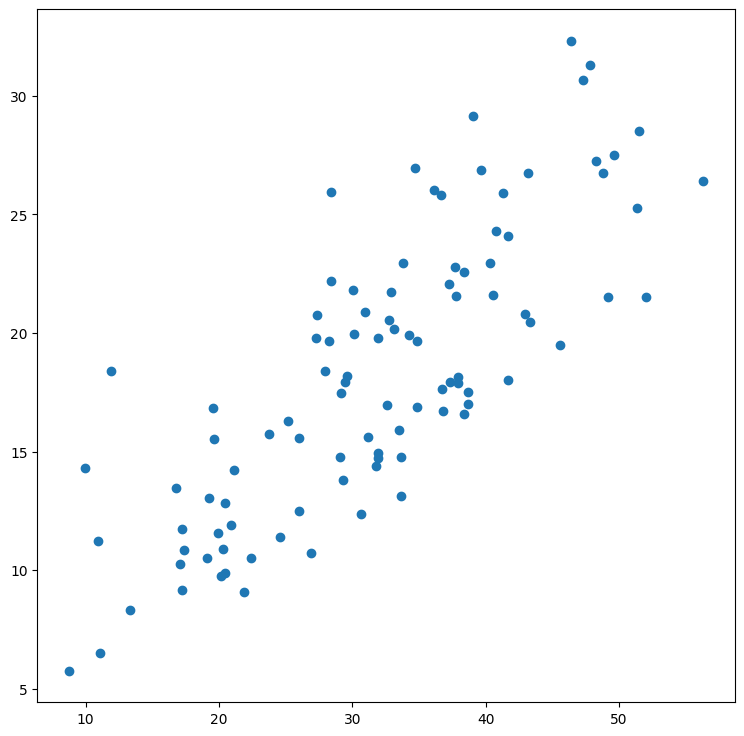

In [343]:
plt.rcParams["figure.figsize"] = (9,9)

d1 = df_arima.resample('M').mean()
x = list(d1['ave_days'])
d2 = df_arima.resample('M').std()
y = list(d2['ave_days'])

plt.scatter(x, y)
plt.show()

## greater variability in those months.the variability increases more significantly
#  for months with already high average values.

In [344]:
df_arima['ave_days']

date
2007-01-04     0.179487
2007-01-05     0.500000
2007-01-06    57.539966
2007-01-07    57.539966
2007-01-08     3.521739
                ...    
2015-03-27    38.580756
2015-03-28     1.040000
2015-03-29    42.000000
2015-03-30    63.477124
2015-03-31    40.496689
Name: ave_days, Length: 3009, dtype: float64

## Adfuller Testing


In [345]:

from statsmodels.tsa.stattools import adfuller

# The Dickey-Fuller test aims to determine if a time series data has a unit root, which essentially means
# that the data exhibits a stochastic trend and is non-stationary. In simpler terms, the null hypothesis
# of the Dickey-Fuller test is that the data has a unit root, indicating non-stationarity.

result = adfuller(df_arima['ave_days'],
                  autolag = 'AIC',
                  regression= 'n')
print('p-value: %f' % result[1])

# we would conclude that there is insufficient evidence to support
# the hypothesis of stationarity.

p-value: 0.390621


## TS Differencing

In [346]:
x = df_arima.diff()[1:]

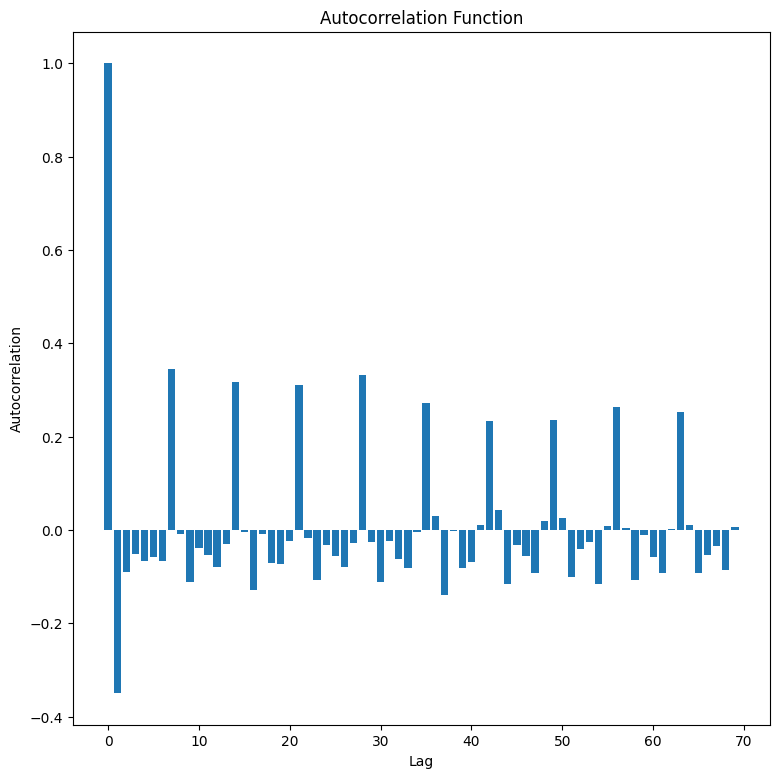

In [347]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
num_lags = 70
acf_vals = acf(x.ave_days, nlags=num_lags)
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')

plt.show()

In [348]:
xs = np.log(df_arima)
# seasonal differences applied to the data is 28
# to remove the seasonal pattern from the data
y = xs.diff(periods = 28)
y

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning:

divide by zero encountered in log



ave_days
date                
2007-01-04       NaN
2007-01-05       NaN
2007-01-06       NaN
2007-01-07       NaN
2007-01-08       NaN
...              ...
2015-03-27 -0.703897
2015-03-28 -0.907707
2015-03-29  3.737670
2015-03-30 -0.212555
2015-03-31 -0.564202

[3009 rows x 1 columns]

In [349]:

fig = px.line(y, x= df_arima.index, y = "ave_days")
fig.show()

In [350]:
df.columns

Index(['date', 'weekday', 'dayofweek', 'quarter', 'dayofmonth', 'month',
       'year', 'ave_days', 'rolmean'],
      dtype='object')

In [351]:
from statsmodels.tsa.stattools import adfuller

# Drop NaN values from the endogenous variable
y_no_missing = y['ave_days'].dropna()
y_no_missing_df = y_no_missing.to_frame()
y_no_missing_df


ave_days
date                
2007-02-01  4.244048
2007-02-02  2.260621
2007-02-03 -3.961508
2007-02-04 -0.150509
2007-02-05  0.395297
...              ...
2015-03-27 -0.703897
2015-03-28 -0.907707
2015-03-29  3.737670
2015-03-30 -0.212555
2015-03-31 -0.564202

[2980 rows x 1 columns]

In [352]:
y_no_missing.isna().sum()

0

## Adfuller > Differencing

In [353]:
from statsmodels.tsa.stattools import adfuller




# Drop missing values from the 'ave_days' column
y_no_missing = y_no_missing_df['ave_days'].dropna()

# Remove any infinite values (inf) and missing values (nan)
y_cleaned = y_no_missing.replace([np.inf, -np.inf], np.nan).dropna()

# Perform the Augmented Dickey-Fuller test
result = adfuller(y_cleaned, autolag='AIC', regression='n')

# Print the p-value
print('p-value: %f' % result[1])
## The value is less than 0.05

# We can therefore proceed by assuming that the time series is stationary.
# The log (lambda parameter = 0) and diff (part I) will be specified within
# the ARIMA model. It is not necessary to feed the already stationary time series
# to the Arima model.
# In this way the forecasts do not need to be adjusted later, they already represent
# the right values. We will also try to capture weekly seasonality


p-value: 0.000000


### ACF & PACF TESTS

In [354]:
df_train.head()

date
2007-01-04     0.179487
2007-01-05     0.500000
2007-01-06    57.539966
2007-01-07    57.539966
2007-01-08     3.521739
Name: ave_days, dtype: float64

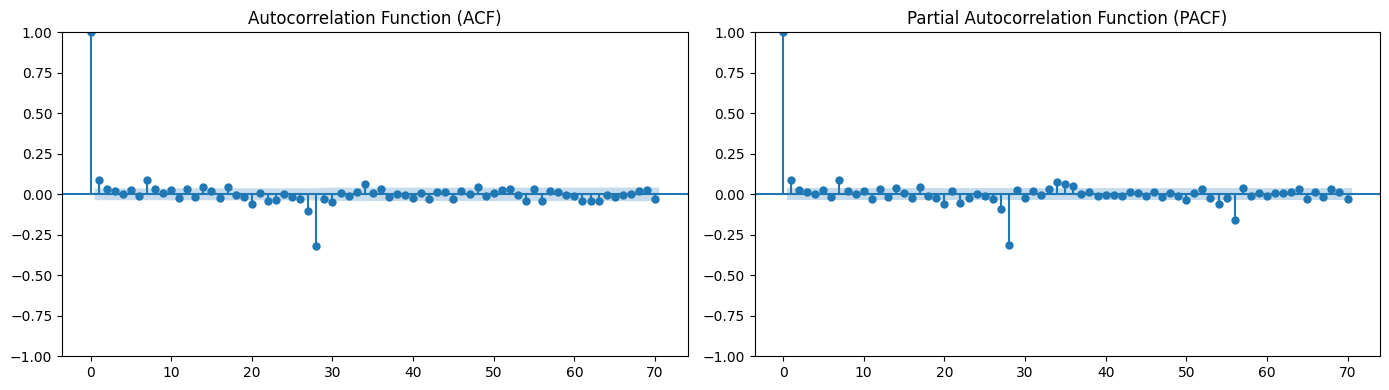

In [355]:
# Plot ACF and PACF
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(y_cleaned, lags=70, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(1, 2, 2)
plot_pacf(y_cleaned, lags=70, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


### DATA TRANSFORMATION

In [356]:
df_train = df_train.to_frame()

In [357]:

# Compute variance of original data
variance_original = df_train['ave_days'].var()
print("Variance of original data:", variance_original)

# Apply log transformation
df_train['log_ave_days'] =  df_train['ave_days'].apply(lambda x: 0 if x == 0 else np.log(x))

# Compute variance of transformed data
variance_transformed = df_train['log_ave_days'].var()
print("Variance of log-transformed data:", variance_transformed)


# Variance of original data: 490.58315907195816
# Variance of log-transformed data: 1.405732230446797


Variance of original data: 490.58315907195816
Variance of log-transformed data: 1.405732230446797


In [358]:
df_test = df_test.to_frame()

In [313]:
df_test.drop(df_test.index[-1], inplace=True)

In [314]:
df_test

ave_days
date                 
2013-03-31  32.854278
2013-04-01  34.233516
2013-04-02  48.228261
2013-04-03  25.140468
2013-04-04  31.764085
...               ...
2015-03-26  52.910112
2015-03-27  38.580756
2015-03-28   1.040000
2015-03-29  42.000000
2015-03-30  63.477124

[730 rows x 1 columns]

In [315]:
df_test['log_ave_days'] =  df_test['ave_days'].apply(lambda x: 0 if x == 0 else np.log(x))

In [316]:
import numpy as np

# Compute standard deviation of original data
std_dev_original = df_train['ave_days'].std()

# Compute standard deviation of transformed data
std_dev_transformed = df_train['log_ave_days'].std()

# Print the standard deviations
print("Standard deviation of original data:", std_dev_original)
print("Standard deviation of log-transformed data:", std_dev_transformed)

# Compare standard deviations
if std_dev_original < std_dev_transformed:
    print("Standard deviation of original data is less than standard deviation of log-transformed data.")
elif std_dev_original > std_dev_transformed:
    print("Standard deviation of original data is greater than standard deviation of log-transformed data.")
else:
    print("Standard deviation of original data is equal to standard deviation of log-transformed data.")


Standard deviation of original data: 22.1491119251305
Standard deviation of log-transformed data: 1.1856357916522244
Standard deviation of original data is greater than standard deviation of log-transformed data.


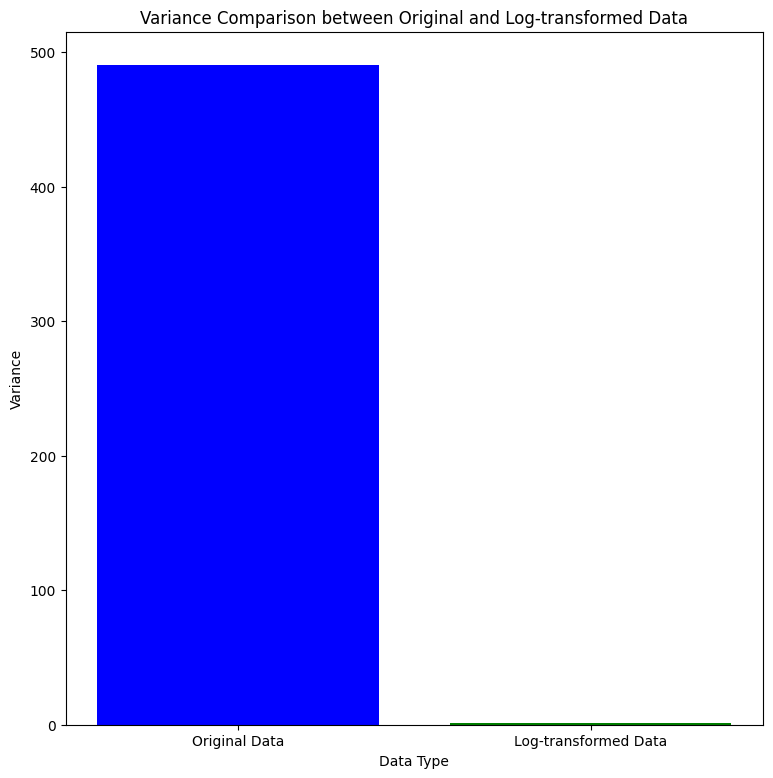

In [317]:
import matplotlib.pyplot as plt

# Assuming you have already computed variance_original and variance_transformed

# Create a list of variances and corresponding labels
variances = [variance_original, variance_transformed]
labels = ['Original Data', 'Log-transformed Data']

# Plotting the variances
plt.bar(labels, variances, color=['blue', 'green'])

# Adding labels and title
plt.xlabel('Data Type')
plt.ylabel('Variance')
plt.title('Variance Comparison between Original and Log-transformed Data')

# Showing the plot
plt.show()


In [318]:


# Compute variance of original data
variance_original = df_test.var()
print("Variance of original data:", variance_original)

# Apply log transformation
df_test['log_ave_days'] = df_test.apply(lambda x: 0 if x == 0 else np.log(x))

# Compute variance of transformed data
variance_transformed = df_test['log_ave_days'].var()
print("Variance of log-transformed data:", variance_transformed)




# Variance of original data: 471.16156161852297
# Variance of log-transformed data: 1.634883037047979




# After applying the log transformation, the variance of the transformed data becomes much
#  smaller (1.63), indicating that the log transformation has effectively stabilized the variance.
#  This is often desirable in time series analysis, as it can make the data more suitable for certain
#  statistical modeling techniques that assume constant variance.


# IN BOTH DATASET WE CAN NOTICE THE LOG TRANSOFRMATION HAS EFFECTIVELY STABILIZED THE VARIANCE IN THE OUTPUT
# RESULTS. SO THAT DATA CAN BE MORE SUITABLE FOR APPLYINH  CERTAIN STATS. MODELING TECHNIQUES THAT ASSUME
# STANDARD DISTRIBUTION..!! MAYBE CHECK THAT IF TRUE

Variance of original data: ave_days        408.154445
log_ave_days      1.486538
dtype: float64


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [319]:
df_train

ave_days  log_ave_days
date                               
2007-01-04   0.179487     -1.717651
2007-01-05   0.500000     -0.693147
2007-01-06  57.539966      4.052480
2007-01-07  57.539966      4.052480
2007-01-08   3.521739      1.258955
...               ...           ...
2013-03-26  25.945813      3.256010
2013-03-27  31.072948      3.436338
2013-03-28  44.032738      3.784933
2013-03-29  33.436364      3.509644
2013-03-30   1.244898      0.219054

[2278 rows x 2 columns]

In [359]:
df_train

ave_days  log_ave_days
date                               
2007-01-04   0.179487     -1.717651
2007-01-05   0.500000     -0.693147
2007-01-06  57.539966      4.052480
2007-01-07  57.539966      4.052480
2007-01-08   3.521739      1.258955
...               ...           ...
2013-03-26  25.945813      3.256010
2013-03-27  31.072948      3.436338
2013-03-28  44.032738      3.784933
2013-03-29  33.436364      3.509644
2013-03-30   1.244898      0.219054

[2278 rows x 2 columns]

In [360]:
df_test

ave_days
date                 
2013-03-31  32.854278
2013-04-01  34.233516
2013-04-02  48.228261
2013-04-03  25.140468
2013-04-04  31.764085
...               ...
2015-03-27  38.580756
2015-03-28   1.040000
2015-03-29  42.000000
2015-03-30  63.477124
2015-03-31  40.496689

[731 rows x 1 columns]

In [361]:
logtrain_arima =df_train['log_ave_days']



In [362]:
logtest_arima =df_test['log_ave_days']

KeyError: 'log_ave_days'

## Train vs Test set


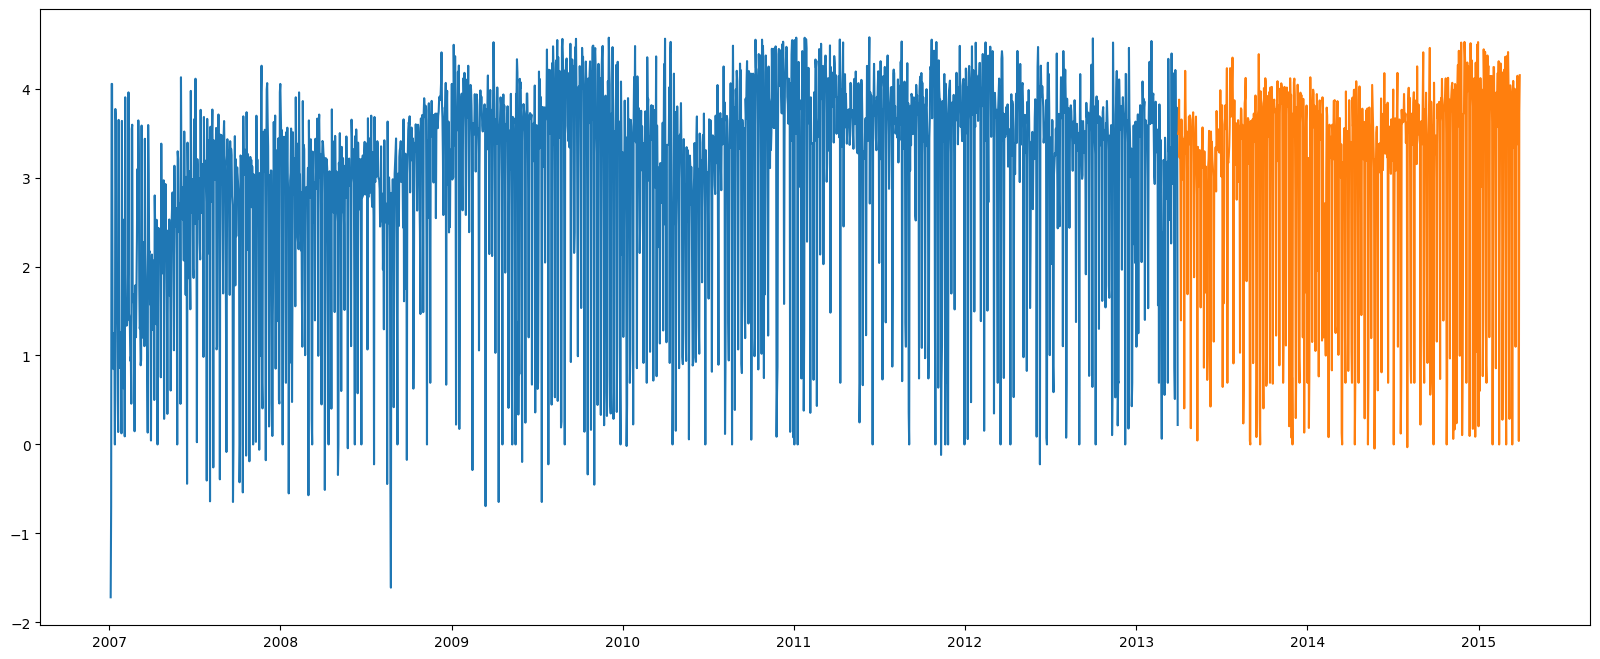

In [363]:
figure(figsize=(20, 8))

plt.plot(logtrain_arima)
plt.plot(logtest_arima)
plt.show()

In [364]:
logtrain_arima


date
2007-01-04   -1.717651
2007-01-05   -0.693147
2007-01-06    4.052480
2007-01-07    4.052480
2007-01-08    1.258955
                ...   
2013-03-26    3.256010
2013-03-27    3.436338
2013-03-28    3.784933
2013-03-29    3.509644
2013-03-30    0.219054
Name: log_ave_days, Length: 2278, dtype: float64

In [365]:
print(logtest_arima.shape[0] - 1)

729


# Arima Models

### Parmaters: order=(0, 1, 0) & seasonal_order=(0, 1, 0, 24)

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



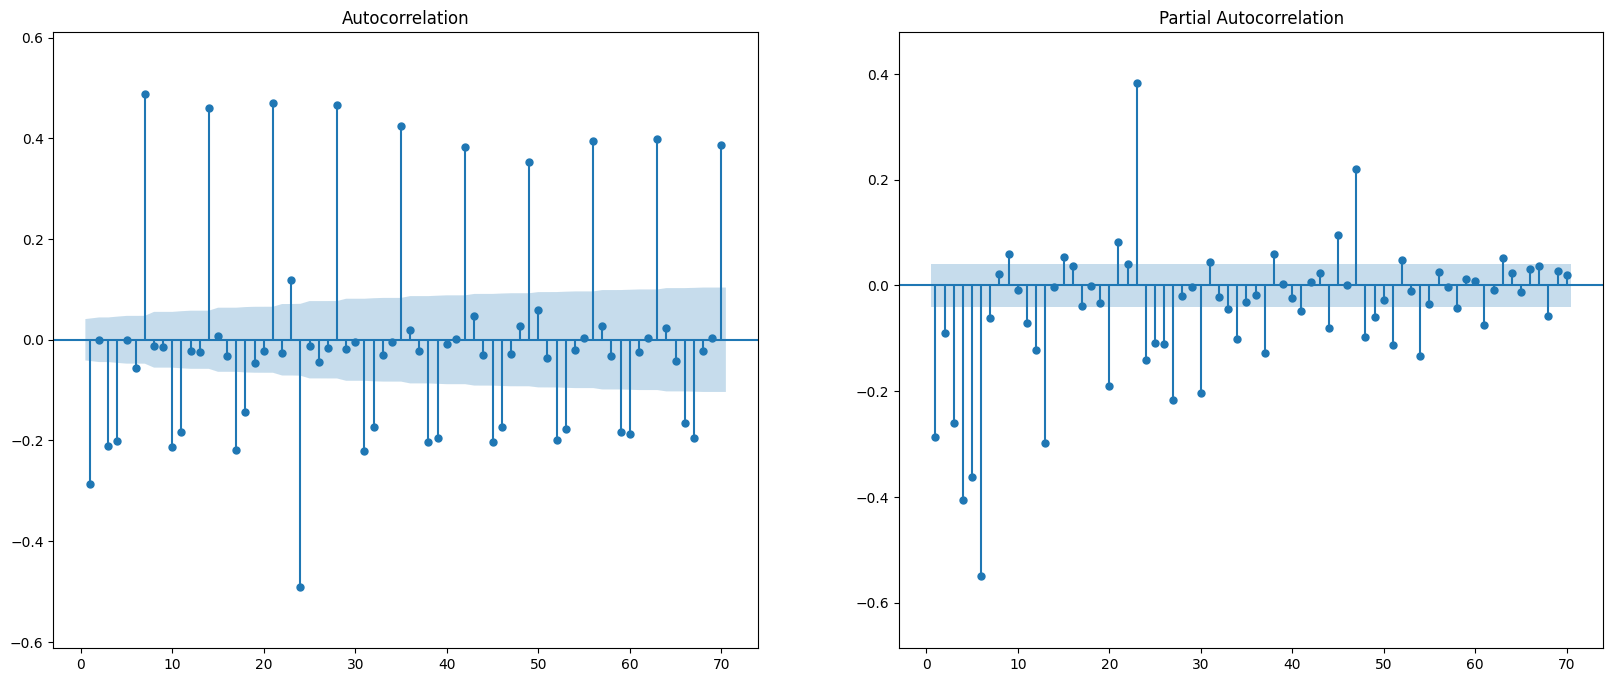

In [366]:
# Model Fit
mod1 = ARIMA(logtrain_arima,
             order=(0, 1, 0),
             seasonal_order=(0, 1, 0, 24))
mod1 = mod1.fit()

# acf pacf
acf_pacf(mod1.resid, 70)


AIC:  9683
MAE:  45


C:\Users\sam\AppData\Local\Temp\ipykernel_8828\228139854.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0.5, 1.0, 'Comparison between predicted_mean and ave_days')

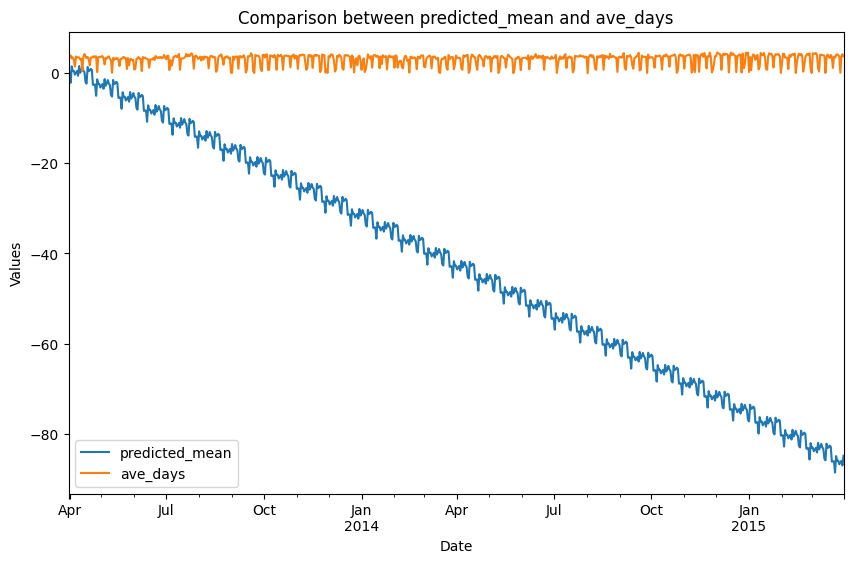

In [58]:
aic1 = mod1.aic
prediction01= mod1.get_prediction(start=logtest_arima.index[0], end=logtest_arima.index[-1]).predicted_mean
prediction01 = pd.Series(prediction01, index=logtest_arima.index)
calculate_mae(prediction01,logtest_arima)
mae = calculate_mae(logtest_arima,prediction01)
#mape=calculate_mape(logtest_arima.avg_,prediction01)
print('AIC: ', int(aic1))
print('MAE: ', int(mae))

concatenated_df = pd.concat([prediction01.to_frame(), logtest_arima], axis=1)

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')



                                    SARIMAX Results                                     
Dep. Variable:                         ave_days   No. Observations:                 2278
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 24)   Log Likelihood               -4840.769
Date:                          Sun, 18 Feb 2024   AIC                           9683.537
Time:                                  21:11:37   BIC                           9689.257
Sample:                              01-04-2007   HQIC                          9685.625
                                   - 03-30-2013                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.3029      0.131     32.896      0.000       4.047       4.559
Ljung-Box (L1) (Q):                 184.04   Jarque

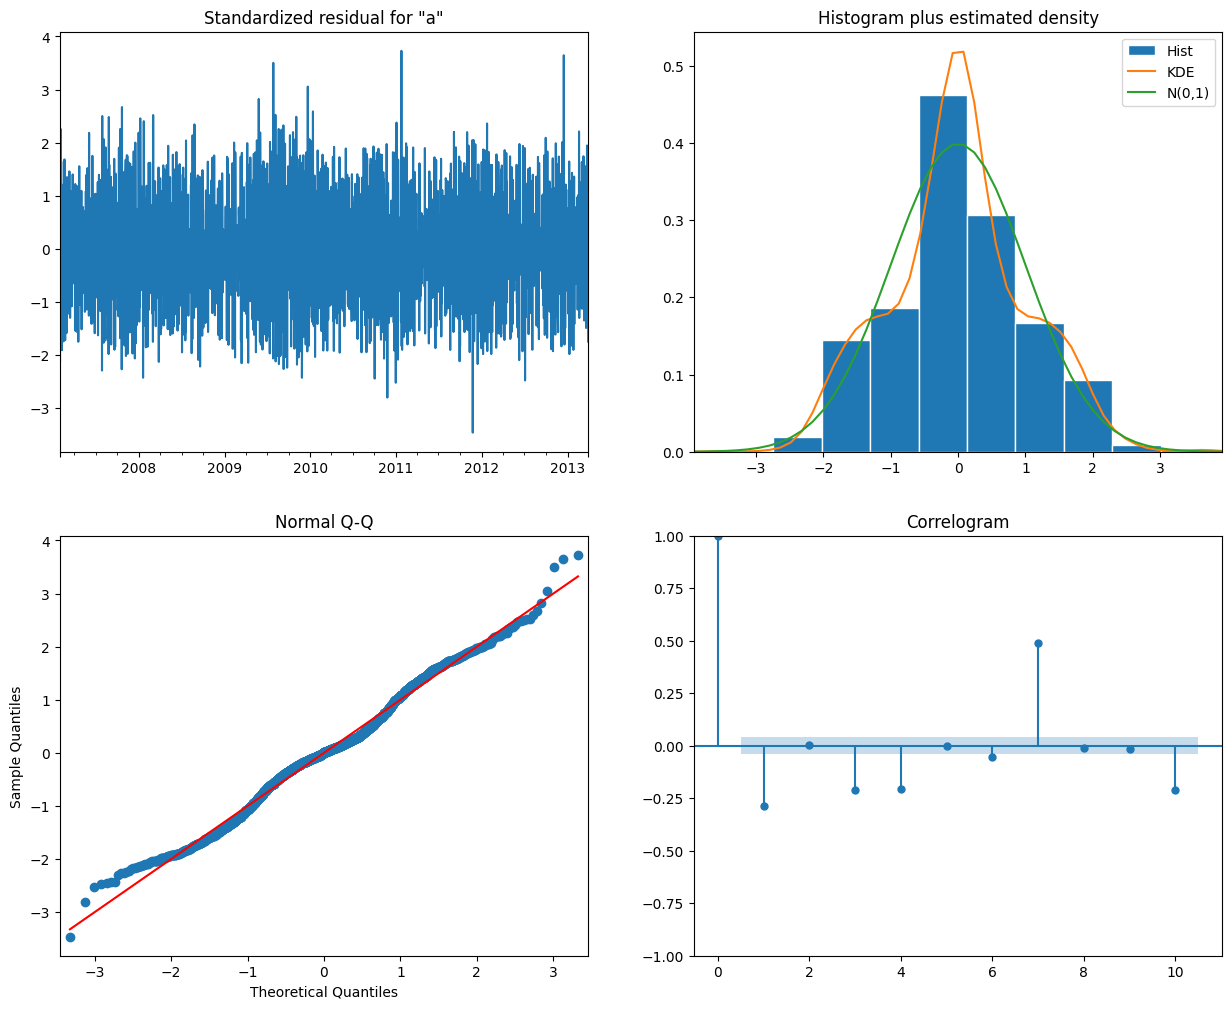

In [59]:
# Print model summary and diagnostics
print(mod1.summary())
mod1.plot_diagnostics(figsize=(15, 12))
plt.show()

del mod1
del prediction01
del concatenated_df


### Parmaters: order=(0, 1, 0) & seasonal_order=(0, 1, 0, 7)

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



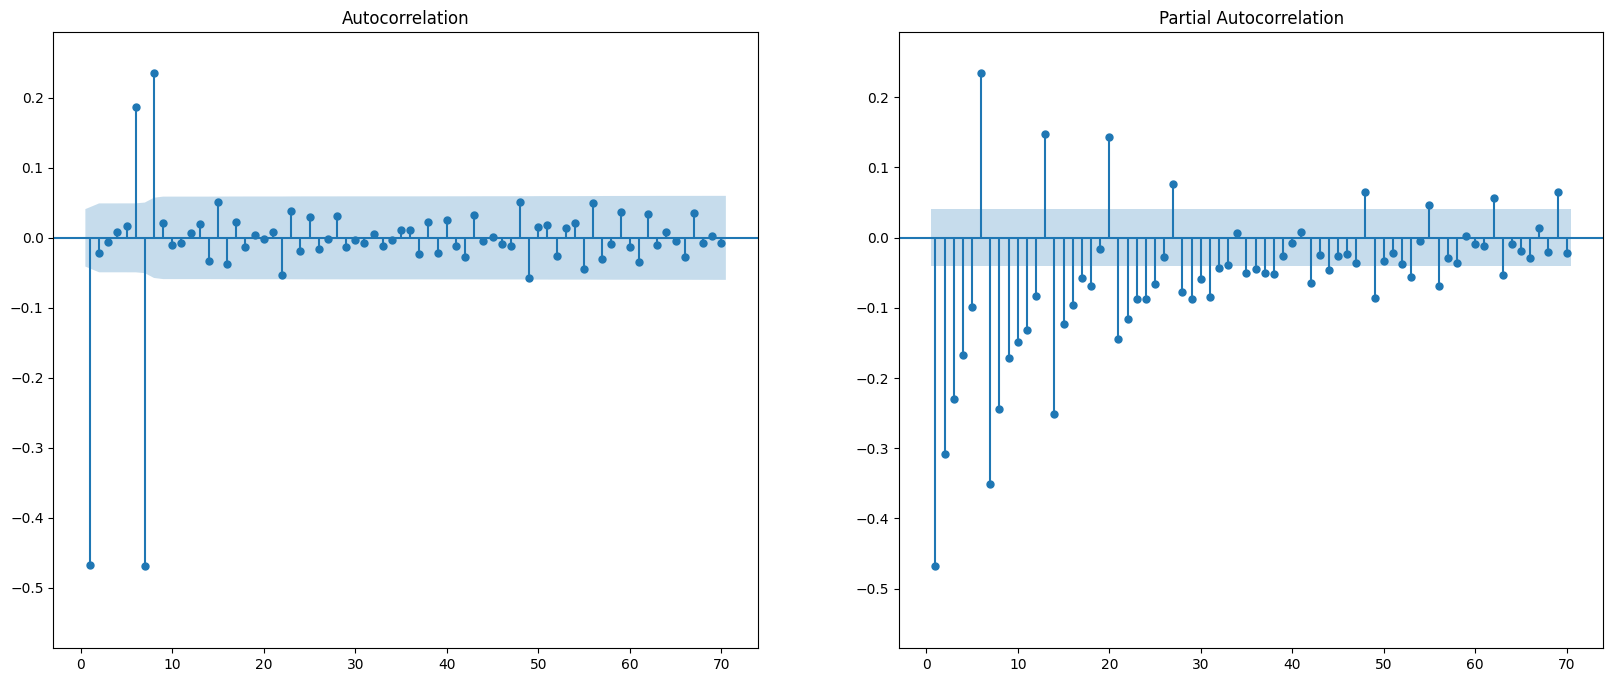

AIC:  8184
MAE:  34


C:\Users\sam\AppData\Local\Temp\ipykernel_31632\228139854.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0.5, 1.0, 'Comparison between predicted_mean and ave_days')

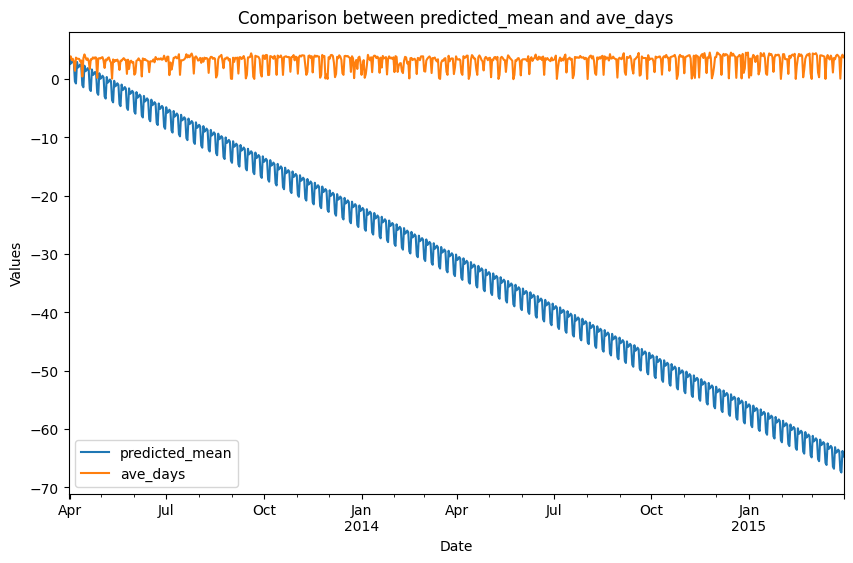

In [76]:
# fit modello
mod1 = ARIMA(logtrain_arima,
             order=(0, 1, 0),
             seasonal_order=(0, 1, 0, 7))
mod1 = mod1.fit()

# acf pacf
acf_pacf(mod1.resid, 70)

# valutazione perfomance
aic1 = mod1.aic
prediction01= mod1.get_prediction(start=logtest_arima.index[0], end=logtest_arima.index[-1]).predicted_mean
prediction01 = pd.Series(prediction01, index=logtest_arima.index)
mae = calculate_mae(logtest_arima,prediction01)
print('AIC: ', int(aic1))
print('MAE: ', int(mae))

concatenated_df = pd.concat([prediction01.to_frame(), logtest_arima], axis=1)

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')



                                    SARIMAX Results                                    
Dep. Variable:                        ave_days   No. Observations:                 2278
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood               -4091.127
Date:                         Sat, 17 Feb 2024   AIC                           8184.254
Time:                                 23:42:39   BIC                           8189.982
Sample:                             01-04-2007   HQIC                          8186.344
                                  - 03-30-2013                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.1525      0.041     52.007      0.000       2.071       2.234
Ljung-Box (L1) (Q):                 506.31   Jarque-Bera (J

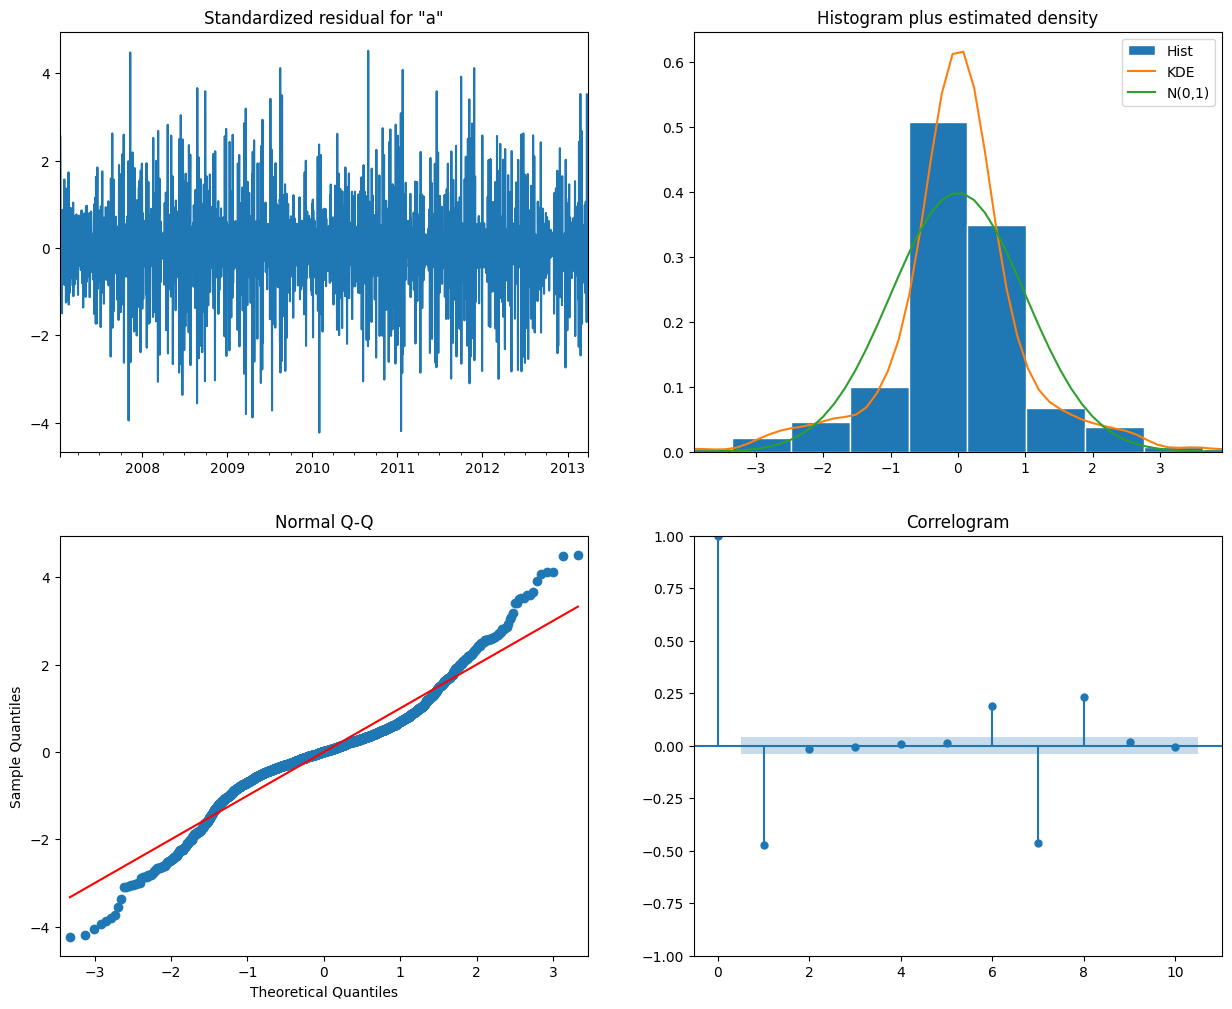

In [77]:
# Print model summary and diagnostics
print(mod1.summary())
mod1.plot_diagnostics(figsize=(15, 12))
plt.show()

del mod1
del concatenated_df

### Parmaters: order=(0, 1, 0) & seasonal_order=(0, 1, 1, 7)

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



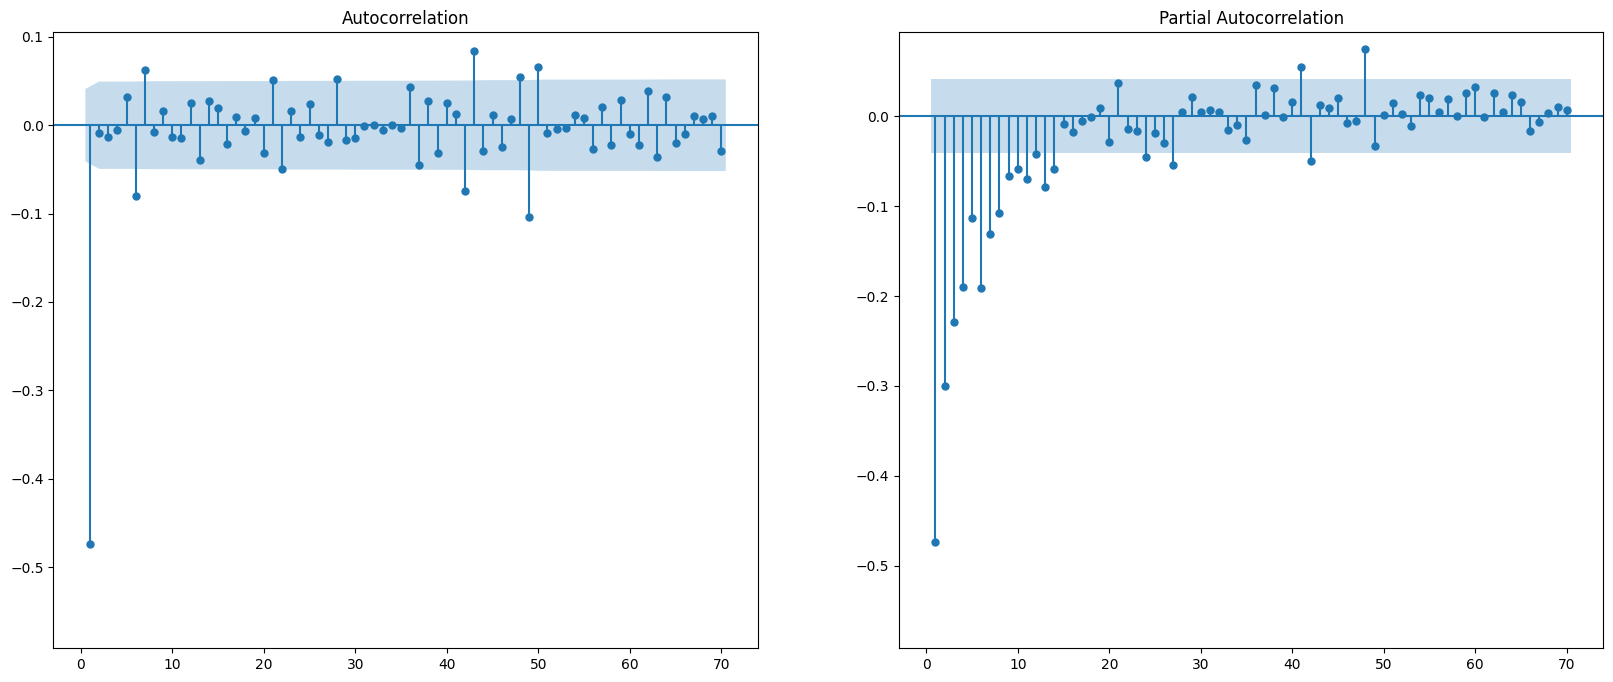

AIC:  7053
MAE:  8


C:\Users\sam\AppData\Local\Temp\ipykernel_31632\228139854.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0.5, 1.0, 'Comparison between predicted_mean and ave_days')

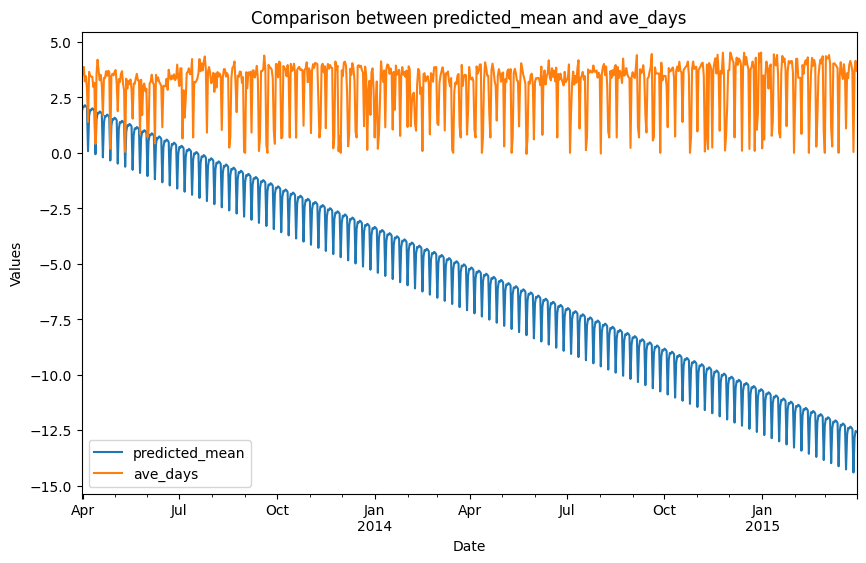

In [78]:
# Git the model
mod2 = ARIMA(logtrain_arima,
             order=(0, 1, 0),
             seasonal_order=(0, 1, 1, 7))
mod2 = mod2.fit()

# acf@pacf
acf_pacf(mod2.resid, 70)


aic1 = mod2.aic
prediction01= mod2.get_prediction(start=logtest_arima.index[0], end=logtest_arima.index[-1]).predicted_mean
prediction01 = pd.Series(prediction01, index=logtest_arima.index)

mae = calculate_mae(prediction01,logtest_arima)
#mape=calculate_mape(logtest_arima.avg_,prediction01)
print('AIC: ', int(aic1))
print('MAE: ', int(mae))

concatenated_df = pd.concat([prediction01.to_frame(), logtest_arima], axis=1)

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')



                                     SARIMAX Results                                     
Dep. Variable:                          ave_days   No. Observations:                 2278
Model:             ARIMA(0, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -3524.702
Date:                           Sat, 17 Feb 2024   AIC                           7053.404
Time:                                   23:42:59   BIC                           7064.859
Sample:                               01-04-2007   HQIC                          7057.583
                                    - 03-30-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8869      0.007   -134.495      0.000      -0.900      -0.874
sigma2         1.3006      0.026     49.778

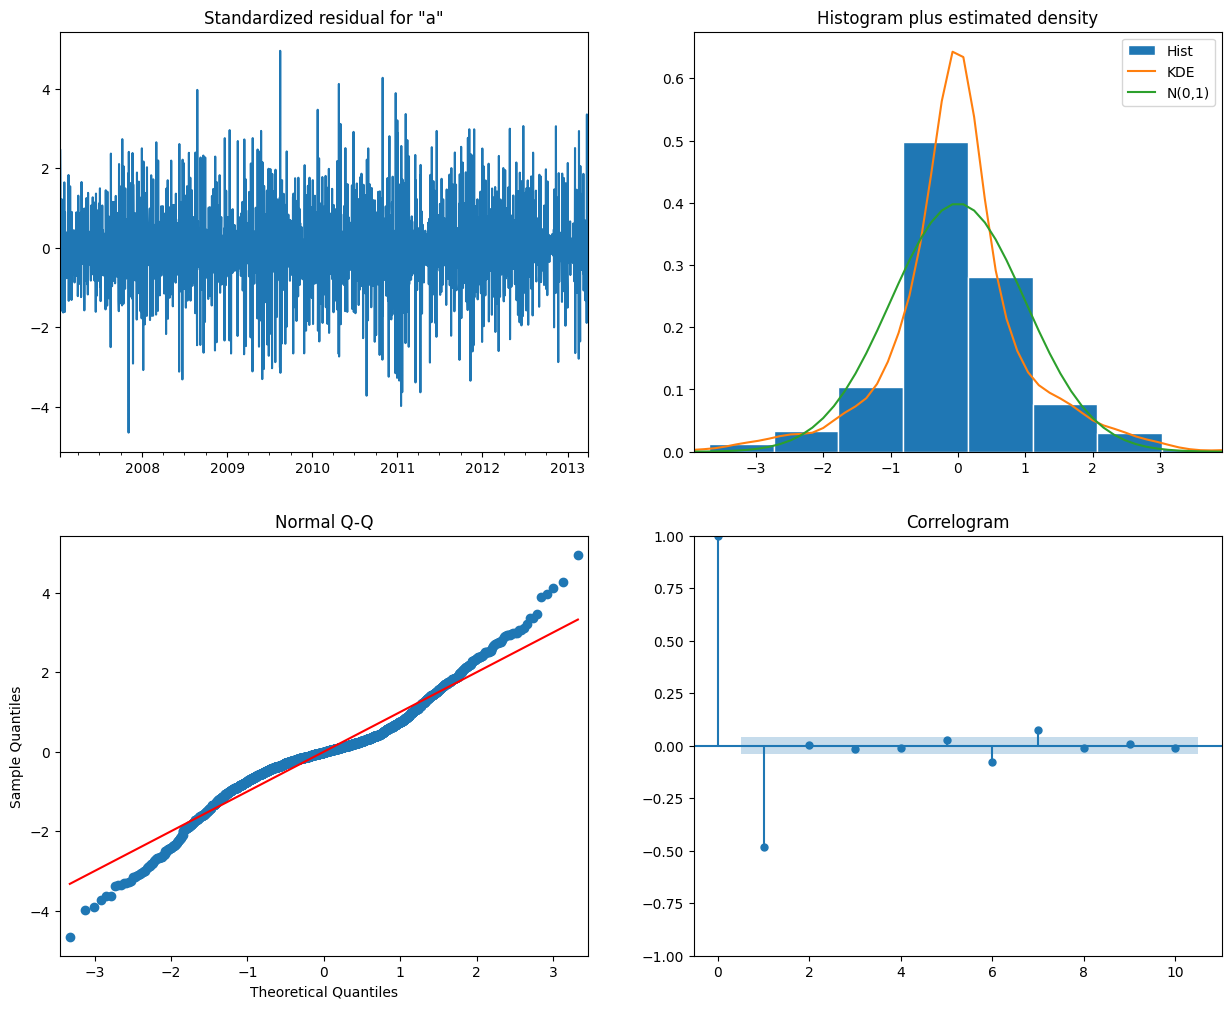

In [79]:
# Print model summary and diagnostics
print(mod2.summary())
mod2.plot_diagnostics(figsize=(15, 12))
plt.show()

del mod2
del prediction01
del mae
del concatenated_df

### Parmaters: order=(0, 1, 0) & seasonal_order=(1, 1, 1, 24)

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



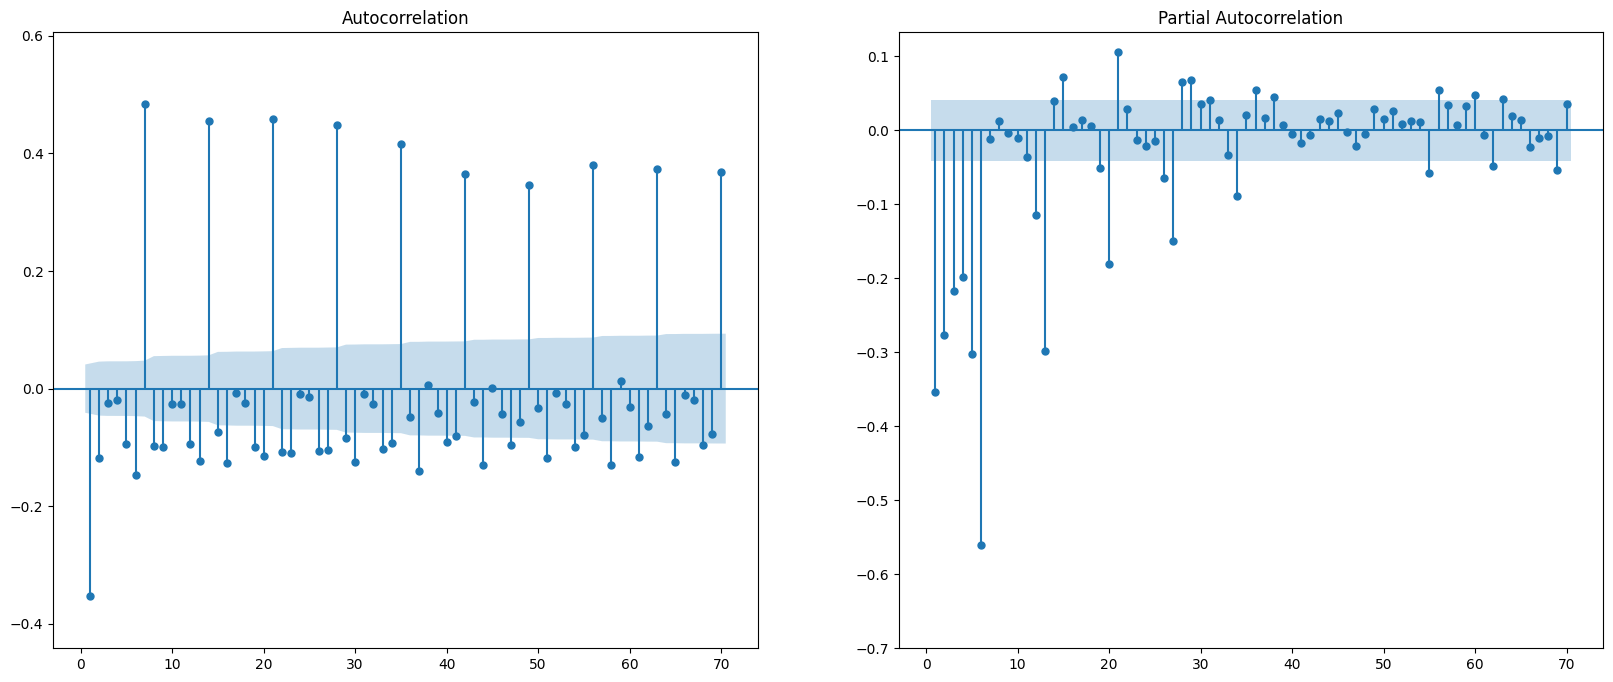

AIC:  8180
MAE:  2


C:\Users\sam\AppData\Local\Temp\ipykernel_31632\228139854.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0.5, 1.0, 'Comparison between predicted_mean and ave_days')

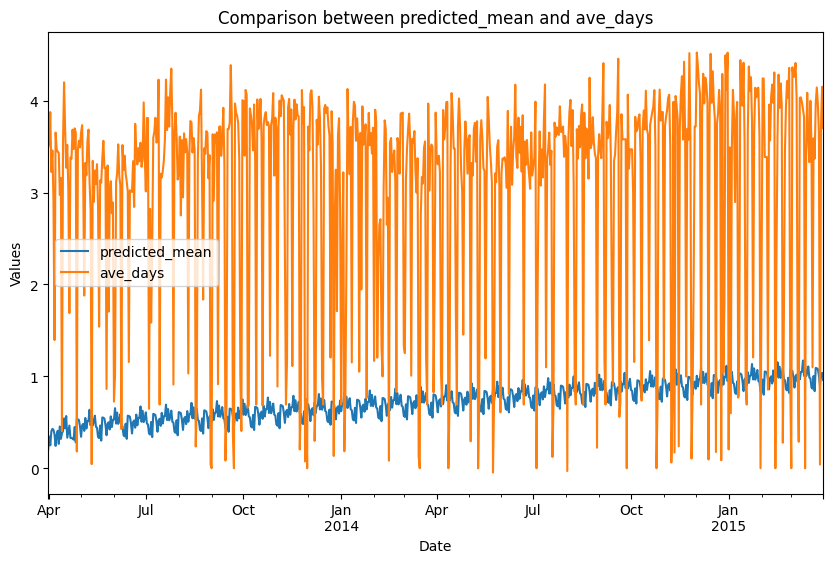

In [80]:
#Fit the model

mod3 = ARIMA(logtrain_arima,
             order=(0, 1, 0),
             seasonal_order=(1, 1, 1, 24))
mod3 = mod3.fit()

# acf pacf
acf_pacf(mod3.resid, 70)



aic1 = mod3.aic
prediction01= mod3.get_prediction(start=logtest_arima.index[0], end=logtest_arima.index[-1]).predicted_mean
prediction01 = pd.Series(prediction01, index=logtest_arima.index)

mae = calculate_mae(prediction01,logtest_arima)
#mape=calculate_mape(logtest_arima.avg_,prediction01)
print('AIC: ', int(aic1))
print('MAE: ', int(mae))

concatenated_df = pd.concat([prediction01.to_frame(), logtest_arima], axis=1)

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')


                                     SARIMAX Results                                      
Dep. Variable:                           ave_days   No. Observations:                 2278
Model:             ARIMA(0, 1, 0)x(1, 1, [1], 24)   Log Likelihood               -4087.055
Date:                            Sat, 17 Feb 2024   AIC                           8180.110
Time:                                    23:43:51   BIC                           8197.270
Sample:                                01-04-2007   HQIC                          8186.373
                                     - 03-30-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24      -0.0295      0.036     -0.822      0.411      -0.100       0.041
ma.S.L24      -0.9998      0.798   

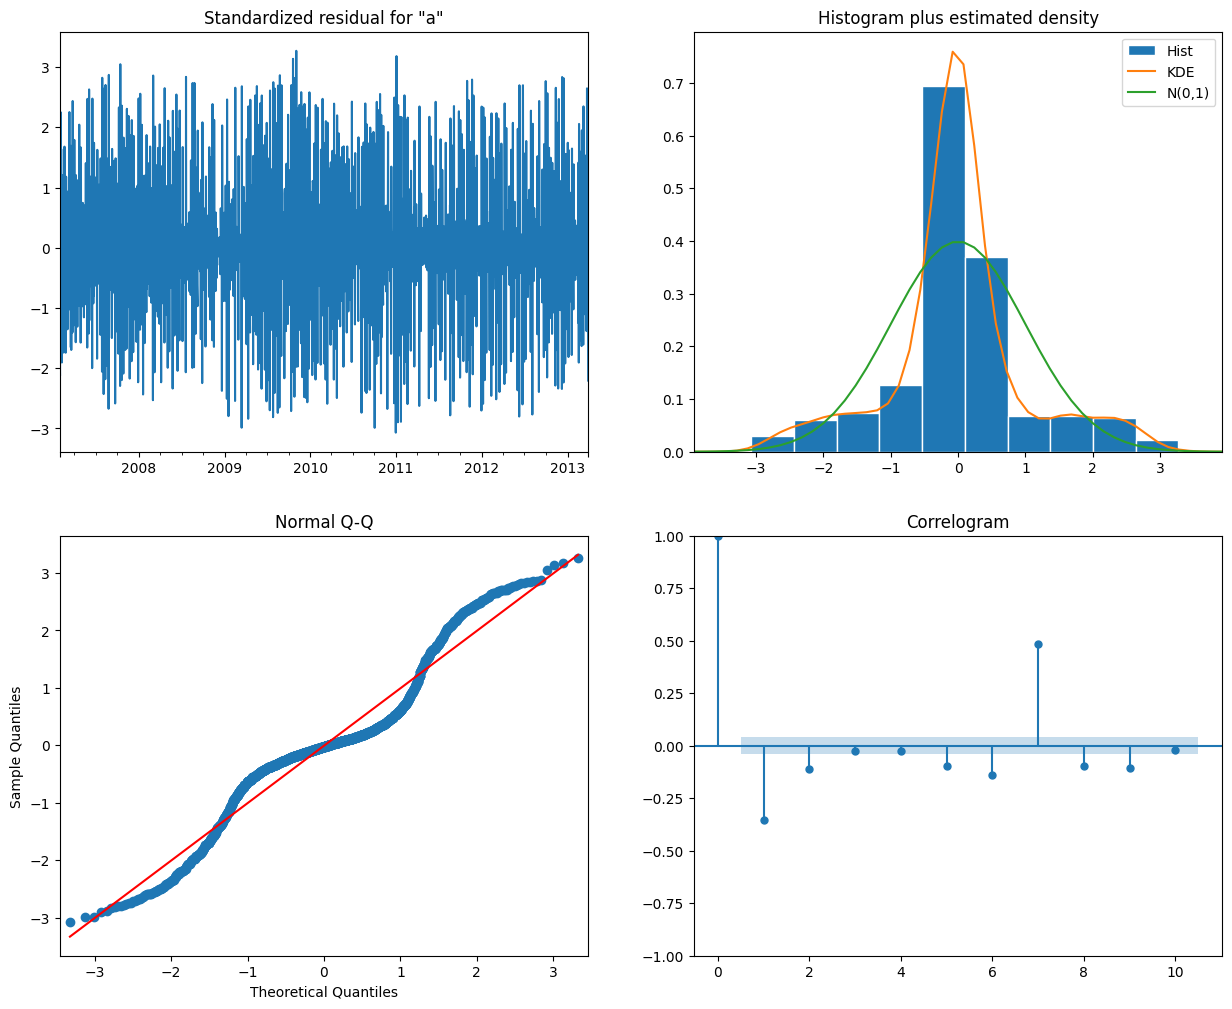

In [81]:
# Print model summary and diagnostics
print(mod3.summary())
mod3.plot_diagnostics(figsize=(15, 12))
plt.show()

del mod3
del concatenated_df

## Hyperparameter Tuning

In [ ]:
# # Run this only once
# # you can the results below

# import time
# import datetime
# from tqdm import tqdm_notebook

# best_logL = -999999
# start = time.time()

# for i in tqdm_notebook(range(7)):
#     for j in range(7):
#         mod3 = ARIMA(logtrain_arima, order=(i, 1, j), seasonal_order=(1, 1, 1, 7))
#         mod3 = mod3.fit()
#         logL = mod3.llf
#         if logL >= best_logL:
#             best_logL = logL
#             params = (i, j)
#         print('AR {} -- MA {},  Log-Likelihood: {}, Best Log-Likelihood: {}, (ARMA {})'.format(i, j, round(logL, 2), round(best_logL, 2), params))

# stop = time.time()
# print('###############################################################')
# print('Execution Time: {}'.format(str(datetime.timedelta(seconds=round(stop-start, 2)))))
# print('Best AR {} -- MA {}, with Log-Likelihood: {}'.format(params[0], params[1], best_logL))


# # AR 6 -- MA 6,  Log-Likelihood: -3002.47, Best Log-Likelihood: -2999.76, (ARMA (6, 5))
# ###############################################################
# # Execution Time: 0:42:41.690000
# # Best AR 6 -- MA 5, with Log-Likelihood: -2999.756922108495
# #
# # the goal of hyperparameter tuning is to find the combination of parameters that maximizes
# # the log-likelihood, as this signifies the best-fitting model. By optimizing the log-likelihood, we aim
# # to improve the model's performance in making accurate predictions on new, unseen data.

<ipython-input-113-1b51fe110545>:11: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 0 -- MA 0,  Log-Likelihood: -3511.1, Best Log-Likelihood: -3511.1, (ARMA (0, 0))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 0 -- MA 1,  Log-Likelihood: -2830.25, Best Log-Likelihood: -2830.25, (ARMA (0, 1))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 0 -- MA 2,  Log-Likelihood: -2825.88, Best Log-Likelihood: -2825.88, (ARMA (0, 2))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 0 -- MA 3,  Log-Likelihood: -2824.78, Best Log-Likelihood: -2824.78, (ARMA (0, 3))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 0 -- MA 4,  Log-Likelihood: -2824.71, Best Log-Likelihood: -2824.71, (ARMA (0, 4))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 0 -- MA 5,  Log-Likelihood: -2824.62, Best Log-Likelihood: -2824.62, (ARMA (0, 5))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 0 -- MA 6,  Log-Likelihood: -2824.46, Best Log-Likelihood: -2824.46, (ARMA (0, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 1 -- MA 0,  Log-Likelihood: -3213.32, Best Log-Likelihood: -2824.46, (ARMA (0, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 1 -- MA 1,  Log-Likelihood: -2825.6, Best Log-Likelihood: -2824.46, (ARMA (0, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



AR 1 -- MA 2,  Log-Likelihood: -2824.7, Best Log-Likelihood: -2824.46, (ARMA (0, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 1 -- MA 3,  Log-Likelihood: -2825.87, Best Log-Likelihood: -2824.46, (ARMA (0, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 1 -- MA 4,  Log-Likelihood: -2824.6, Best Log-Likelihood: -2824.46, (ARMA (0, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 1 -- MA 5,  Log-Likelihood: -2824.6, Best Log-Likelihood: -2824.46, (ARMA (0, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 1 -- MA 6,  Log-Likelihood: -2823.97, Best Log-Likelihood: -2823.97, (ARMA (1, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 2 -- MA 0,  Log-Likelihood: -3101.82, Best Log-Likelihood: -2823.97, (ARMA (1, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 2 -- MA 1,  Log-Likelihood: -2824.71, Best Log-Likelihood: -2823.97, (ARMA (1, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood opt

AR 2 -- MA 2,  Log-Likelihood: -2824.66, Best Log-Likelihood: -2823.97, (ARMA (1, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 2 -- MA 3,  Log-Likelihood: -2826.51, Best Log-Likelihood: -2823.97, (ARMA (1, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 2 -- MA 4,  Log-Likelihood: -2824.35, Best Log-Likelihood: -2823.97, (ARMA (1, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 2 -- MA 5,  Log-Likelihood: -2824.3, Best Log-Likelihood: -2823.97, (ARMA (1, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 2 -- MA 6,  Log-Likelihood: -2823.71, Best Log-Likelihood: -2823.71, (ARMA (2, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 3 -- MA 0,  Log-Likelihood: -3038.08, Best Log-Likelihood: -2823.71, (ARMA (2, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 3 -- MA 1,  Log-Likelihood: -2824.68, Best Log-Likelihood: -2823.71, (ARMA (2, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



AR 3 -- MA 2,  Log-Likelihood: -2824.54, Best Log-Likelihood: -2823.71, (ARMA (2, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 3 -- MA 3,  Log-Likelihood: -2824.22, Best Log-Likelihood: -2823.71, (ARMA (2, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 3 -- MA 4,  Log-Likelihood: -2821.51, Best Log-Likelihood: -2821.51, (ARMA (3, 4))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 3 -- MA 5,  Log-Likelihood: -2820.61, Best Log-Likelihood: -2820.61, (ARMA (3, 5))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 3 -- MA 6,  Log-Likelihood: -2818.77, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 4 -- MA 0,  Log-Likelihood: -2996.83, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 4 -- MA 1,  Log-Likelihood: -2824.64, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



AR 4 -- MA 2,  Log-Likelihood: -2824.54, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 4 -- MA 3,  Log-Likelihood: -2823.66, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 4 -- MA 4,  Log-Likelihood: -2820.11, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 4 -- MA 5,  Log-Likelihood: -2819.81, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 4 -- MA 6,  Log-Likelihood: -2822.01, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 5 -- MA 0,  Log-Likelihood: -2979.83, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 5 -- MA 1,  Log-Likelihood: -2824.61, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



AR 5 -- MA 2,  Log-Likelihood: -2824.14, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 5 -- MA 3,  Log-Likelihood: -2824.33, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 5 -- MA 4,  Log-Likelihood: -2820.78, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 5 -- MA 5,  Log-Likelihood: -2820.56, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 5 -- MA 6,  Log-Likelihood: -2821.77, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 6 -- MA 0,  Log-Likelihood: -2861.2, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



AR 6 -- MA 1,  Log-Likelihood: -2822.82, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 6 -- MA 2,  Log-Likelihood: -2822.83, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood opt

AR 6 -- MA 3,  Log-Likelihood: -2823.22, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood opt

AR 6 -- MA 4,  Log-Likelihood: -2822.93, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 6 -- MA 5,  Log-Likelihood: -2822.51, Best Log-Likelihood: -2818.77, (ARMA (3, 6))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



AR 6 -- MA 6,  Log-Likelihood: -2817.72, Best Log-Likelihood: -2817.72, (ARMA (6, 6))
###############################################################
Execution Time: 0:05:57.360000
Best AR 6 -- MA 6, with Log-Likelihood: -2817.7179787689593


In [ ]:
## Dont Run this


# import time
# import datetime
# import numpy as np
# from tqdm.notebook import tqdm as tqdm_notebook

# from statsmodels.tsa.arima.model import ARIMA

# best_aic = np.inf
# best_bic = np.inf
# start = time.time()

# for p in tqdm_notebook(range(7)):
#     for d in range(3):  # You can adjust this range based on your preference
#         for q in range(7):
#             for P in range(3):  # You can adjust this range based on your preference
#                 for D in range(3):  # You can adjust this range based on your preference
#                     for Q in range(3):  # You can adjust this range based on your preference
#                         try:
#                             mod = ARIMA(logtrain_arima, order=(p, d, q), seasonal_order=(P, D, Q, 24))
#                             mod = mod.fit()
#                             aic = mod.aic
#                             bic = mod.bic
#                             if aic < best_aic:
#                                 best_aic = aic
#                                 best_aic_params = (p, d, q, P, D, Q)
#                             if bic < best_bic:
#                                 best_bic = bic
#                                 best_bic_params = (p, d, q, P, D, Q)
#                             print(f"AIC for p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}: {aic}, Best AIC so far: {best_aic}, Best AIC params: {best_aic_params}")
#                             print(f"BIC for p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}: {bic}, Best BIC so far: {best_bic}, Best BIC params: {best_bic_params}")
#                         except:
#                             print(f"Error occurred for p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}")

# stop = time.time()
# print('###############################################################')
# print('Execution Time: {}'.format(str(datetime.timedelta(seconds=round(stop-start, 2)))))
# print('Best AIC parameters (p, d, q, P, D, Q):', best_aic_params, 'with AIC:', best_aic)
# print('Best BIC parameters (p, d, q, P, D, Q):', best_bic_params, 'with BIC:', best_bic)


### Following hyperparameter tuning using a grid search, we investigated potential improvements in the seasonal order of the model. While adjusting these parameters, we observed a significant decrease in the AIC score, indicating a potentially more robust model.

In [ ]:
## Forecasts from 2015-04-01 through 2015-11-07

In [ ]:
# from sklearn.model_selection import ParameterGrid
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Define parameter grid
# param_grid = {
#     'period': [24, 48, 72],  # Candidate periods
#     'fourier': [2, 3, 4]      # Candidate number of Fourier terms
# }

# best_score = np.inf  # Initialize best score

# # Iterate over all parameter combinations
# for params in ParameterGrid(param_grid):
#     # Fit model with current parameters
#     all_df = DeterministicProcess(logtrain_arima.index, period=params['period'], fourier=params['fourier'])
#     all_df = all_df.in_sample()

#     # Split data into train and validation sets (adjust this according to your data)
#     train_end = '2015-03-31'
#     valid_start =  logtest_arima.index.min()
#     valid_end = logtest_arima.index.max()

#     # Filter the data for training and validation
#     exog_train = all_df[all_df.index <= train_end]
#     valid_data = logtest_arima[(logtest_arima.index >= valid_start)]
#     valid_data  = logtest_arima[(logtest_arima.index <= valid_end)]


#     mod00 = ARIMA(all_one,
#             order=(6, 1, 5),
#             seasonal_order=(0, 1, 0, 24),
#             exog=exgo_train)

#     mod00 = mod00.fit()
#     pred = mod00.get_prediction(starta=valid_data.index[0], end=valid_data.index[-1], exog=exgo_pred).predicted_mean

#     mse = mean_squared_error(valid_data, pred)
#     # Update best score and best parameters if current parameters perform better
#     if mse < best_score:
#         best_score = mse
#         best_params = params

# # Output best parameters
# print("Best parameters:", best_params)




In [ ]:
# for Forecast

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



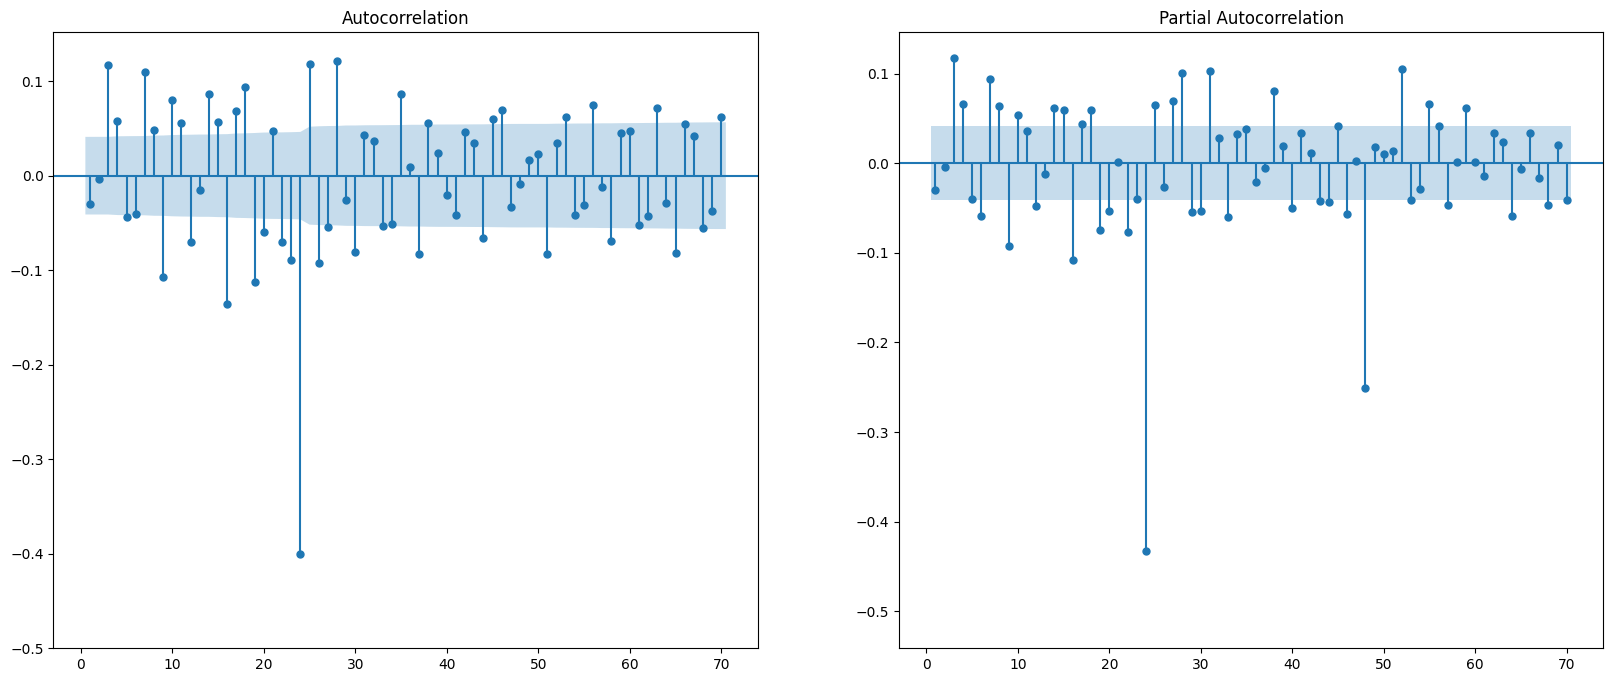

C:\Users\sam\AppData\Local\Temp\ipykernel_31632\228139854.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



AIC:  7313
MAE:  1


Text(0.5, 1.0, 'Comparison between predicted_mean and ave_days')

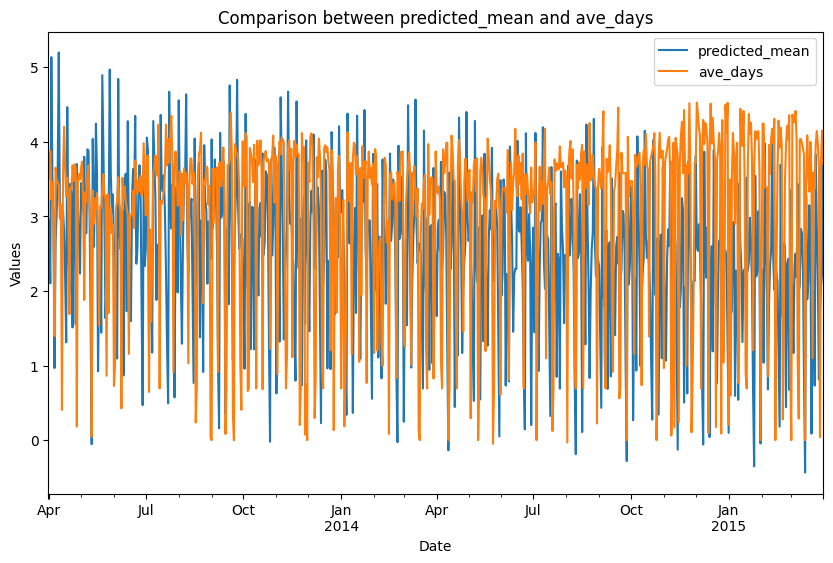

In [82]:
modhypr01 = ARIMA(logtrain_arima,
             order=(6, 1, 5),
             seasonal_order=(0, 1, 0, 24))
modhypr01 = modhypr01.fit()

# acf pacf
acf_pacf(modhypr01.resid, 70)



aic1 = modhypr01.aic
prediction01= modhypr01.get_prediction(start=logtest_arima.index[0], end=logtest_arima.index[-1]).predicted_mean
prediction01 = pd.Series(prediction01, index=logtest_arima.index)

mae = calculate_mae(prediction01,logtest_arima)
#mape=calculate_mape(logtest_arima.avg_,prediction01)
print('AIC: ', int(aic1))
print('MAE: ', int(mae))

concatenated_df = pd.concat([prediction01.to_frame(), logtest_arima], axis=1)

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')



                                     SARIMAX Results                                     
Dep. Variable:                          ave_days   No. Observations:                 2278
Model:             ARIMA(6, 1, 5)x(0, 1, [], 24)   Log Likelihood               -3644.866
Date:                           Sat, 17 Feb 2024   AIC                           7313.732
Time:                                   23:44:37   BIC                           7382.372
Sample:                               01-04-2007   HQIC                          7338.783
                                    - 03-30-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4176      0.027    -15.484      0.000      -0.470      -0.365
ar.L2          0.2274      0.028      8.242

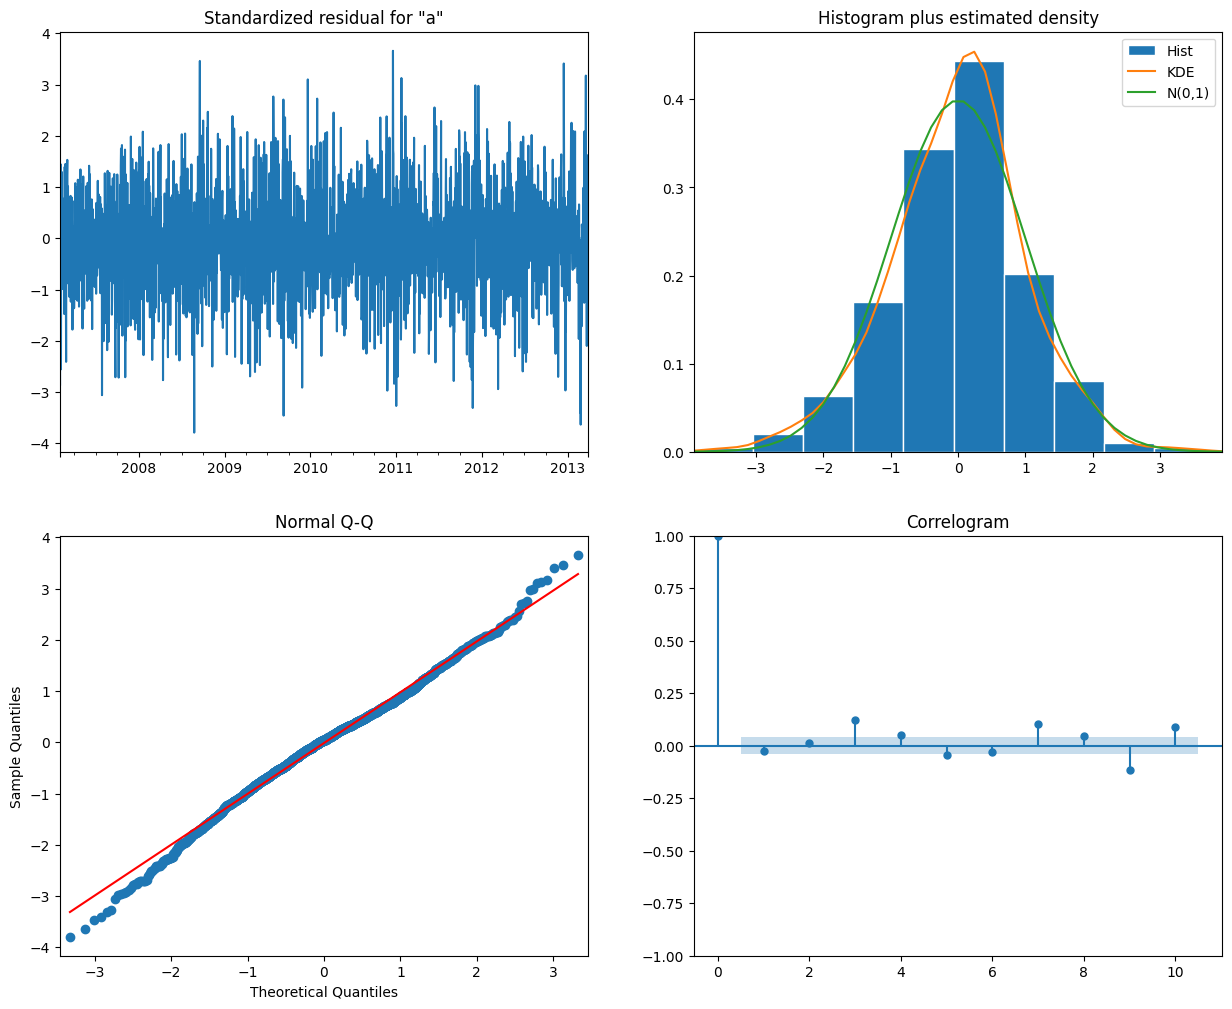

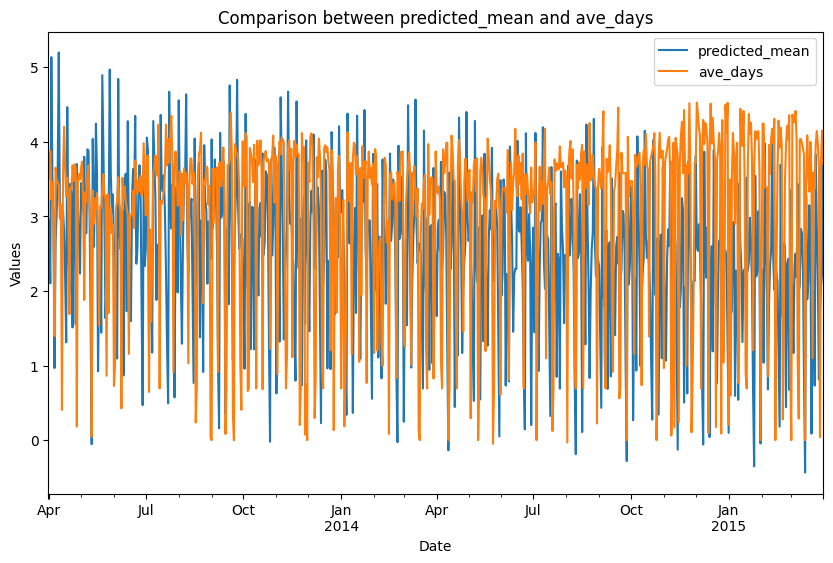

In [83]:
print(modhypr01.summary())
modhypr01.plot_diagnostics(figsize=(15, 12))
plt.show()

concatenated_df = pd.concat([prediction01.to_frame(), logtest_arima], axis=1)

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')


del concatenated_df
del modhypr01
del aic1

In [ ]:
# import numpy as np

# # Filter out rows where log_ave_days is zero
# # non_zero_mask = concatenated_df['log_ave_days'] != 0
# # concatenated_df_filtered = concatenated_df[non_zero_mask]

# # Calculate absolute error and absolute percentage error
# absolute_error = np.abs(concatenated_df_filtered['predicted_mean'] - concatenated_df_filtered['log_ave_days'])
# absolute_percentage_error = (absolute_error / 731*concatenated_df_filtered['log_ave_days'])*100

# # Calculate MAPE
# mape = absolute_percentage_error.mean()

# print('MAPE:', mape)


MAPE: 0.549886191423679


##  order=(6, 1, 5),easonal_order=(0, 1, 1, 24)



c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



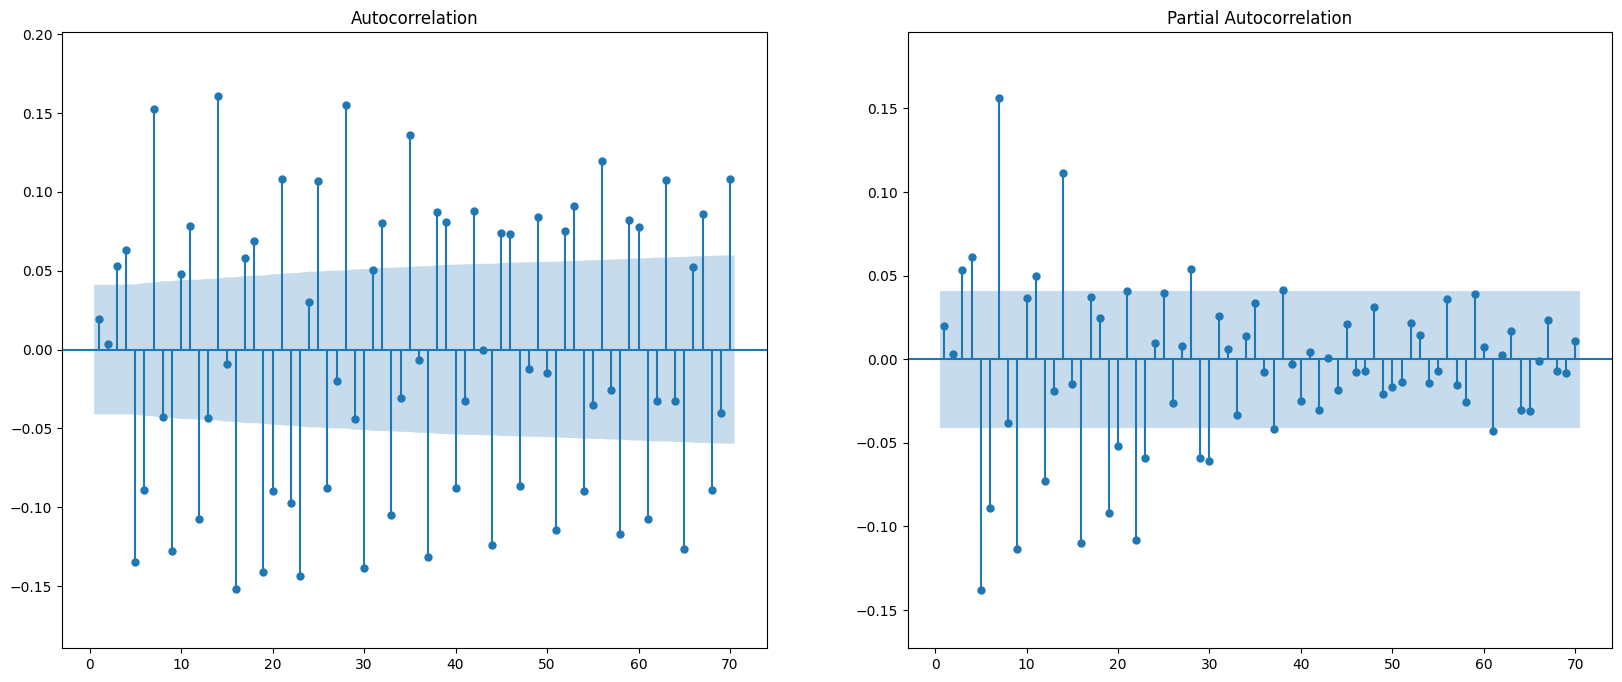

Text(0.5, 1.0, 'Comparison between predicted_mean and ave_days')

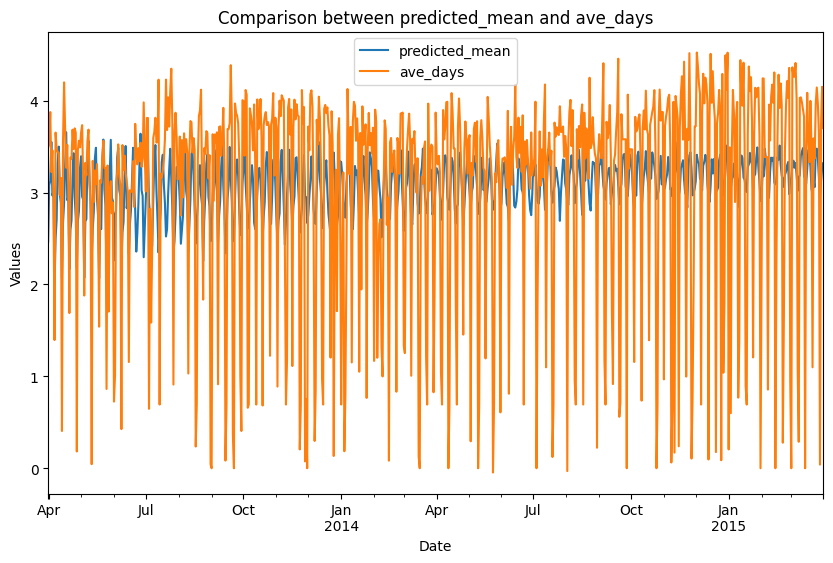

In [84]:
# fit model
modhypr = ARIMA(logtrain_arima,
             order=(6, 1, 5),
             seasonal_order=(0, 1, 1, 24))
modhypr00 = modhypr.fit()

# acf pacf
acf_pacf(modhypr00.resid, 70)



aic1 = modhypr00.aic
prediction01= modhypr00.get_prediction(start=logtest_arima.index[0], end=logtest_arima.index[-1]).predicted_mean
prediction01 = pd.Series(prediction01, index=logtest_arima.index)



residuals = logtest_arima - prediction01
#predhypr = np.exp(predictionhr)


concatenated_df = pd.concat([prediction01.to_frame(), logtest_arima], axis=1)

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')



In [89]:

aic = modhypr00.aic


mae = calculate_mae(prediction01,logtest_arima)
#mape=calculate_mape(logtest_arima.avg_,prediction01)
print('AIC: ', int(aic1))
print('MAE: ', int(mae))



print(modhypr00.summary())
modhypr00.plot_diagnostics(figsize=(15, 12))
plt.show()

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='-')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()





# Assuming 'y_true' is the true target values and 'y_pred' is the predicted values
mae = calculate_mae( concatenated_df['ave_days'],concatenated_df['predicted_mean'] )

print('MAE:', mae)


del modhypr00
del concatenated_df
del prediction01
del aic
del mae

NameError: name 'modhypr00' is not defined

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



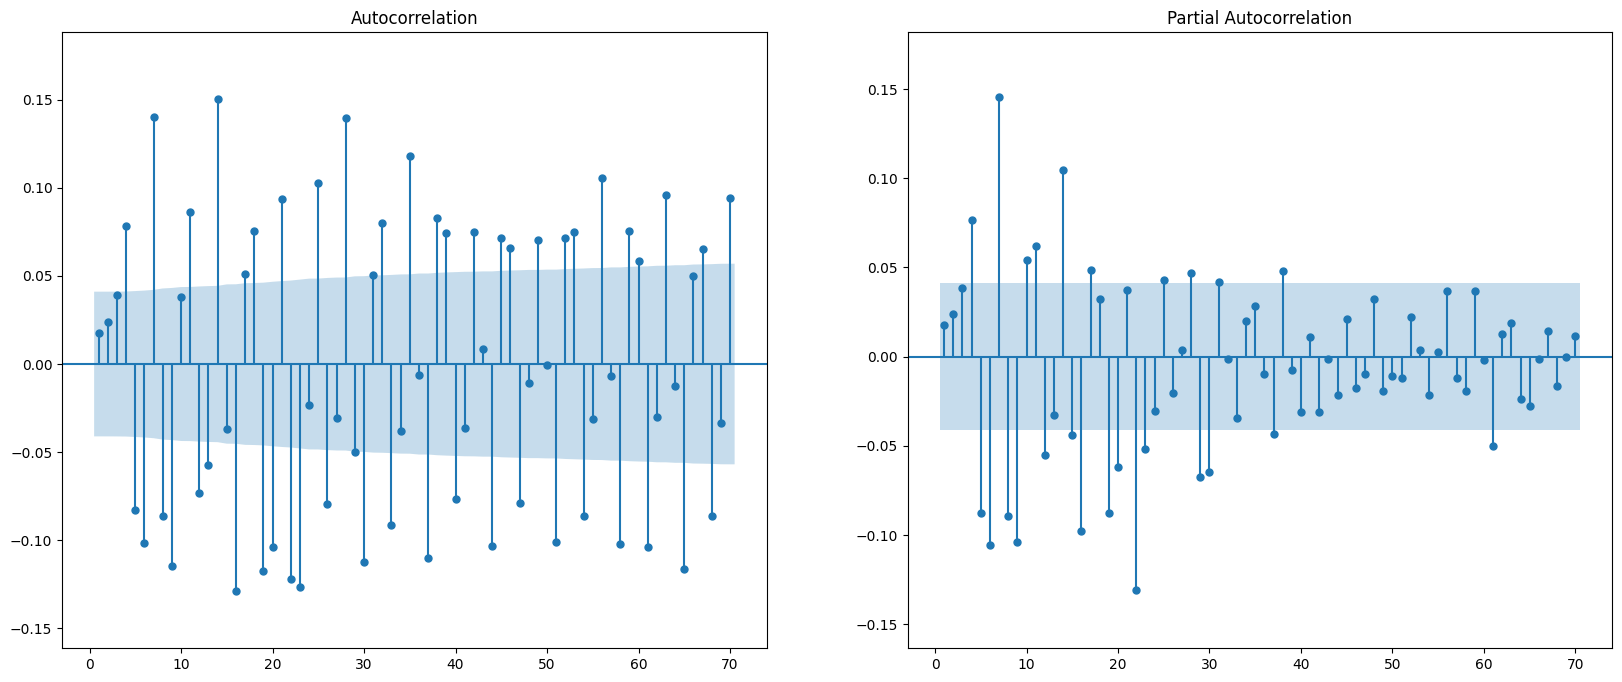

AIC:  6127
                                     SARIMAX Results                                      
Dep. Variable:                           ave_days   No. Observations:                 2278
Model:             ARIMA(6, 1, 5)x(1, 1, [1], 24)   Log Likelihood               -3049.683
Date:                            Sat, 17 Feb 2024   AIC                           6127.365
Time:                                    23:56:53   BIC                           6207.446
Sample:                                01-04-2007   HQIC                          6156.592
                                     - 03-30-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6757      0.024    -28.308      0.000      -0.722      -0.629
ar.L2         -0.0695   

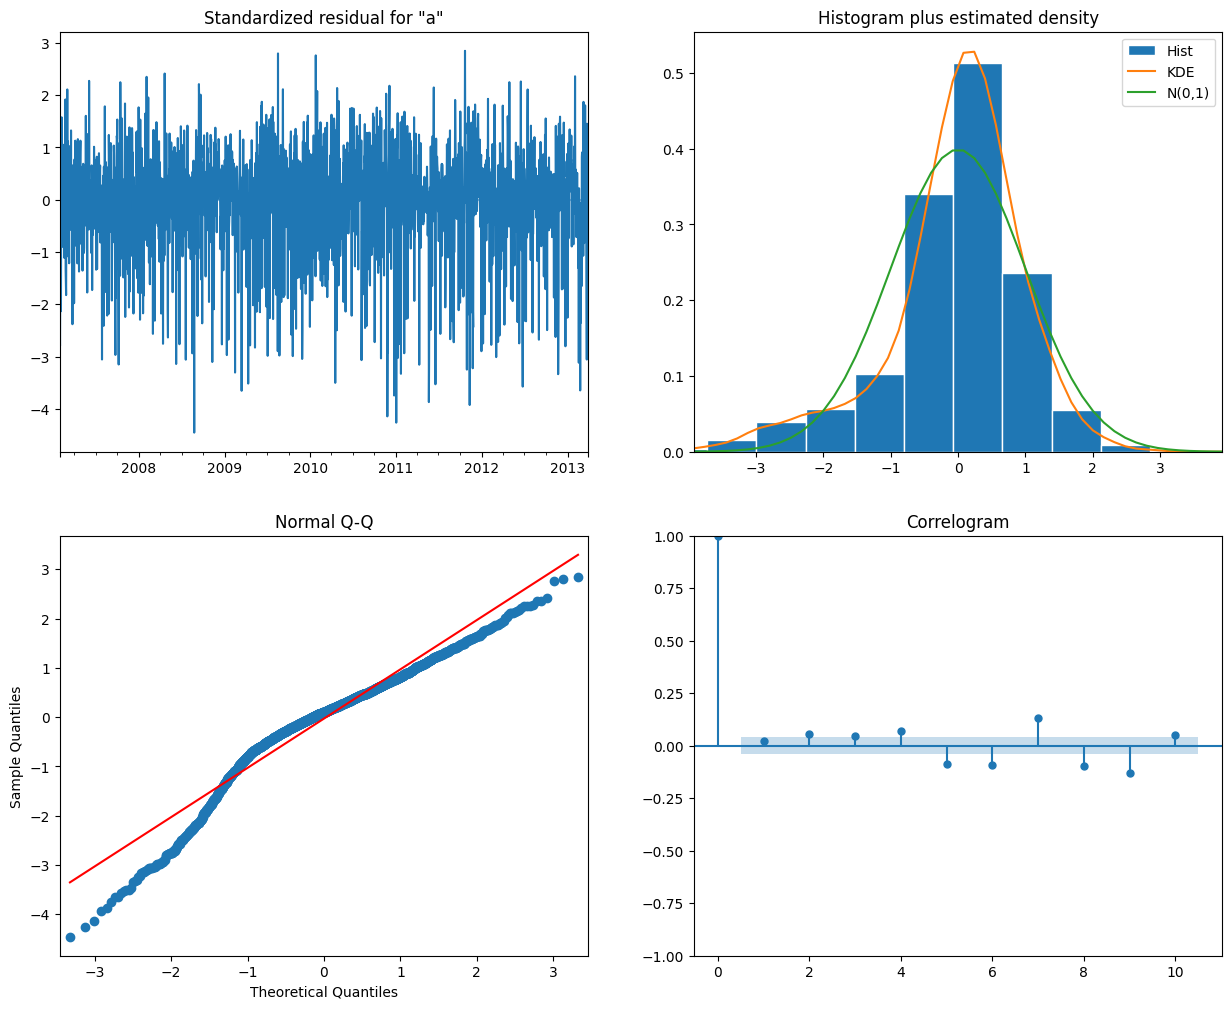

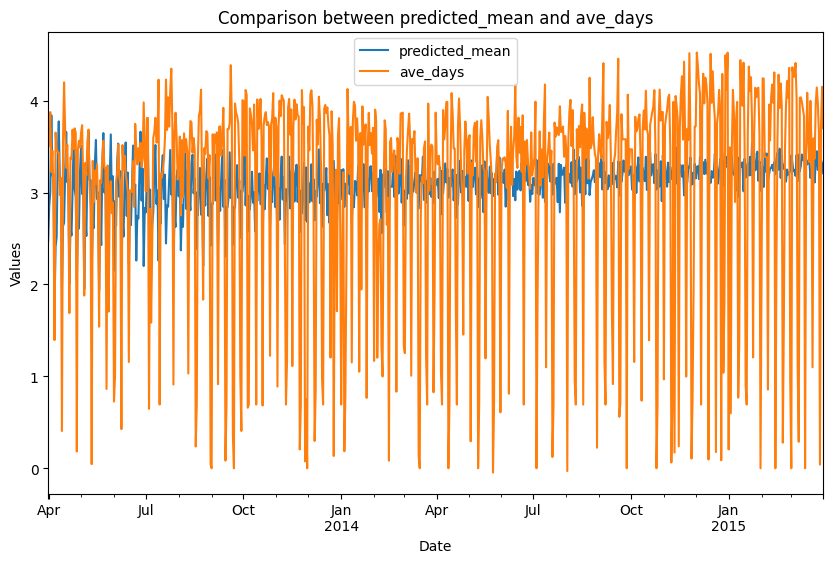

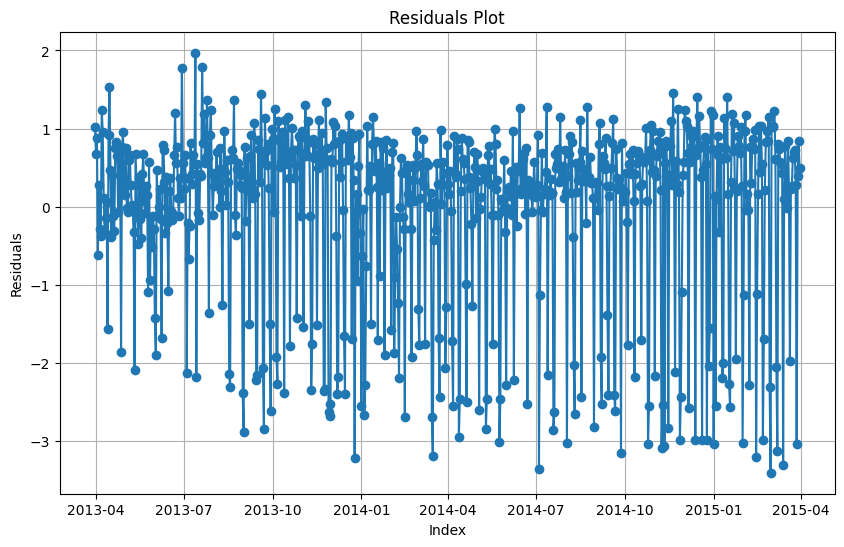

MAE: 0.8625574945887146


In [90]:
# fit model
modhypr = ARIMA(logtrain_arima,
             order=(6, 1, 5),
             seasonal_order=(1, 1, 1, 24))
modhypr = modhypr.fit()

# acf pacf
acf_pacf(modhypr.resid, 70)

predictionhr = modhypr.forecast(steps=len(logtest_arima))  # Get the forecasted values
predictionhr = pd.Series(predictionhr, index=logtest_arima.index)
residuals = logtest_arima - predictionhr
#predhypr = np.exp(predictionhr)





aichypr = modhypr.aic
#mapehypr1 = mape(logtest_arima, predictionhr)
print('AIC: ', int(aichypr))
#

print(modhypr.summary())
modhypr.plot_diagnostics(figsize=(15, 12))
plt.show()


concatenated_df = pd.concat([predictionhr.to_frame(), logtest_arima], axis=1)

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='-')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()




# Assuming 'y_true' is the true target values and 'y_pred' is the predicted values
mae = mean_absolute_error( concatenated_df['ave_days'],concatenated_df['predicted_mean'] )

print('MAE:', mae)


del modhypr
del concatenated_df
del predictionhr
del aichypr

In [91]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Assuming logtrain_arima contains your time series data
# Compute autocorrelation function (ACF)
acf_values, confidence_intervals = acf(df.ave_days, alpha=0.05)

# Sort autocorrelation values in descending order
sorted_indices = np.argsort(acf_values)[::-1]
top_three_indices = sorted_indices[:5]

# Extract lags and autocorrelation values of top three peaks
top_three_lags = [i for i in top_three_indices]
top_three_heights = [acf_values[i] for i in top_three_indices]

# Print the lags and heights of the top three peaks
for i in range(5):
    print(f"Peak {i+1}: Lag {top_three_lags[i]}, Height {top_three_heights[i]}")


Peak 1: Lag 0, Height 1.0
Peak 2: Lag 7, Height 0.5361277862697058
Peak 3: Lag 14, Height 0.5125735965270222
Peak 4: Lag 28, Height 0.5032922923101146
Peak 5: Lag 21, Height 0.4886336564363595


### Parmaters: order=(0, 1, 0) & seasonal_order=seasonal_order=(1,1,1,14)

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters fou

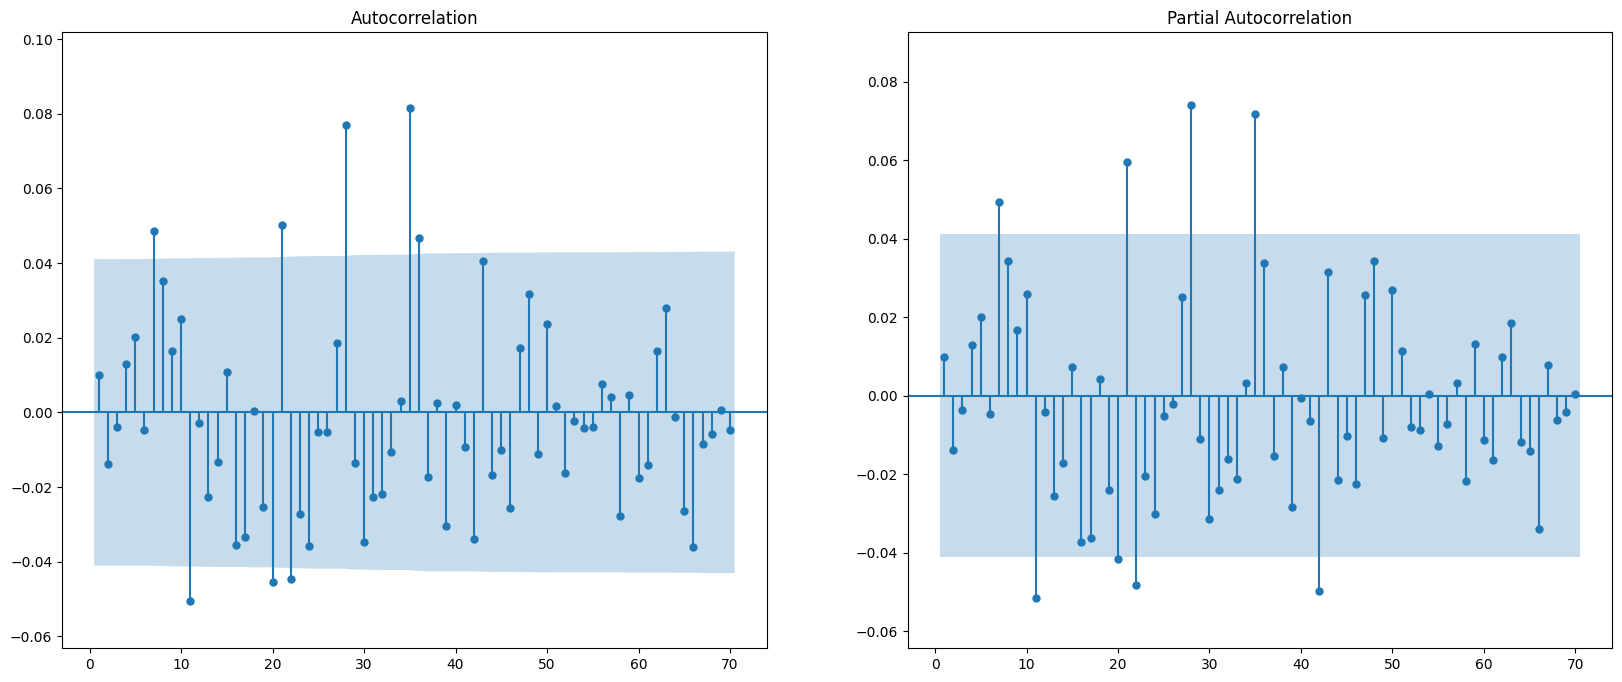

AIC:  5738
                                     SARIMAX Results                                      
Dep. Variable:                       log_ave_days   No. Observations:                 2278
Model:             ARIMA(6, 1, 5)x(1, 1, [1], 14)   Log Likelihood               -2855.221
Date:                            Wed, 14 Feb 2024   AIC                           5738.442
Time:                                    19:51:44   BIC                           5818.584
Sample:                                01-04-2007   HQIC                          5767.685
                                     - 03-30-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6717      0.264     -2.544      0.011      -1.189      -0.154
ar.L2         -0.5490   

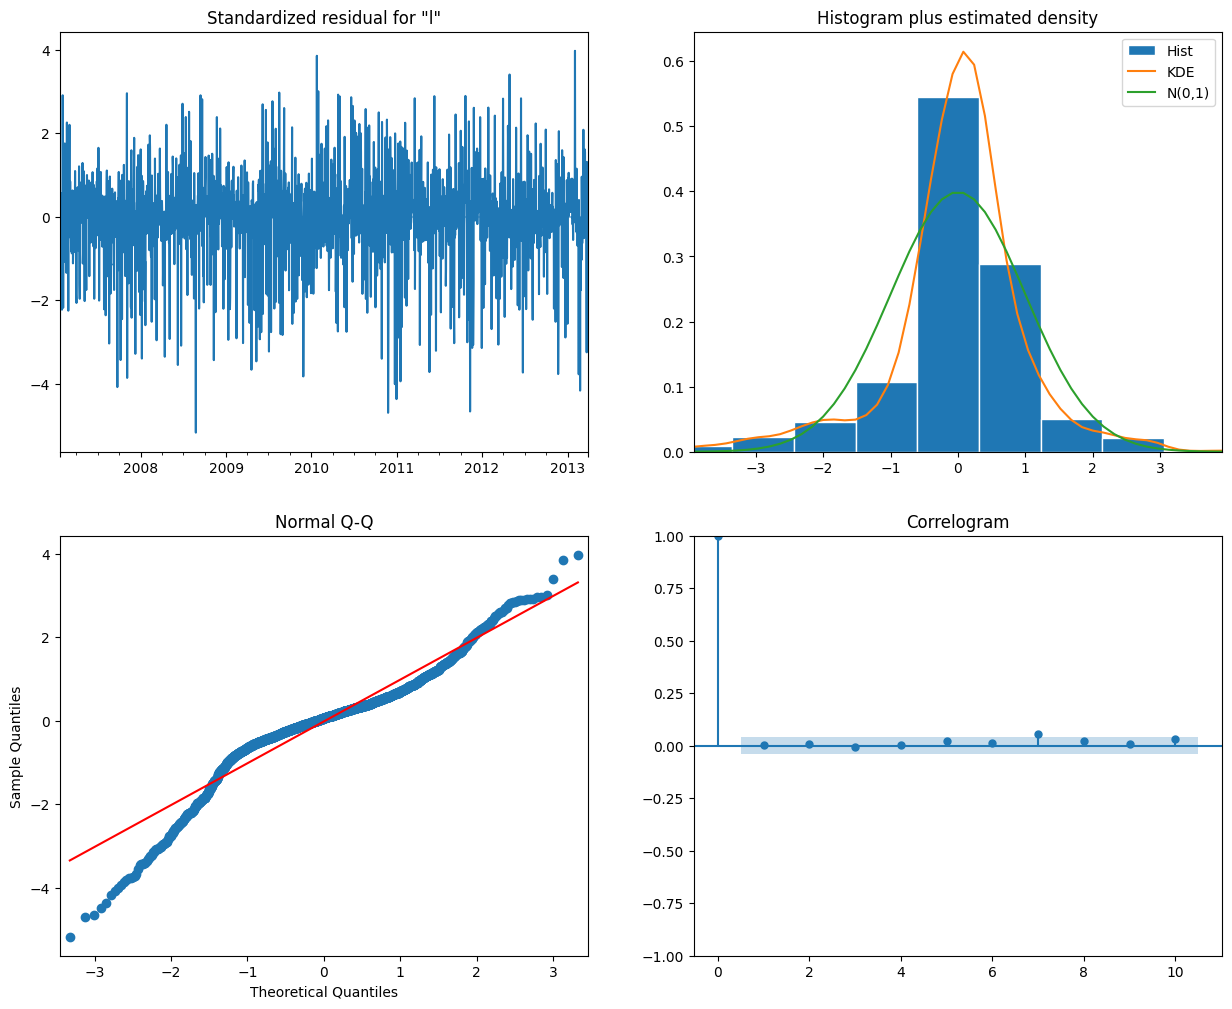

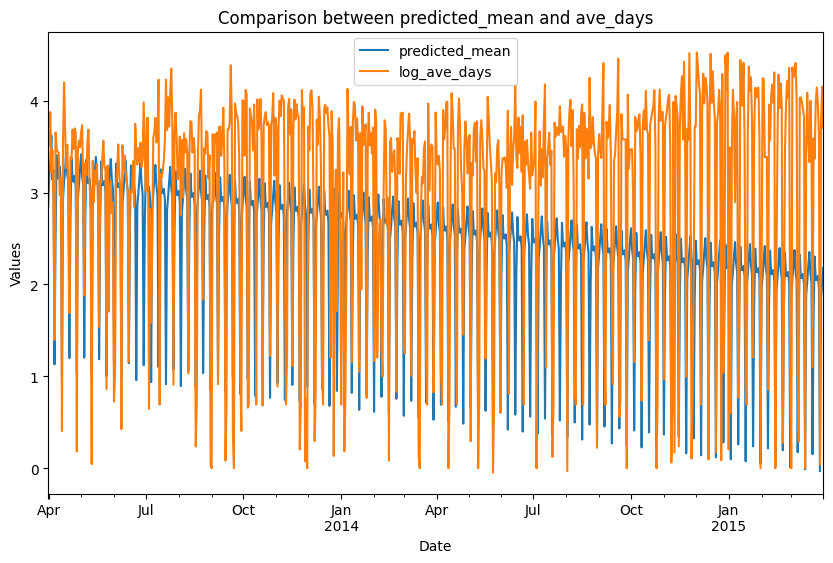

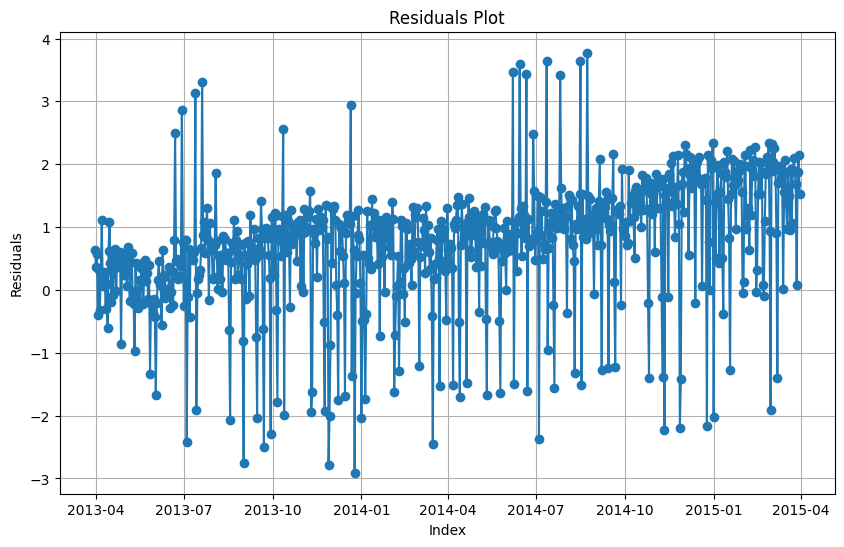

Residuals are not normally distributed (reject H0)
MAE: 1.0437658085987722
MAPE: inf


In [ ]:
# fit model
modhypr = ARIMA(logtrain_arima,
             order=(6, 1, 5),
             seasonal_order=(1,1,1, 14))
modhypr = modhypr.fit()

# acf pacf
acf_pacf(modhypr.resid, 70)

predictionhr = modhypr.forecast(steps=len(logtest_arima))  # Get the forecasted values
predictionhr = pd.Series(predictionhr, index=logtest_arima.index)
residuals = logtest_arima - predictionhr
#predhypr = np.exp(predictionhr)
concatenated_df = pd.concat([predictionhr.to_frame(), logtest_arima], axis=1)




# valutazione perfomance
aichypr = modhypr.aic
#mapehypr1 = mape(logtest_arima, predictionhr)
print('AIC: ', int(aichypr))
#

print(modhypr.summary())
modhypr.plot_diagnostics(figsize=(15, 12))
plt.show()

concatenated_df.plot(y=['predicted_mean', 'log_ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='-')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()




# Assuming 'y_true' is the true target values and 'y_pred' is the predicted values
mae = mean_absolute_error( concatenated_df['log_ave_days'],concatenated_df['predicted_mean'] )

print('MAE:', mae)

import numpy as np

# Filter out rows where log_ave_days is zero
# non_zero_mask = concatenated_df['log_ave_days'] != 0
# concatenated_df_filtered = concatenated_df[non_zero_mask]

# Calculate absolute error and absolute percentage error
absolute_error = np.abs(concatenated_df['predicted_mean'] - concatenated_df['log_ave_days'])
absolute_percentage_error = (absolute_error /(731*concatenated_df['log_ave_days']))*100



del modhypr
del concatenated_df
del predictionhr
del aichypr
del mape
del absolute_error

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



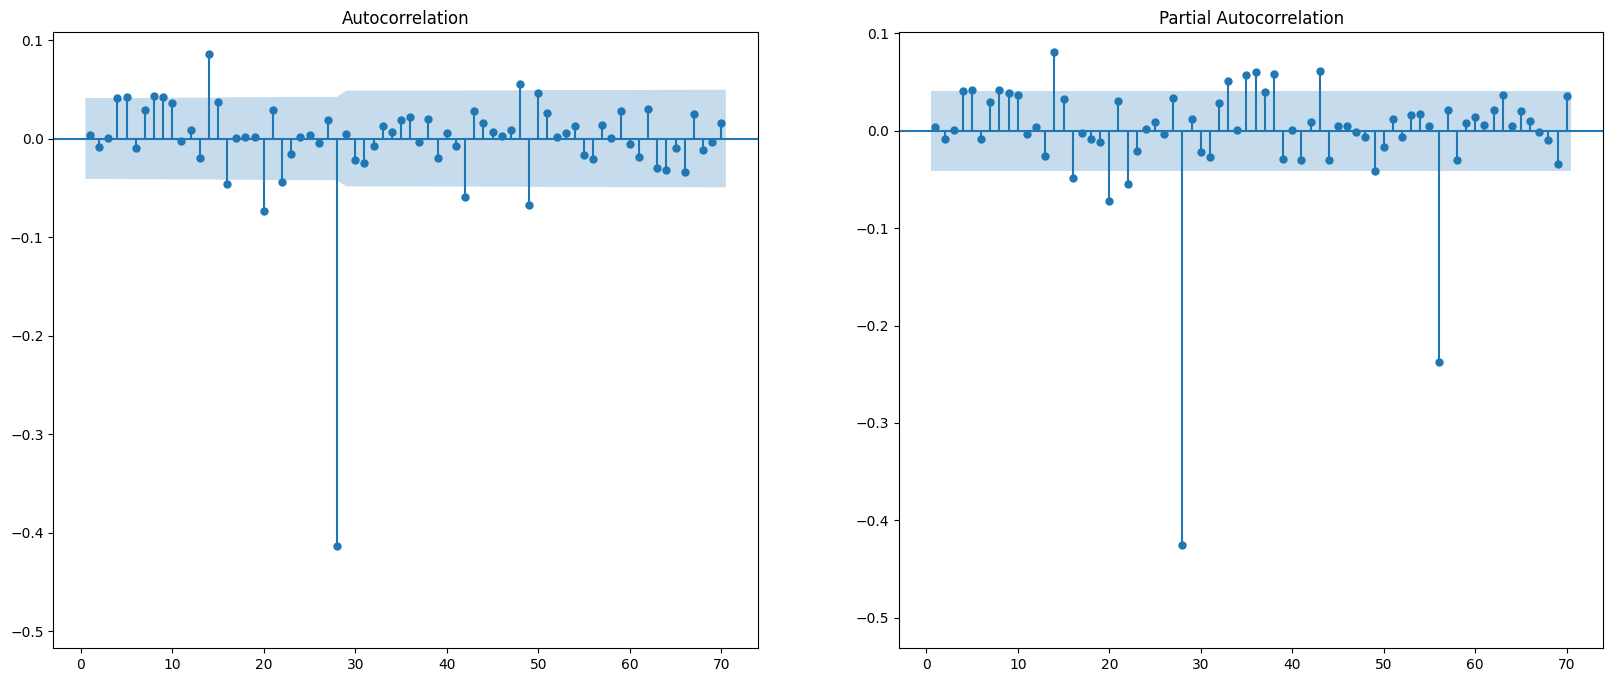

AIC:  6740
                                     SARIMAX Results                                     
Dep. Variable:                          ave_days   No. Observations:                 2278
Model:             ARIMA(6, 1, 5)x(0, 1, [], 28)   Log Likelihood               -3358.313
Date:                           Sun, 18 Feb 2024   AIC                           6740.626
Time:                                   00:06:23   BIC                           6809.245
Sample:                               01-04-2007   HQIC                          6765.672
                                    - 03-30-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1563      0.141     -8.194      0.000      -1.433      -0.880
ar.L2         -0.9132      0.070

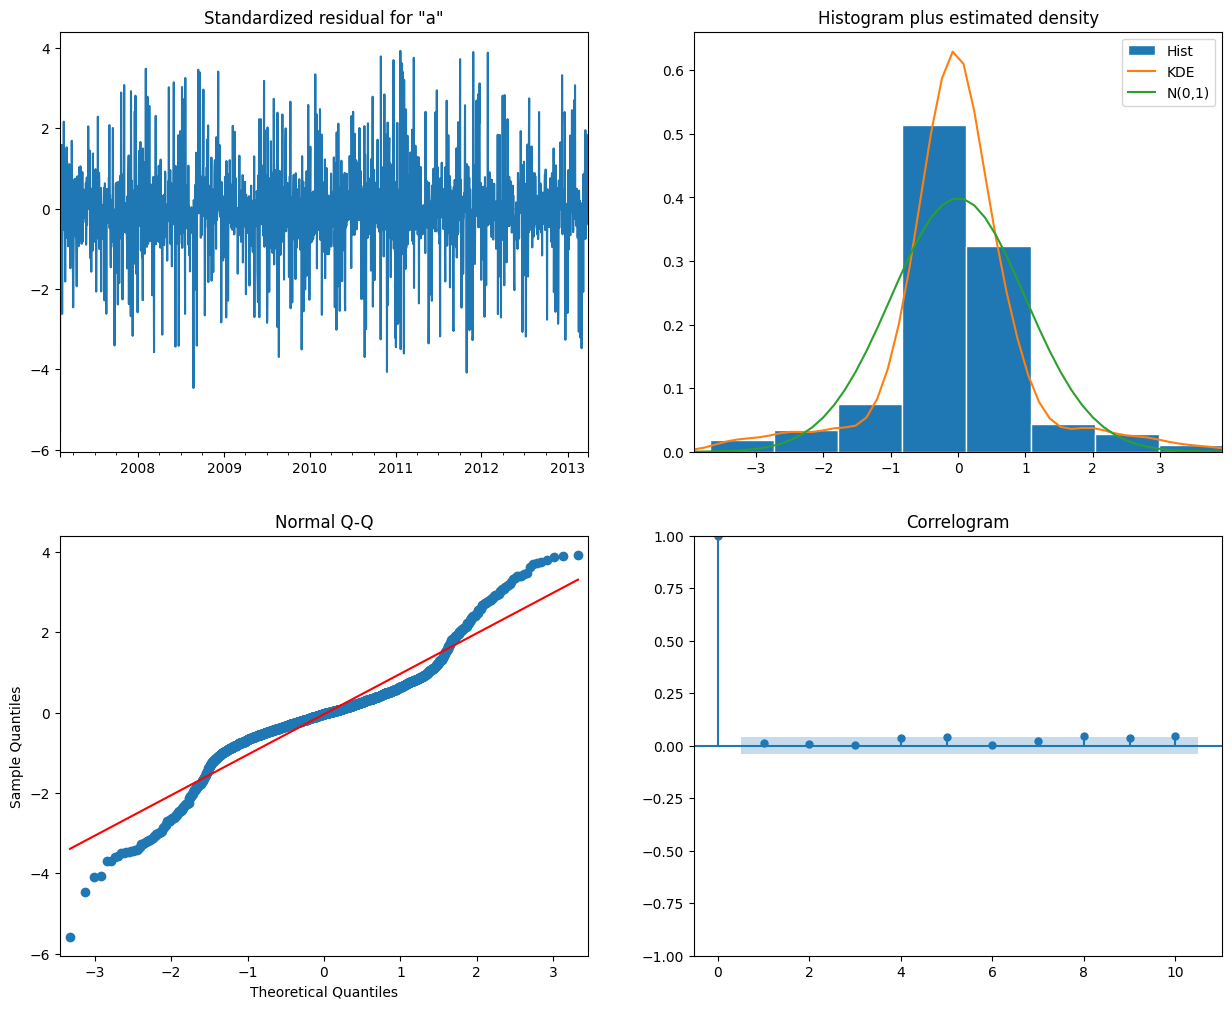

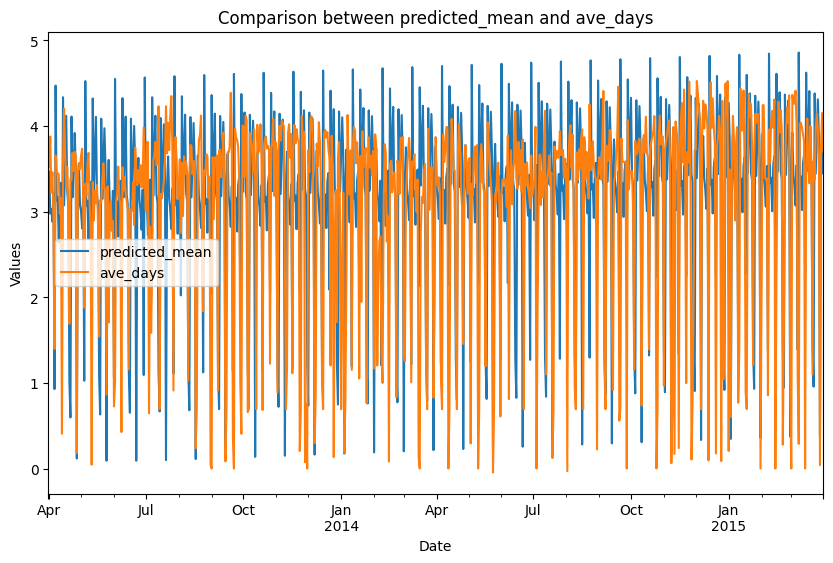

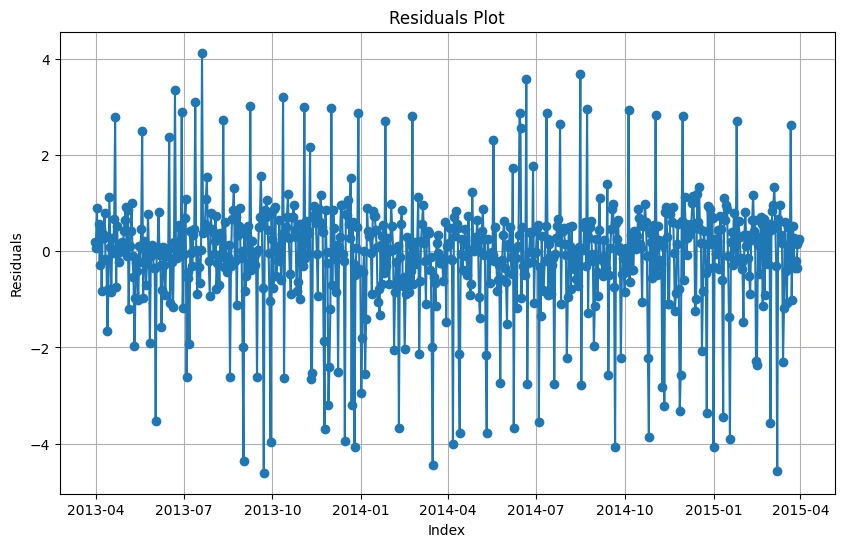

MAE: 0.799059328368752


NameError: name 'mape' is not defined

In [96]:

# fit model
modhypr = ARIMA(logtrain_arima,
             order=(6, 1, 5),
             seasonal_order=(0, 1, 0, 28))
modhypr = modhypr.fit()

# acf pacf
acf_pacf(modhypr.resid, 70)

predictionhr = modhypr.forecast(steps=len(logtest_arima))  # Get the forecasted values
predictionhr = pd.Series(predictionhr, index=logtest_arima.index)
residuals = logtest_arima - predictionhr
#predhypr = np.exp(predictionhr)
concatenated_df = pd.concat([predictionhr.to_frame(), logtest_arima], axis=1)




# valutazione perfomance
aichypr = modhypr.aic
#mapehypr1 = mape(logtest_arima, predictionhr)
print('AIC: ', int(aichypr))
#

print(modhypr.summary())
modhypr.plot_diagnostics(figsize=(15, 12))
plt.show()

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='-')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()






# Assuming 'y_true' is the true target values and 'y_pred' is the predicted values
mae = mean_absolute_error( concatenated_df['ave_days'],concatenated_df['predicted_mean'] )

print('MAE:', mae)

# Filter out rows where log_ave_days is zero
# non_zero_mask = concatenated_df['log_ave_days'] != 0
# concatenated_df_filtered = concatenated_df[non_zero_mask]


# Calculate MAPE

del modhypr
del concatenated_df
del predictionhr
del aichypr


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



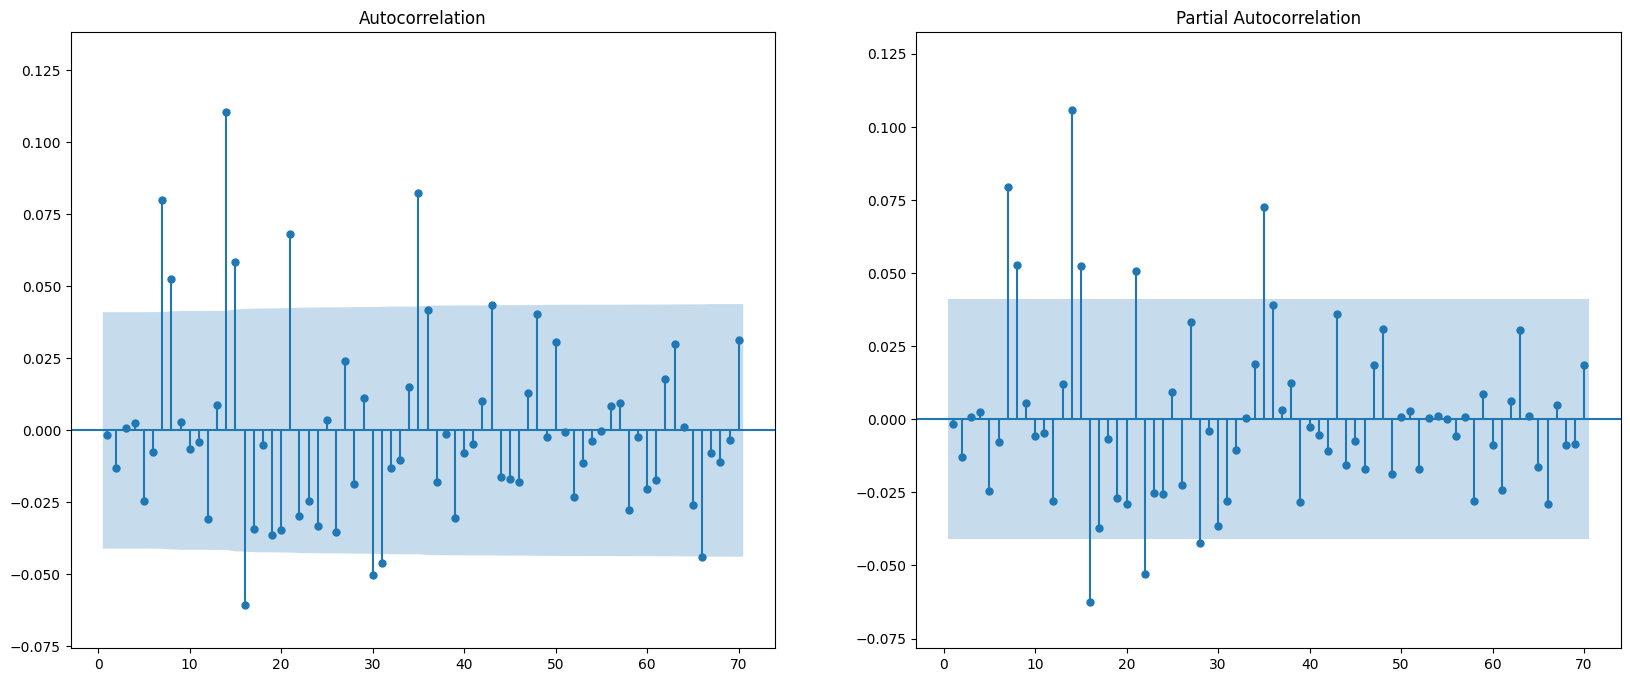

AIC:  5812
                                     SARIMAX Results                                      
Dep. Variable:                           ave_days   No. Observations:                 2278
Model:             ARIMA(6, 1, 5)x(1, 1, [1], 28)   Log Likelihood               -2892.181
Date:                            Sun, 18 Feb 2024   AIC                           5812.362
Time:                                    00:24:34   BIC                           5892.417
Sample:                                01-04-2007   HQIC                          5841.582
                                     - 03-30-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0816      0.073    -14.834      0.000      -1.224      -0.939
ar.L2         -0.9886   

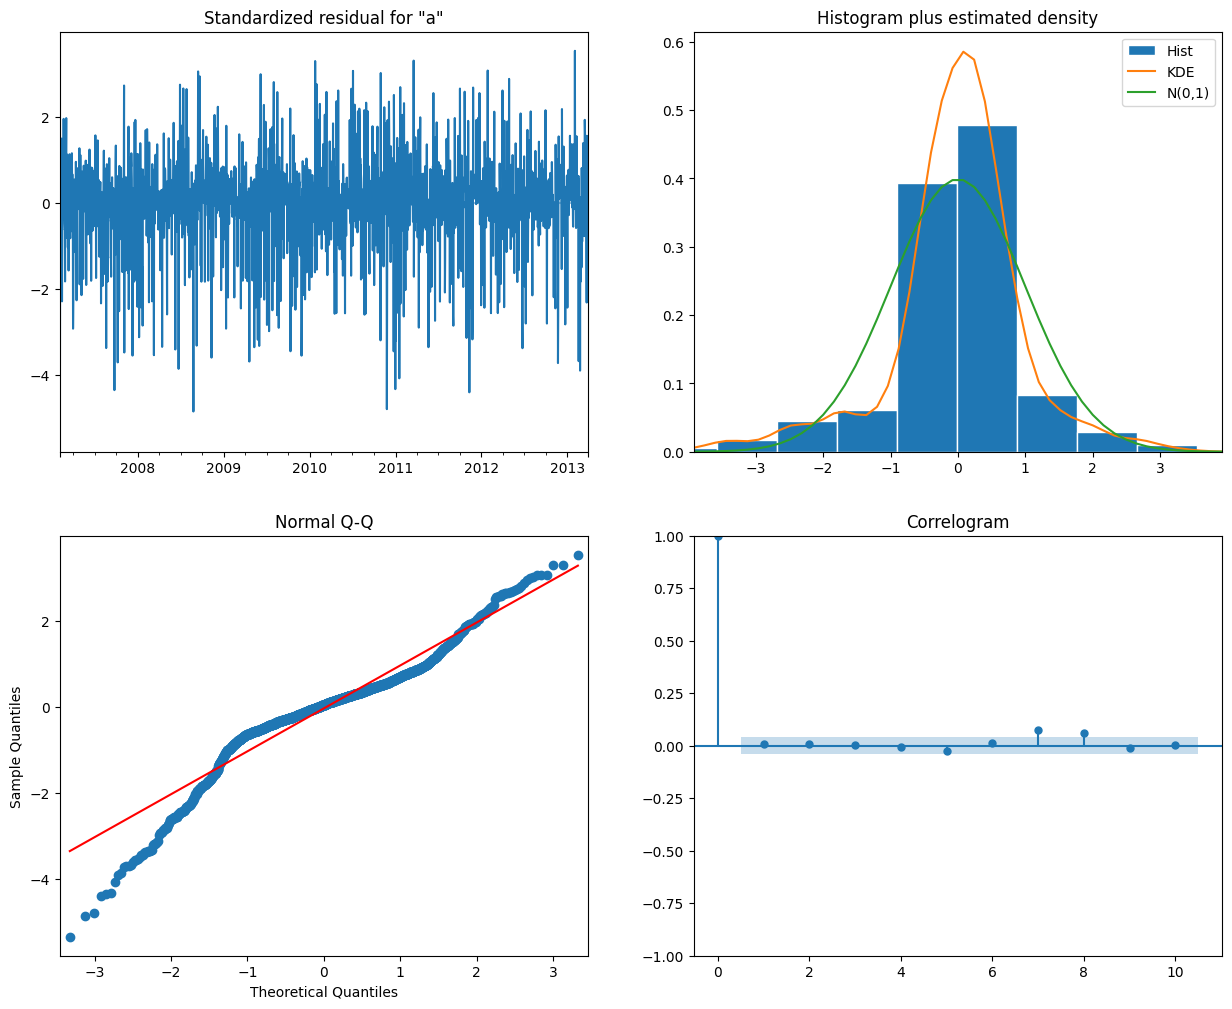

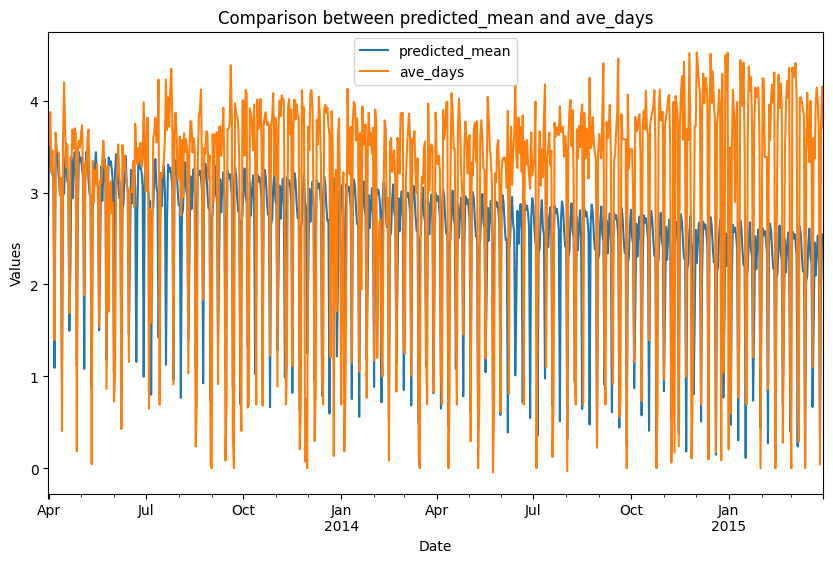

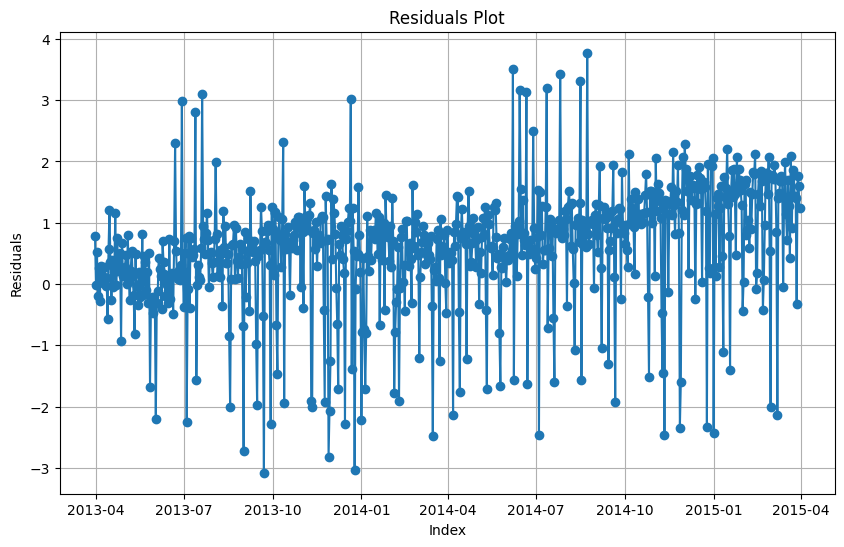

MAE: 0.9414724738452802


NameError: name 'mape' is not defined

In [99]:

# fit model
modhypr = ARIMA(logtrain_arima,
             order=(6, 1, 5),
             seasonal_order=(1, 1, 1, 28))
modhypr = modhypr.fit()

# acf pacf
acf_pacf(modhypr.resid, 70)

predictionhr = modhypr.forecast(steps=len(logtest_arima))  # Get the forecasted values
predictionhr = pd.Series(predictionhr, index=logtest_arima.index)
residuals = logtest_arima - predictionhr
#predhypr = np.exp(predictionhr)


concatenated_df = pd.concat([predictionhr.to_frame(), logtest_arima], axis=1)




# valutazione perfomance
aichypr = modhypr.aic
#mapehypr1 = mape(logtest_arima, predictionhr)
print('AIC: ', int(aichypr))
#

print(modhypr.summary())
modhypr.plot_diagnostics(figsize=(15, 12))
plt.show()

concatenated_df.plot(y=['predicted_mean', 'ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='-')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()



# Perform Shapiro-Wilk test


# Assuming 'y_true' is the true target values and 'y_pred' is the predicted values
mae = mean_absolute_error( concatenated_df['ave_days'],concatenated_df['predicted_mean'] )

print('MAE:', mae)


# Filter out rows where log_ave_days is zero
# non_zero_mask = concatenated_df['log_ave_days'] != 0
# concatenated_df_filtered = concatenated_df[non_zero_mask]

# Calculate absolute error and absolute percentage error



del modhypr
del concatenated_df
del predictionhr
del aichypr
del mape


## Forecasts from 2015-04-01 through 2015-11-07

In [367]:
merged_df = pd.concat([logtrain_arima, logtest_arima])
merged_df=merged_df.to_frame()
merged_df


log_ave_days
date                    
2007-01-04     -1.717651
2007-01-05     -0.693147
2007-01-06      4.052480
2007-01-07      4.052480
2007-01-08      1.258955
...                  ...
2015-03-26      3.968594
2015-03-27      3.652754
2015-03-28      0.039221
2015-03-29      3.737670
2015-03-30      4.150680

[3008 rows x 1 columns]

In [368]:
dates_forecast = pd.date_range(start='2015-04-01 00:00:00', end='2015-11-07 00:00:00', freq='D')
df_forecast= pd.DataFrame()
df_forecast.index = dates_forecast
df_forecast['ave_days'] = None
df_all =  pd.concat([merged_df, df_forecast], axis=0)
df_all

log_ave_days ave_days
2007-01-04     -1.717651      NaN
2007-01-05     -0.693147      NaN
2007-01-06      4.052480      NaN
2007-01-07      4.052480      NaN
2007-01-08      1.258955      NaN
...                  ...      ...
2015-11-03           NaN     None
2015-11-04           NaN     None
2015-11-05           NaN     None
2015-11-06           NaN     None
2015-11-07           NaN     None

[3229 rows x 2 columns]

In [369]:


#     'period': [24, 48, 72],  # Candidate periods
#     'fourier': [2, 3, 4]


all_df = DeterministicProcess(df_all.index, period=24, fourier=3)
all_df = all_df.in_sample()




exog_all = all_df


#     # Split data into train and validation sets (adjust this according to your data)
# train_end = '2015-03-31'
# valid_start =  logtest_arima.index.min()
# valid_end = logtest_arima.index.max()

    # Filter the data for training and validation
exog_train = exog_all[exog_all.index < '2015-04-01']
exog_test = exog_all[exog_all.index >= '2015-04-01']





# Optionally, you can store the forecasted values and use them for further analysis or visualization








In [384]:

mod01 = ARIMA(merged_df,
            order=(6, 1, 5),
            seasonal_order=(0, 1, 0, 24),
            exog=exog_train)

mod01 = mod01.fit()
forecast_steps = len(exog_test)
forecast = mod01.forecast(steps= forecast_steps, exog=exog_test)
forecast


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



LinAlgError: LU decomposition error.

In [ ]:
forecast_steps = len(exog_test)
forecast = mod01.forecast(steps= forecast_steps, exog=exog_test)
forecast


2015-03-31    4.491845
2015-04-01    4.499138
2015-04-02    4.378089
2015-04-03    3.851409
2015-04-04    0.875937
                ...   
2015-11-02    3.703017
2015-11-03    3.978833
2015-11-04    4.139739
2015-11-05    4.168101
2015-11-06    4.115121
Freq: D, Name: predicted_mean, Length: 221, dtype: float64

In [374]:
forecastn = np.exp(forecast)

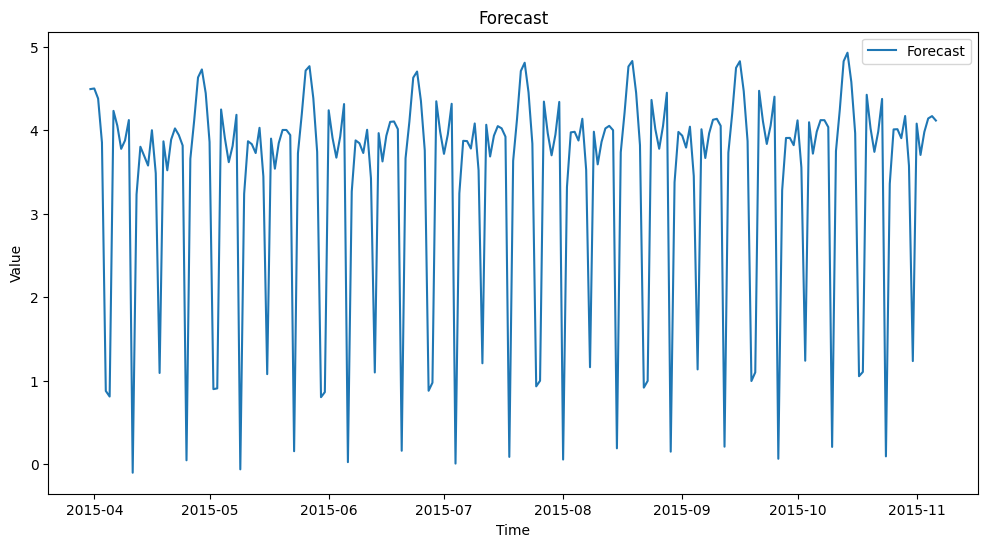

In [372]:
plt.figure(figsize=(12, 6))
plt.plot(forecast, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Forecast')
plt.legend()
plt.show()

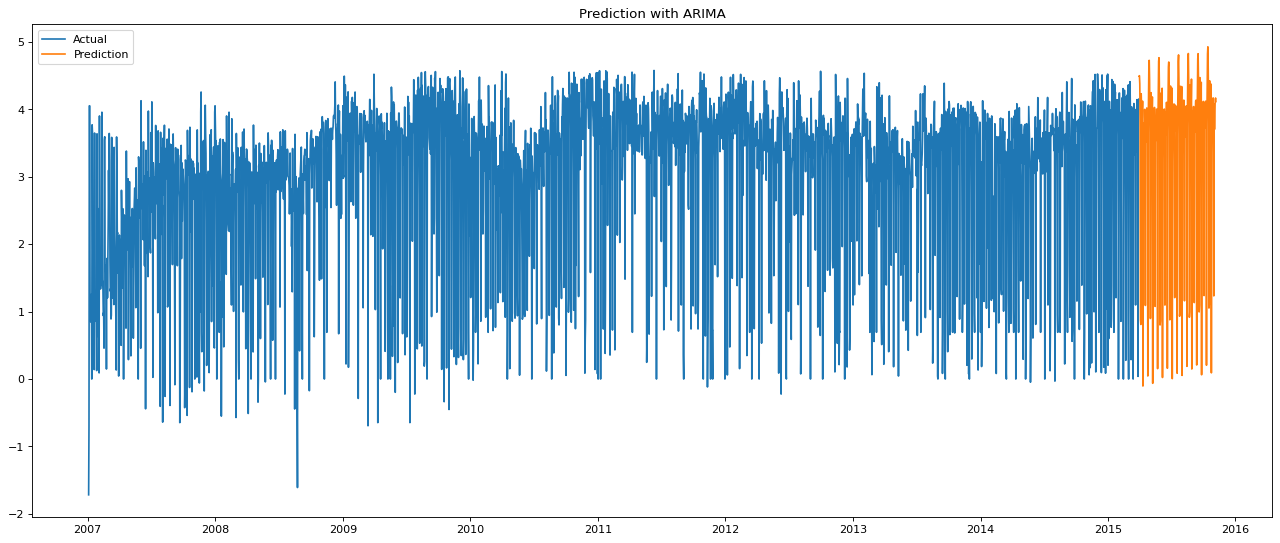

In [373]:
# Plot actual vs predicted values
fig = plt.figure(figsize=(20, 8), dpi=80)
ax = fig.add_subplot(111)
plt.title('Prediction with ARIMA')
ax.plot(merged_df, label='Actual')
ax.plot(forecast, label='Prediction')
plt.legend()
plt.show()

In [377]:
df_train_org = df_train_or['ave_days']
df_test_org = df_test_or['ave_days']

date
2007-01-04     0.179487
2007-01-05     0.500000
2007-01-06    57.539966
2007-01-07    57.539966
2007-01-08     3.521739
                ...    
2013-03-26    25.945813
2013-03-27    31.072948
2013-03-28    44.032738
2013-03-29    33.436364
2013-03-30     1.244898
Name: ave_days, Length: 2278, dtype: float64

In [378]:
df_train_org = df_train_org.to_frame()
df_test_org = df_test_org.to_frame()

In [380]:
df_all = pd.concat([df_train_org, df_test_org], axis=0)

In [381]:
df_all

ave_days
date                 
2007-01-04   0.179487
2007-01-05   0.500000
2007-01-06  57.539966
2007-01-07  57.539966
2007-01-08   3.521739
...               ...
2015-03-27  38.580756
2015-03-28   1.040000
2015-03-29  42.000000
2015-03-30  63.477124
2015-03-31  40.496689

[3009 rows x 1 columns]

In [ ]:
df_test_org = df_test_or['ave_days']

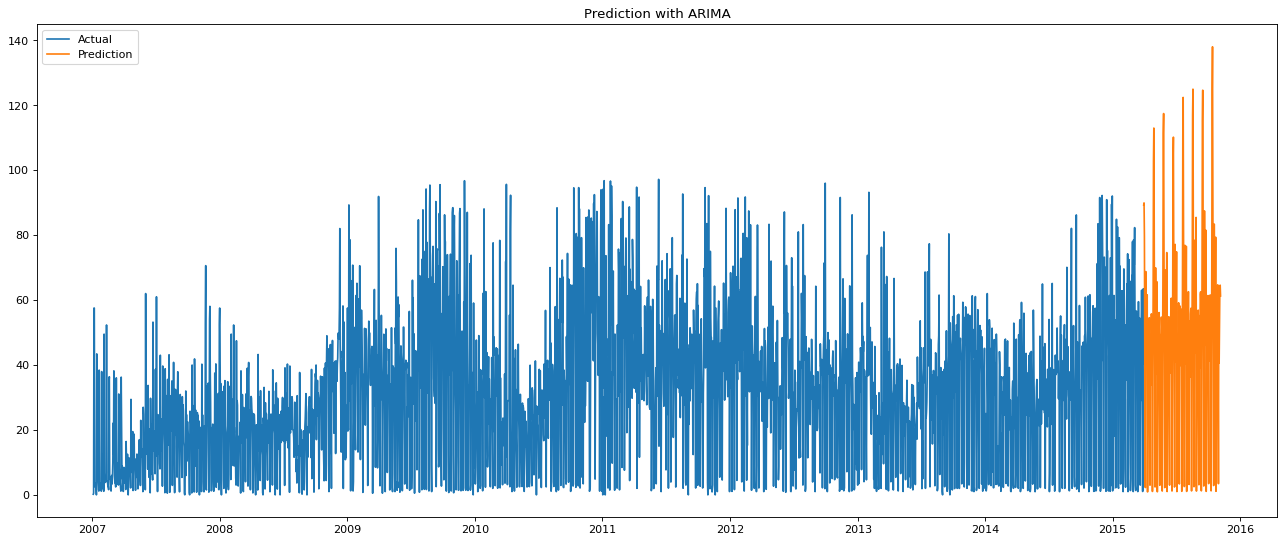

In [382]:
# Plot actual vs predicted values
fig = plt.figure(figsize=(20, 8), dpi=80)
ax = fig.add_subplot(111)
plt.title('Prediction with ARIMA')
ax.plot(df_all, label='Actual')
ax.plot(forecastn, label='Prediction')
plt.legend()
plt.show()

In [108]:
# Saving th results in the dataframe

columns = ["Date", "ARIMA", "UCM", "ML"]
Pred_results = pd.DataFrame(columns = columns)
Pred_results['Date'] = dates_forecast

Pred_results['Date'] = pd.to_datetime(Pred_results['Date']).dt.date

# saving the results of the arima model
Pred_results['ARIMA'] = forecast.values
Pred_results

Date     ARIMA  UCM   ML
0    2015-04-01  4.399049  NaN  NaN
1    2015-04-02  4.346730  NaN  NaN
2    2015-04-03  3.827828  NaN  NaN
3    2015-04-04  0.889177  NaN  NaN
4    2015-04-05  0.880895  NaN  NaN
..          ...       ...  ...  ...
216  2015-11-03  3.882333  NaN  NaN
217  2015-11-04  4.091225  NaN  NaN
218  2015-11-05  4.161342  NaN  NaN
219  2015-11-06  4.114823  NaN  NaN
220  2015-11-07  0.265957  NaN  NaN

[221 rows x 4 columns]

# Selecting P and Q using AIC

# UCM models

In [ ]:
## Level Selection

levels = ['ntrend',  # No trend
          'llevel',  # Local level
          'rwalk',  # Random walk
          'lldtrend',  #Local linear deterministic trend
          'rwdrift',  # Random walk with drift
          'lltrend',  # Local linear trend
          'strend',  # Smooth trend
          'rtrend',  # Random trend
          ]


## Level Evaluation

In [ ]:
for l in levels:
    model = sm.tsa.UnobservedComponents(logtrain_arima, level=l, cycle=True, seasonal=24, stochastic_seasonal=True)
    model = model.fit()
    prediction = model.forecast(steps=len(logtest_arima))
    predictions = pd.Series(prediction, index=logtest_arima.index)
    residuals = logtest_arima - predictions
    concatenateddf = pd.concat([predictions.to_frame(), logtest_arima], axis=1)
    absolute_error = np.abs(concatenateddf['predicted_mean'] - concatenateddf['log_ave_days'])
    absolute_percentage_error = (absolute_error / 731 * concatenateddf['log_ave_days']) * 100

    # Calculate MAPE
    mape = absolute_percentage_error.mean()

    print(f"[Level: {l}] AIC: {model.aic}, MAPE: {mape}")

    # Clean up
    del model
    del concatenateddf
    del prediction


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



[Level: ntrend] AIC: 11832.115457684191, MAPE: 1.4760900882306092


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: dconstant] AIC: 8815.916432563768, MAPE: 0.38791098763987775


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: llevel] AIC: 8973.664452836845, MAPE: 0.4642678947147721


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: rwalk] AIC: 9350.272466126466, MAPE: 0.5128978622999191


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: dtrend] AIC: 8627.602466640476, MAPE: 0.34972859312789323


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: lldtrend] AIC: 8971.044037506574, MAPE: 0.3896295598310014


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: rwdrift] AIC: 9343.827634107745, MAPE: 0.43599249491296477


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: lltrend] AIC: 10044.684940618266, MAPE: 57.774166630907494


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: strend] AIC: 10042.502384365824, MAPE: 57.78090837352287


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: rtrend] AIC: 10287.249551584235, MAPE: 98.3426112531947


In [ ]:

for l in levels:
    # Fit the model
    model = sm.tsa.UnobservedComponents(logtrain_arima, level=l, cycle=True, seasonal=24, stochastic_seasonal=True)
    model = model.fit()

    # Forecast
    prediction = model.forecast(steps=len(logtest_arima))
    predictions = pd.Series(prediction, index=logtest_arima.index)
    residuals = logtest_arima - predictions

    # Calculate MAPE for test
    absolute_error_test = np.abs(predictions - logtest_arima)
    absolute_percentage_error_test = (absolute_error_test / 731*logtest_arima) * 100
    mape_test = absolute_percentage_error_test.mean()



    print(f"[Level: {l}] AIC: {model.aic}, MAPE for Test: {mape_test}")

    # Clean up
    del model
    del mape_test



# [Level: llevel] AIC: 8973.664452836845 ,  MAPE: 0.4643
# [Level: rwdrift] AIC: 9343.827634107745,  MAPE: 0.4360
# [Level: ntrend] AIC: 11832.115457684191, MAPE: 1.4761
# [Level: rwalk] AIC: 9350.272466126466, MAPE: 0.5129
# [Level: lldtrend] AIC: 8971.044037506574, MAPE: 0.3896
# [Level: lltrend] AIC: 10044.684940618266, MAPE: 57.7742
# [Level: strend] AIC: 10042.502384365824, MAPE: 57.7809
# [Level: rtrend] AIC: 10287.249551584235, MAPE: 98.3426


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



[Level: ntrend] AIC: 11832.115457684191, MAPE for Test: 1.4760900882306092


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: dconstant] AIC: 8815.916432563768, MAPE for Test: 0.38791098763987775


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: llevel] AIC: 8973.664452836845, MAPE for Test: 0.4642678947147721


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: rwalk] AIC: 9350.272466126466, MAPE for Test: 0.5128978622999191


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: dtrend] AIC: 8627.602466640476, MAPE for Test: 0.34972859312789323


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: lldtrend] AIC: 8971.044037506574, MAPE for Test: 0.3896295598310014


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: rwdrift] AIC: 9343.827634107745, MAPE for Test: 0.43599249491296477


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: lltrend] AIC: 10044.684940618266, MAPE for Test: 57.774166630907494


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: strend] AIC: 10042.502384365824, MAPE for Test: 57.78090837352287


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[Level: rtrend] AIC: 10287.249551584235, MAPE for Test: 98.3426112531947


## UCM frequency-based seasonal components

UCM Level & seasonality configurations

In [ ]:
import numpy as np

harmonics_daily = [2, 3, 4, 5, 6, 7]
harmonics_weekly = [2, 3, 4, 5, 6]

for i in harmonics_daily:
    for j in harmonics_weekly:
        mod = UnobservedComponents(logtrain_arima,
                                    seasonal=24,
                                    level='rwdrift',
                                    freq_seasonal=[{'period': 24, 'harmonics': i},
                                                   {'period': 168, 'harmonics': j}],stochastic_seasonal=True)
        mod = mod.fit()

        pred = mod.forecast(steps=len(logtest_arima))
        preds = pd.Series(pred, index=logtest_arima.index)
        concatenatedf = pd.concat([preds.to_frame(), logtest_arima], axis=1)
        absolute_error = np.abs(concatenatedf['predicted_mean'] - concatenatedf['log_ave_days'])
        mape = np.abs(absolute_error /731*concatenatedf['log_ave_days']) * 100
        mape_value = mape.mean()

        # Print results
        print(f"harmonics_daily: {i}, harmonics_weekly: {j}, AIC: {round(mod.aic, 4)}, MAPE: {round(mape_value, 4)}")

# Clean up
del mod
del concatenatedf




## Best Parameters
# harmonics_daily: 3, harmonics_weekly: 6, AIC: 8435.8867, MAPE: 0.4903
# harmonics_daily: 4, harmonics_weekly: 5, AIC: 8448.1765, MAPE: 0.4168
# harmonics_daily: 4, harmonics_weekly: 6, AIC: 8473.2126, MAPE: 0.4152

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 2, harmonics_weekly: 2, AIC: 8182.9125, MAPE: 1.1469


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 2, harmonics_weekly: 3, AIC: 8201.6361, MAPE: 1.1415


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 2, harmonics_weekly: 4, AIC: 8217.83, MAPE: 1.1395


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 2, harmonics_weekly: 5, AIC: 8237.9099, MAPE: 1.1142


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 2, harmonics_weekly: 6, AIC: 8257.2188, MAPE: 1.1302


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 3, harmonics_weekly: 2, AIC: 8171.5472, MAPE: 1.1469


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 3, harmonics_weekly: 3, AIC: 8188.1517, MAPE: 1.1414


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 3, harmonics_weekly: 4, AIC: 8208.5987, MAPE: 1.1395


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 3, harmonics_weekly: 5, AIC: 8225.3201, MAPE: 1.1141


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 3, harmonics_weekly: 6, AIC: 8435.8867, MAPE: 0.4903


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



harmonics_daily: 4, harmonics_weekly: 2, AIC: 8162.2479, MAPE: 1.1468


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 4, harmonics_weekly: 3, AIC: 8179.425, MAPE: 1.1415


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 4, harmonics_weekly: 4, AIC: 8195.697, MAPE: 1.1394


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 4, harmonics_weekly: 5, AIC: 8448.1765, MAPE: 0.4168


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 4, harmonics_weekly: 6, AIC: 8473.2126, MAPE: 0.4152


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 5, harmonics_weekly: 2, AIC: 8153.5916, MAPE: 1.1468


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 5, harmonics_weekly: 3, AIC: 8169.2434, MAPE: 1.1414


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 5, harmonics_weekly: 4, AIC: 8183.1425, MAPE: 1.1393


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 5, harmonics_weekly: 5, AIC: 8202.6578, MAPE: 1.1141


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 5, harmonics_weekly: 6, AIC: 8221.4036, MAPE: 1.1301


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 6, harmonics_weekly: 2, AIC: 8144.8867, MAPE: 1.1469


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 6, harmonics_weekly: 3, AIC: 8157.2598, MAPE: 1.1414


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 6, harmonics_weekly: 4, AIC: 8174.4207, MAPE: 1.1394


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 6, harmonics_weekly: 5, AIC: 8191.2081, MAPE: 1.114


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 6, harmonics_weekly: 6, AIC: 8211.1852, MAPE: 1.1301


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 7, harmonics_weekly: 2, AIC: 8133.2247, MAPE: 1.1468


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 7, harmonics_weekly: 3, AIC: 8148.6968, MAPE: 1.1414


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 7, harmonics_weekly: 4, AIC: 8163.8108, MAPE: 1.1393


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 7, harmonics_weekly: 5, AIC: 8181.8219, MAPE: 1.1141


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



harmonics_daily: 7, harmonics_weekly: 6, AIC: 8196.5841, MAPE: 1.13


c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



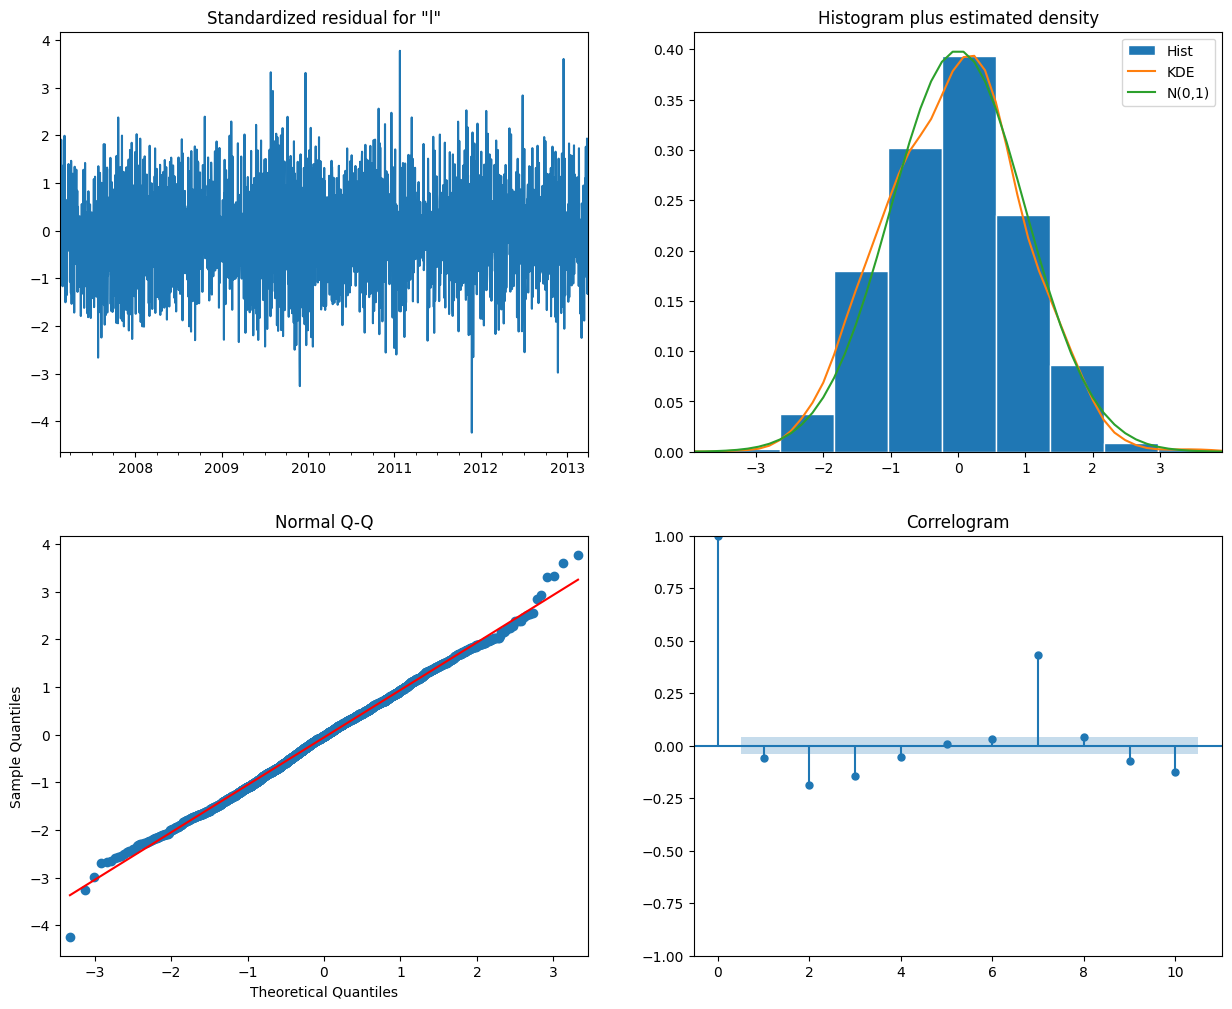

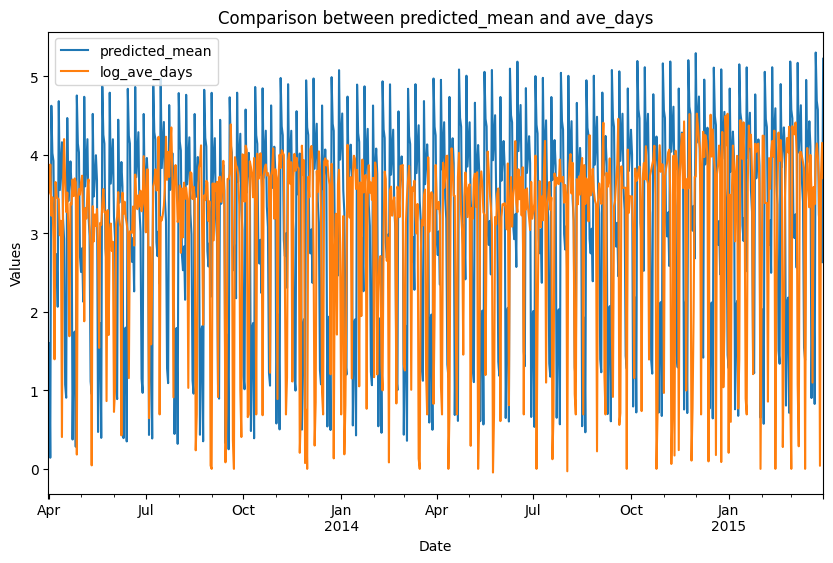

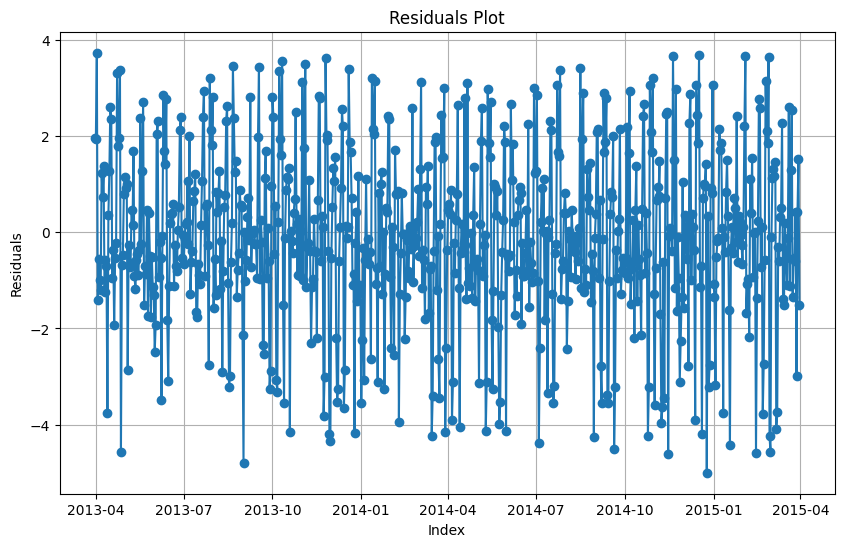

Residuals are not normally distributed (reject H0)


In [ ]:

# Harmonics Daily: 3
# Harmonics Weekly: 6

mod1 = UnobservedComponents(logtrain_arima,
                                seasonal = 24,
                                level = 'rwdrift',  # quello che si è ottenuto come risultato migliore nel passo precedente
                                freq_seasonal = [{'period': 24, 'harmonics': 3},
                                                 {'period': 168, 'harmonics': 6}],
                                stochastic_seasonal=True)
mod = mod1.fit()

pred = mod.forecast(steps=len(logtest_arima))
preds = pd.Series(pred, index=logtest_arima.index)
residuals = logtest_arima - preds
concatenatedf = pd.concat([preds.to_frame(), logtest_arima], axis=1)
# absolute_error = np.abs(concatenatedf['predicted_mean'] - concatenatedf['log_ave_days'])
# mape = np.abs(absolute_error /731*concatenatedf['log_ave_days']) * 100
# mape_value = mape.mean()
# print(f"MAPE: {round(mape_value, 4)}")


mod.plot_diagnostics(figsize=(15, 12))
plt.show()

concatenatedf.plot(y=['predicted_mean', 'log_ave_days'], figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison between predicted_mean and ave_days')

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='-')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()



# Perform Shapiro-Wilk test
statistic, p_value = shapiro(residuals)

# Check the p-value
alpha = 0.05
if p_value > alpha:
    print("Residuals are normally distributed (fail to reject H0)")
else:
    print("Residuals are not normally distributed (reject H0)")



# del mod
# del concatenatedf
# del preds
# del mape_value

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Carry out Ljung-Box test
print(acorr_ljungbox(residuals, return_df=True))




       lb_stat     lb_pvalue
1    42.233396  8.100484e-11
2    49.171736  2.101325e-11
3    77.789168  9.144828e-17
4   184.683589  7.354353e-39
5   247.565488  1.829968e-51
6   248.913002  7.001844e-51
7   408.579414  3.447217e-84
8   447.321231  1.386386e-91
9   458.510012  4.344497e-93
10  462.461122  4.585198e-93


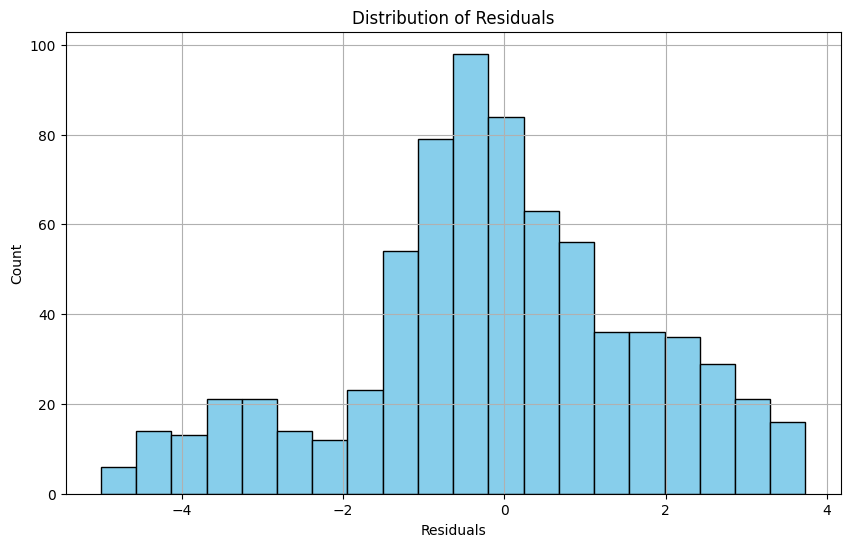

Mean of residuals: -0.12158053134656586


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of the residuals using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Mean of residuals
print("Mean of residuals:", residuals.mean())


##  the mean of the residuals, which is approximately -0.1216.
#  This value represents the average deviation of the residuals from the predicted values.
#  It generally indicates whether the model tends to overestimate or underestimate
# the observed values, with a mean closer to zero suggesting better predictive accuracy.

## The required forecasting period.


In [113]:

dates_forecasts = pd.date_range(start='2015-04-01 00:00:00', end='2015-11-07 00:00:00', freq='D')
df_forecasts= pd.DataFrame()
df_forecasts.index = dates_forecasts


In [114]:
df_forecasts['ave_days'] = None
df_all =  pd.concat([merged_df, df_forecasts], axis=0)

C:\Users\sam\AppData\Local\Temp\ipykernel_31632\251040638.py:2: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [115]:
mod1 = UnobservedComponents(merged_df,
                                seasonal = 28,
                                level = 'rwdrift',  # quello che si è ottenuto come risultato migliore nel passo precedente
                                freq_seasonal = [{'period': 24, 'harmonics': 3},
                                                 {'period': 168, 'harmonics': 6}],
                                stochastic_seasonal=True)
mod = mod1.fit()

pred = mod.forecast(steps=len(df_forecasts))
preds = pd.Series(pred, index=df_forecasts.index)

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



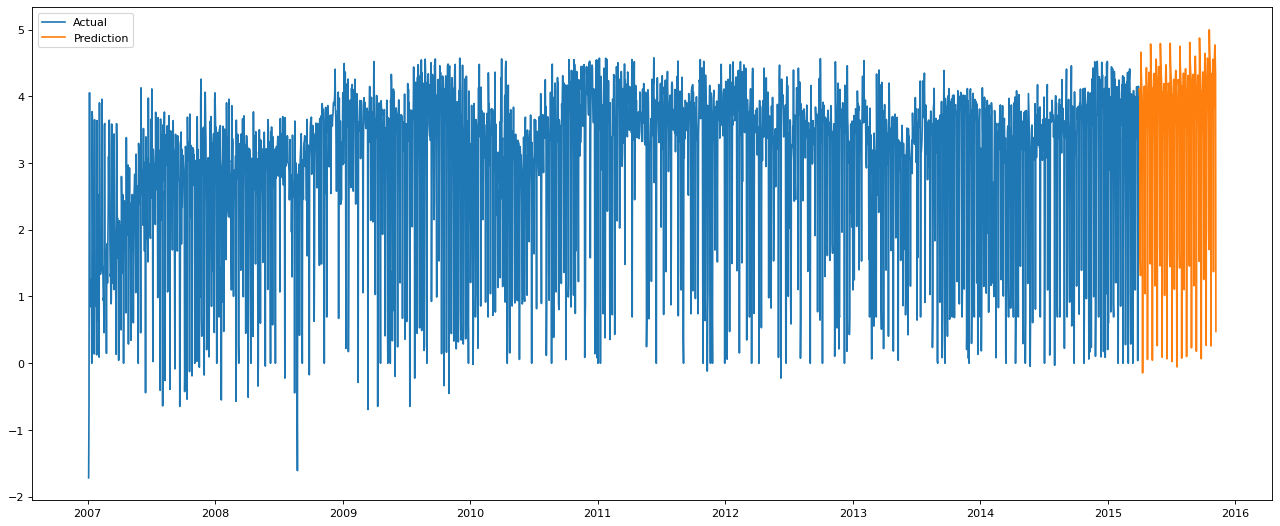

In [117]:


# Plot actual vs predicted values
fig = plt.figure(figsize=(20, 8), dpi=80)
ax = fig.add_subplot(111)
# plt.title('Prediction with ARIMA')
ax.plot(merged_df, label='Actual')
ax.plot(preds, label='Prediction')
plt.legend()
plt.show()

In [118]:
mod2 = UnobservedComponents(merged_df,
                                seasonal = 24,
                                level = 'rwdrift',  # quello che si è ottenuto come risultato migliore nel passo precedente
                                freq_seasonal = [{'period': 24, 'harmonics': 3},
                                                 {'period': 168, 'harmonics': 6}],
                                stochastic_seasonal=True)
mod2 = mod2.fit()

pred2 = mod2.forecast(steps=len(df_forecasts))
preds2 = pd.Series(pred2, index=df_forecasts.index)

c:\Users\sam\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



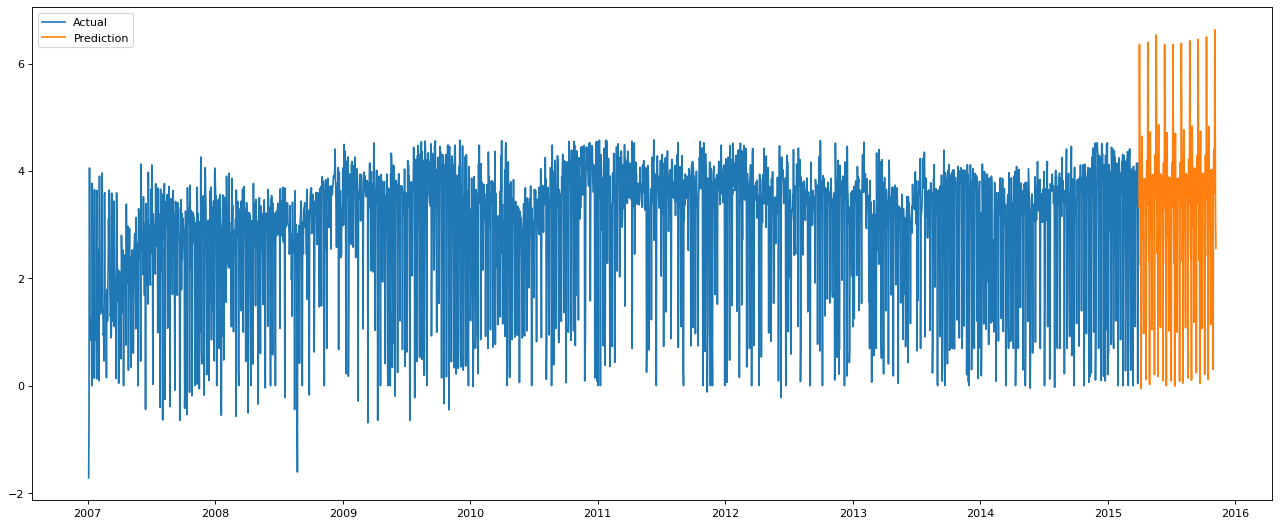

In [119]:


# Plot actual vs predicted values
fig = plt.figure(figsize=(20, 8), dpi=80)
ax = fig.add_subplot(111)
# plt.title('Prediction with ARIMA')
ax.plot(merged_df, label='Actual')
ax.plot(preds2, label='Prediction')
plt.legend()
plt.show()

# The preds of the best performing model

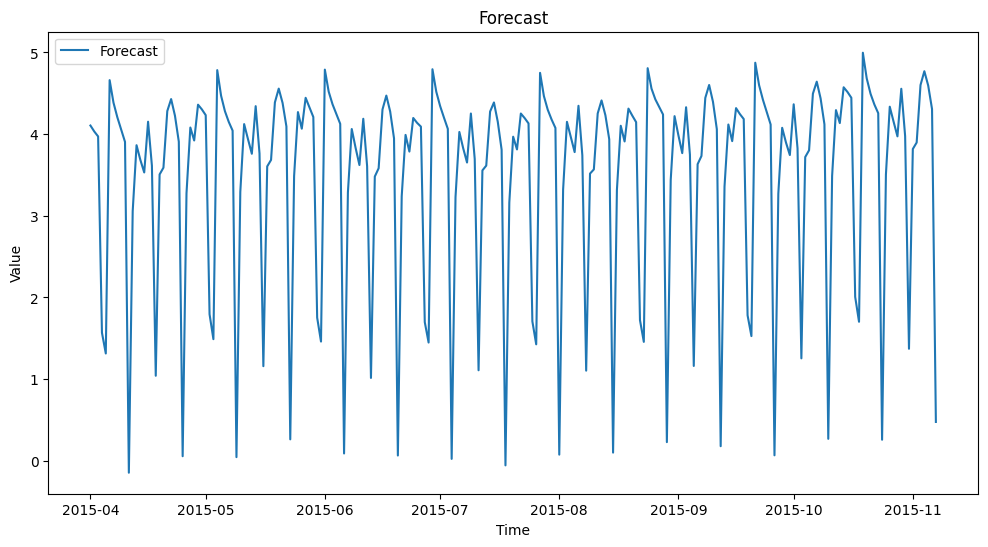

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(preds, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Forecast')
plt.legend()
plt.show()

In [218]:

# saving the results of the arima model
Pred_results['UCM'] = preds.values
Pred_results

NameError: name 'preds' is not defined

In [122]:
file_path = "C:/Users/sam/Desktop/TimeSeries/Project/Preds_Results/896440&897683_20240218.csv"

# Export DataFrame to CSV
Pred_results.to_csv(file_path, index=False)

## ML

In [194]:

dff= pd.read_csv('C:/Users/sam/Desktop/TimeSeries/Dataset/cleaneddf.csv')
Pred_results = pd.read_csv("C:/Users/sam/Desktop/TimeSeries/Project/Preds_Results/896440&897683_20240218.csv")

df.head()


weekday  dayofweek  quarter  dayofmonth  month  year   ave_days  \
date                                                                           
2007-01-04  Thursday          3        1           4      1  2007   0.179487   
2007-01-05    Friday          4        1           5      1  2007   0.500000   
2007-01-06  Saturday          5        1           6      1  2007  57.539966   
2007-01-07    Sunday          6        1           7      1  2007  57.539966   
2007-01-08    Monday          0        1           8      1  2007   3.521739   

            rolmean  
date                 
2007-01-04      NaN  
2007-01-05      NaN  
2007-01-06      NaN  
2007-01-07      NaN  
2007-01-08      NaN

In [195]:
import pandas as pd

def new_features(df, label):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])  # Convert 'date' column to datetime type
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['dayofmonth'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['Day_of_year'] = df['date'].dt.dayofyear
    df['Weekend'] = df['date'].dt.weekday.isin([5, 6]).astype(int)
    #df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(label, axis=1)
    y = df[label]
    return X, y



In [196]:
# Example usage
X, y = new_features(dff, label='ave_days')
dff = pd.concat([X, y], axis=1)
dff.head()

date    weekday  dayofweek  quarter  dayofmonth  month  year  \
0 2007-01-04   Thursday          3        1           4      1  2007   
1 2007-01-05     Friday          4        1           5      1  2007   
2 2007-01-08     Monday          0        1           8      1  2007   
3 2007-01-09    Tuesday          1        1           9      1  2007   
4 2007-01-10  Wednesday          2        1          10      1  2007   

   Day_of_year  Weekend  ave_days  
0            4        0  0.179487  
1            5        0  0.500000  
2            8        0  3.521739  
3            9        0  2.850000  
4           10        0  2.333333

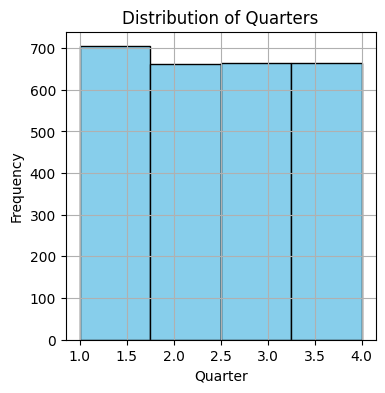

In [197]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the 'quarter' feature
quarters = dff['quarter']

# Setting the size of the plot
plt.figure(figsize=(4, 4))

# Plotting the histogram
plt.hist(quarters, bins=4, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Quarter')
plt.ylabel('Frequency')
plt.title('Distribution of Quarters')

# Adding grid for better readability
plt.grid(True)

# Displaying the plot
plt.show()

In [198]:
# Drop the 'rolmean' column
dff = dff.drop(columns=['weekday','date'])

In [199]:
# Function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Add season column to the dataframe
dff['season'] = dff['month'].apply(get_season)

# Display the dataframe with the added season column
# print(df)


In [200]:
# Function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

# Add season column to the dataframe
dff['season'] = dff['month'].apply(get_season)

# Display the dataframe with the added season column
# print(df)


In [201]:
dff1 = dff.copy()

In [202]:
dff1['ave_days'].max()

102.447674418605

In [203]:
# Reorder the columns
dff1 = dff1[['dayofweek', 'quarter', 'dayofmonth','Day_of_year', 'month', 'Weekend', 'season', 'year', 'ave_days']]


In [204]:
dff1

dayofweek  quarter  dayofmonth  Day_of_year  month  Weekend  season  \
0             3        1           4            4      1        0       0   
1             4        1           5            5      1        0       0   
2             0        1           8            8      1        0       0   
3             1        1           9            9      1        0       0   
4             2        1          10           10      1        0       0   
...         ...      ...         ...          ...    ...      ...     ...   
2690          4        1          27           86      3        0       1   
2691          5        1          28           87      3        1       1   
2692          6        1          29           88      3        1       1   
2693          0        1          30           89      3        0       1   
2694          1        1          31           90      3        0       1   

      year   ave_days  
0     2007   0.179487  
1     2007   0.500000  
2     2007   3.521739  
3     2007   2.850000  
4     2007   2.333333  
...    ...        ...  
2690  2015  38.580756  
2691  2015   1.040000  
2692  2015  42.000000  
2693  2015  63.477124  
2694  2015  40.496689  

[2695 rows x 9 columns]

In [205]:
dff1.duplicated().sum()

0

In [206]:

# Preparing data for training and testing
X = dff1.drop('ave_days', axis=1)
y = dff1['ave_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Printing train and test set size
print(f'Train set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')



Train set size: 2156
Test set size: 539


In [207]:
X_train

dayofweek  quarter  dayofmonth  Day_of_year  month  Weekend  season  \
748           0        1          30           89      3        0       1   
1170          3        3           1          182      7        0       2   
1431          3        2          12          132      5        0       1   
1803          4        3          13          195      7        0       2   
1235          3        3          16          259      9        0       3   
...         ...      ...         ...          ...    ...      ...     ...   
1731          6        2          22          113      4        1       1   
763           2        2          15          105      4        0       1   
835           6        2          28          179      6        1       2   
1653          0        1          23           23      1        0       0   
2607          0        4          22          356     12        0       0   

      year  
748   2009  
1170  2010  
1431  2011  
1803  2012  
1235  2010  
...    ...  
1731  2012  
763   2009  
835   2009  
1653  2012  
2607  2014  

[2156 rows x 8 columns]

In [208]:


def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training model
    model.fit(X_train, y_train)

    # Prediction on test set
    predictions = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    
    # Calculate MAPE
    absolute_errors = np.abs(y_test - predictions)
    denominator = np.abs(y_test)
    denominator[denominator == 0] = 1  # Set zero values to 1 to avoid division by zero
    percentage_errors = absolute_errors / denominator

    # Calculate MAPE
    mape = percentage_errors.mean()
    
    # Printing metrics
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Absolute Percentage Error: {mape:.2f}%')

    return rmse, mae, mape

# Choosing different ML models
models = [
    RandomForestRegressor(n_estimators=100, random_state=42),
#    LinearRegression(),
#     GradientBoostingRegressor(n_estimators=100, random_state=42),
    DecisionTreeRegressor(random_state=42),
    SVR(kernel='rbf'),  # Support Vector Regressor
#     XGBRegressor()  # XGBoost Regressor
]

# Models comparison
for model in models:
    print(f'\nEvaluating {model.__class__.__name__}:\n')
    evaluate_model(model, X_train, y_train, X_test, y_test)


Evaluating RandomForestRegressor:



Root Mean Squared Error: 16.091588996608053
Mean Absolute Error: 11.034176685999592
Mean Absolute Percentage Error: 1.76%

Evaluating DecisionTreeRegressor:

Root Mean Squared Error: 21.712941180125227
Mean Absolute Error: 14.406656263141357
Mean Absolute Percentage Error: 1.66%

Evaluating SVR:

Root Mean Squared Error: 23.454691943379895
Mean Absolute Error: 19.010096071123247
Mean Absolute Percentage Error: 3.85%


In [134]:
from sklearn.svm import SVR

# Choosing different ML models
models = [
    RandomForestRegressor(n_estimators=100, random_state=42),
    LinearRegression(),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    DecisionTreeRegressor(random_state=42),
    SVR(kernel='rbf')  # Using RBF kernel, you can change the kernel as needed
]

# Models comparison
for model in models:
    print(f'\nEvaluating {model.__class__.__name__}:\n')
    evaluate_model(model, X_train, y_train, X_test, y_test)


Evaluating RandomForestRegressor:

Root Mean Squared Error: 16.091588996608053
Mean Absolute Error: 11.034176685999592
Mean Absolute Percentage Error: 1.76%

Evaluating LinearRegression:

Root Mean Squared Error: 19.689446709327726
Mean Absolute Error: 14.66298261410964
Mean Absolute Percentage Error: 1.91%

Evaluating GradientBoostingRegressor:

Root Mean Squared Error: 16.58795623558549
Mean Absolute Error: 11.880345703358785
Mean Absolute Percentage Error: 1.72%

Evaluating DecisionTreeRegressor:

Root Mean Squared Error: 21.712941180125227
Mean Absolute Error: 14.406656263141357
Mean Absolute Percentage Error: 1.66%

Evaluating SVR:

Root Mean Squared Error: 23.454691943379895
Mean Absolute Error: 19.010096071123247
Mean Absolute Percentage Error: 3.85%


In [209]:
# Training the selected model (Random Forest Regressor)
models = RandomForestRegressor(n_estimators=100, random_state=42)
models.fit(X_train, y_train)

# Computing again prediction on test set for visualization
test_predictions = models.predict(X_test)

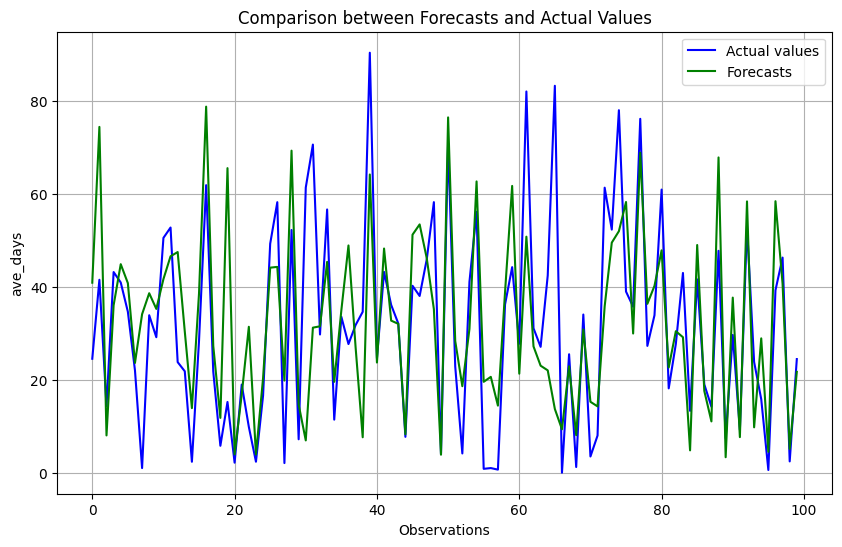

In [210]:
# Plotting some values for visual comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[0:100], label='Actual values', linestyle='-', color='b')
plt.plot(test_predictions[0:100], label='Forecasts', linestyle='-', color='g')

plt.title('Comparison between Forecasts and Actual Values')
plt.xlabel('Observations')
plt.ylabel('ave_days')
plt.legend()
plt.grid(True)
# Saving plot
plt.savefig('ML_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [211]:
forecast_date = pd.date_range(start='2015-04-01', end='2015-11-07', freq='d')
forecast_date


DatetimeIndex(['2015-04-01', '2015-04-02', '2015-04-03', '2015-04-04',
               '2015-04-05', '2015-04-06', '2015-04-07', '2015-04-08',
               '2015-04-09', '2015-04-10',
               ...
               '2015-10-29', '2015-10-30', '2015-10-31', '2015-11-01',
               '2015-11-02', '2015-11-03', '2015-11-04', '2015-11-05',
               '2015-11-06', '2015-11-07'],
              dtype='datetime64[ns]', length=221, freq='D')

In [212]:

forecast_df = pd.DataFrame(forecast_date)

In [213]:
forecast_df.head()

0
0 2015-04-01
1 2015-04-02
2 2015-04-03
3 2015-04-04
4 2015-04-05

In [214]:
import pandas as pd
from datetime import datetime, timedelta

# Defining date input format 2015-04-01 through 2015-11-07.
date_format = "%Y-%m-%d"

# Starting date
start_date = datetime(2015, 4, 1)
end_date = datetime(2015, 11, 7)
num_days = (end_date - start_date).days + 1  # Adding 1 to include the end date

# Creating date range with only year, month, and date
timestamps = [start_date + timedelta(days=i) for i in range(num_days)]

# Creating DataFrame with 'date' column
forecast_df = pd.DataFrame({'date': timestamps})

# Convert 'date' column to datetime type
forecast_df['date'] = pd.to_datetime(forecast_df['date'])

# Extracting desired date components
forecast_df['dayofweek'] = forecast_df['date'].dt.dayofweek
forecast_df['quarter'] = forecast_df['date'].dt.quarter
forecast_df['dayofmonth'] = forecast_df['date'].dt.day
forecast_df['month'] = forecast_df['date'].dt.month
forecast_df['year'] = forecast_df['date'].dt.year
forecast_df['Day_of_year'] = forecast_df['date'].dt.dayofyear
forecast_df['Weekend'] = forecast_df['date'].dt.weekday.isin([5, 6]).astype(int)

# Drop the 'date' column if no longer needed
forecast_df = forecast_df.drop('date', axis=1)

# Display the DataFrame
print(forecast_df)


     dayofweek  quarter  dayofmonth  month  year  Day_of_year  Weekend
0            2        2           1      4  2015           91        0
1            3        2           2      4  2015           92        0
2            4        2           3      4  2015           93        0
3            5        2           4      4  2015           94        1
4            6        2           5      4  2015           95        1
..         ...      ...         ...    ...   ...          ...      ...
216          1        4           3     11  2015          307        0
217          2        4           4     11  2015          308        0
218          3        4           5     11  2015          309        0
219          4        4           6     11  2015          310        0
220          5        4           7     11  2015          311        1

[221 rows x 7 columns]


In [215]:
# Function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

# Add season column to the dataframe
forecast_df['season'] = forecast_df['month'].apply(get_season)

In [216]:
desired_columns_order = ['dayofweek', 'quarter', 'dayofmonth', 'Day_of_year', 'month', 'Weekend', 'season', 'year']

# Reindex the DataFrame to match the desired order of columns
forecast_df = forecast_df.reindex(columns=desired_columns_order)

# Print the ordered DataFrame
print(forecast_df)

     dayofweek  quarter  dayofmonth  Day_of_year  month  Weekend  season  year
0            2        2           1           91      4        0       1  2015
1            3        2           2           92      4        0       1  2015
2            4        2           3           93      4        0       1  2015
3            5        2           4           94      4        1       1  2015
4            6        2           5           95      4        1       1  2015
..         ...      ...         ...          ...    ...      ...     ...   ...
216          1        4           3          307     11        0       3  2015
217          2        4           4          308     11        0       3  2015
218          3        4           5          309     11        0       3  2015
219          4        4           6          310     11        0       3  2015
220          5        4           7          311     11        1       3  2015

[221 rows x 8 columns]


In [223]:
X = forecast_df.drop('ML_Predictions', axis=1)
y = forecast_df['ML_Predictions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Printing train and test set size
print(f'Train set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')


Train set size: 176
Test set size: 45


In [218]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [219]:
X_train

dayofweek  quarter  dayofmonth  Day_of_year  month  Weekend  season  \
748           0        1          30           89      3        0       1   
1170          3        3           1          182      7        0       2   
1431          3        2          12          132      5        0       1   
1803          4        3          13          195      7        0       2   
1235          3        3          16          259      9        0       3   
...         ...      ...         ...          ...    ...      ...     ...   
1731          6        2          22          113      4        1       1   
763           2        2          15          105      4        0       1   
835           6        2          28          179      6        1       2   
1653          0        1          23           23      1        0       0   
2607          0        4          22          356     12        0       0   

      year  
748   2009  
1170  2010  
1431  2011  
1803  2012  
1235  2010  
...    ...  
1731  2012  
763   2009  
835   2009  
1653  2012  
2607  2014  

[2156 rows x 8 columns]

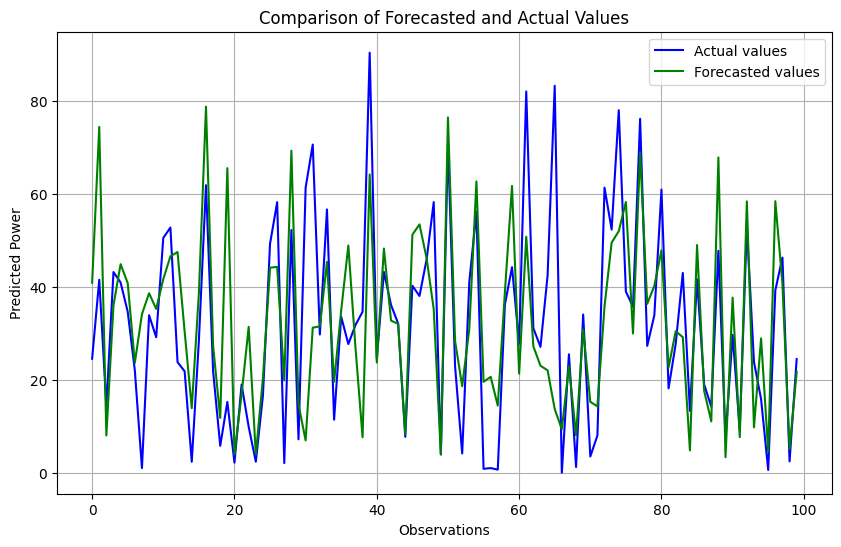

In [220]:
# Generating predictions on the test set for visualization
test_predictions = model.predict(X_test)

# Visualizing a subset of actual and forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting actual values
plt.plot(y_test.values[0:100], label='Actual values', linestyle='-', color='b')

# Plotting forecasted values
plt.plot(test_predictions[0:100], label='Forecasted values', linestyle='-', color='g')

# Adding title and axis labels
plt.title('Comparison of Forecasted and Actual Values')
plt.xlabel('Observations')
plt.ylabel('Predicted Power')

# Adding legend and grid
plt.legend()
plt.grid(True)

# Saving the plot
plt.savefig('ML_predictions.png', dpi=300, bbox_inches='tight')

# Displaying the plot
plt.show()


In [ ]:
dayofweek	quarter	dayofmonth	Day_of_year	month	Weekend	season	year

In [221]:
forecast_df.drop(columns=['ML_Predictions'], inplace=True)


KeyError: "['ML_Predictions'] not found in axis"

In [ ]:
forecast_df

dayofweek  quarter  dayofmonth  Day_of_year  month  Weekend  season  \
0            2        2           1           91      4        0       1   
1            3        2           2           92      4        0       1   
2            4        2           3           93      4        0       1   
3            5        2           4           94      4        1       1   
4            6        2           5           95      4        1       1   
..         ...      ...         ...          ...    ...      ...     ...   
216          1        4           3          307     11        0       3   
217          2        4           4          308     11        0       3   
218          3        4           5          309     11        0       3   
219          4        4           6          310     11        0       3   
220          5        4           7          311     11        1       3   

     year  ML_Predictions  
0    2015       71.194946  
1    2015       82.317597  
2    2015       82.317597  
3    2015        2.847826  
4    2015        2.847826  
..    ...             ...  
216  2015       56.289474  
217  2015       56.289474  
218  2015       56.056180  
219  2015       32.692500  
220  2015       25.776699  

[221 rows x 9 columns]

In [222]:
# Adding predictions to forecast_df
forecast_df_predictions = model.predict(forecast_df)
forecast_df['ML_Predictions'] = forecast_df_predictions
forecast_df

dayofweek  quarter  dayofmonth  Day_of_year  month  Weekend  season  \
0            2        2           1           91      4        0       1   
1            3        2           2           92      4        0       1   
2            4        2           3           93      4        0       1   
3            5        2           4           94      4        1       1   
4            6        2           5           95      4        1       1   
..         ...      ...         ...          ...    ...      ...     ...   
216          1        4           3          307     11        0       3   
217          2        4           4          308     11        0       3   
218          3        4           5          309     11        0       3   
219          4        4           6          310     11        0       3   
220          5        4           7          311     11        1       3   

     year  ML_Predictions  
0    2015       62.303426  
1    2015       72.172057  
2    2015       68.968971  
3    2015        4.901364  
4    2015        5.376808  
..    ...             ...  
216  2015       53.598591  
217  2015       56.088479  
218  2015       57.105704  
219  2015       40.854193  
220  2015        6.030819  

[221 rows x 9 columns]

In [ ]:
forecast_df

dayofweek  quarter  dayofmonth  Day_of_year  month  Weekend  season  \
0            2        2           1           91      4        0       1   
1            3        2           2           92      4        0       1   
2            4        2           3           93      4        0       1   
3            5        2           4           94      4        1       1   
4            6        2           5           95      4        1       1   
..         ...      ...         ...          ...    ...      ...     ...   
216          1        4           3          307     11        0       3   
217          2        4           4          308     11        0       3   
218          3        4           5          309     11        0       3   
219          4        4           6          310     11        0       3   
220          5        4           7          311     11        1       3   

     year  ML_Predictions  
0    2015       71.194946  
1    2015       82.317597  
2    2015       82.317597  
3    2015        2.847826  
4    2015        2.847826  
..    ...             ...  
216  2015       56.289474  
217  2015       56.289474  
218  2015       56.056180  
219  2015       32.692500  
220  2015       25.776699  

[221 rows x 9 columns]

In [224]:
# Assuming you have a DataFrame called forecast_df containing 'year', 'month', and 'dayofmonth' columns
forecast_data = forecast_df.rename(columns={'dayofmonth': 'day'})
forecast_data

dayofweek  quarter  day  Day_of_year  month  Weekend  season  year  \
0            2        2    1           91      4        0       1  2015   
1            3        2    2           92      4        0       1  2015   
2            4        2    3           93      4        0       1  2015   
3            5        2    4           94      4        1       1  2015   
4            6        2    5           95      4        1       1  2015   
..         ...      ...  ...          ...    ...      ...     ...   ...   
216          1        4    3          307     11        0       3  2015   
217          2        4    4          308     11        0       3  2015   
218          3        4    5          309     11        0       3  2015   
219          4        4    6          310     11        0       3  2015   
220          5        4    7          311     11        1       3  2015   

     ML_Predictions  
0         62.303426  
1         72.172057  
2         68.968971  
3          4.901364  
4          5.376808  
..              ...  
216       53.598591  
217       56.088479  
218       57.105704  
219       40.854193  
220        6.030819  

[221 rows x 9 columns]

In [225]:
# Assuming you have a DataFrame called forecast_df containing 'year', 'month', and 'dayofmonth' columns
forecast_data['date'] = pd.to_datetime(forecast_data[['year', 'month', 'day']])

# Drop the individual date components columns
forecast_data = forecast_data.drop(['year', 'month', 'day'], axis=1)

# Convert 'date' column to the desired format "%Y-%m-%d"
forecast_data['date'] = forecast_data['date'].dt.strftime("%Y-%m-%d")


In [226]:

forecast_data['date'] = pd.to_datetime(forecast_data['date'])

In [227]:
_df = forecast_data[['date', 'ML_Predictions']].copy()
_df.set_index('date',inplace= True)

In [257]:
merged_df

log_ave_days
date                    
2007-01-04     -1.717651
2007-01-05     -0.693147
2007-01-06      4.052480
2007-01-07      4.052480
2007-01-08      1.258955
...                  ...
2015-03-26      3.968594
2015-03-27      3.652754
2015-03-28      0.039221
2015-03-29      3.737670
2015-03-30      4.150680

[3008 rows x 1 columns]

In [229]:
df.set_index('date',inplace= True)

KeyError: "None of ['date'] are in the columns"

In [255]:
df_arima

ave_days
date                 
2007-01-04   0.179487
2007-01-05   0.500000
2007-01-06  57.539966
2007-01-07  57.539966
2007-01-08   3.521739
...               ...
2015-03-27  38.580756
2015-03-28   1.040000
2015-03-29  42.000000
2015-03-30  63.477124
2015-03-31  40.496689

[3009 rows x 1 columns]

C:\Users\sam\AppData\Local\Temp\ipykernel_22308\3766082514.py:2: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



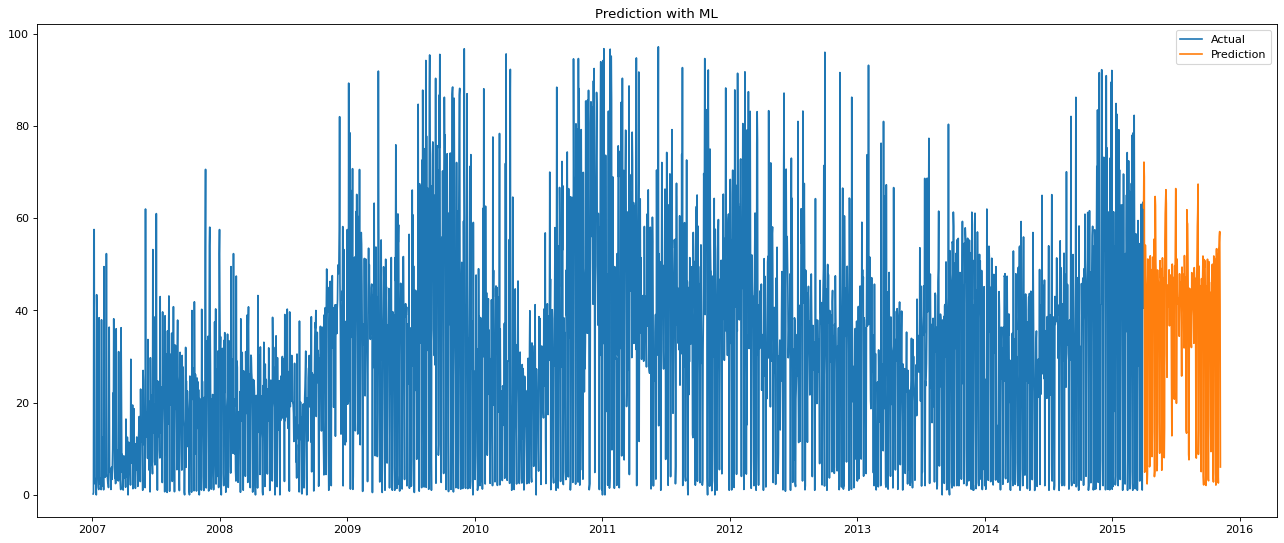

In [259]:
fig=plt.figure(figsize=(20,8), dpi=80)
fig.show()
ax=fig.add_subplot(111)
plt.title('Prediction with ML')
ax.plot(df.ave_days, label='Actual')
ax.plot(_df , label='Prediction')
plt.legend()
plt.show()

In [192]:
Pred_results

Date     ARIMA       UCM  ML
0    2015-04-01  4.399049  4.105553 NaN
1    2015-04-02  4.346730  4.032646 NaN
2    2015-04-03  3.827828  3.972013 NaN
3    2015-04-04  0.889177  1.568779 NaN
4    2015-04-05  0.880895  1.314604 NaN
..          ...       ...       ...  ..
216  2015-11-03  3.882333  4.601167 NaN
217  2015-11-04  4.091225  4.770493 NaN
218  2015-11-05  4.161342  4.595360 NaN
219  2015-11-06  4.114823  4.306945 NaN
220  2015-11-07  0.265957  0.476387 NaN

[221 rows x 4 columns]

In [225]:
# saving the results of the arima model
Pred_results['ML'] = _df.ML_Predictions.values
Pred_results

Date     ARIMA       UCM         ML
0    2015-04-01  4.399049  4.105553  70.492996
1    2015-04-02  4.346730  4.032646  79.973946
2    2015-04-03  3.827828  3.972013  80.863759
3    2015-04-04  0.889177  1.568779   3.971186
4    2015-04-05  0.880895  1.314604   2.621175
..          ...       ...       ...        ...
216  2015-11-03  3.882333  4.601167  51.971427
217  2015-11-04  4.091225  4.770493  53.090155
218  2015-11-05  4.161342  4.595360  52.702620
219  2015-11-06  4.114823  4.306945  36.531161
220  2015-11-07  0.265957  0.476387  23.335741

[221 rows x 4 columns]

In [226]:
file_path = "C:/Users/sam/Desktop/TimeSeries/Project/Preds_Results/896440_20240218.csv"

# Export DataFrame to CSV
Pred_results.to_csv(file_path, index=False)